In [ ]:
from scipy.signal import welch, csd
import itertools
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

# If statannot is not installed yet
!pip install statannot

from statannot import add_stat_annotation
import scipy.stats as stats
import pandas as pd
from matplotlib.lines import Line2D

import seaborn as sns; sns.set_theme(color_codes=True)
from scipy.signal import butter, lfilter
import scipy.io
import glob

from scipy.stats import pearsonr
from scipy.stats import shapiro, mannwhitneyu
import h5py
import numpy as np
import os, stat

from scipy.signal import find_peaks
import math

import pickle
from tqdm import tqdm

from scipy.integrate import simps

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from scipy.stats import wilcoxon
import scipy.io as sio
from pprint import pprint
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from IPython.display import display, HTML

Mounted at /content/drive


In [ ]:
def cohen_d(group1, group2):
    """
    Calculate Cohen's d effect size for two groups.

    Parameters:
    group1: array-like, data of the first group.
    group2: array-like, data of the second group.

    Returns:
    float, Cohen's d effect size.
    """
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.var(group1) + np.var(group2)) / 2)
    return mean_diff / pooled_std

def plot_cohens(features, group1, group2, group3, metrics, colors=["#2E8B57", "#00bfff", "#000080"], exclude_keys=None):
    """
    Computes and visualizes Cohen's d effect sizes for multiple metrics across specified groups,
    applying global False Discovery Rate (FDR) correction to p-values.

    This function iterates over a set of metrics, computes Cohen's d effect size, and performs
    Mann-Whitney U tests for group comparisons. It applies global FDR correction across all metrics
    and generates styled Pandas DataFrames for each metric.

    Parameters:
    - features (dict): A dictionary where keys are feature names and values are pandas DataFrames
                       containing the data for those features.
    - group1, group2, group3 (str): The names of the groups to be compared.
    - metrics (list of str): List of metrics to be analyzed (e.g., ["GE", "SW"]).
    - colors (list of str, optional): Colors for different groups. Default colors are provided.
    - exclude_keys (list of str, optional): Feature keys to be excluded from the analysis.

    Returns:
    - styled_results (dict): A dictionary where each key is a metric and each value is a styled
                             pandas DataFrame. These DataFrames contain the computed Cohen's d values,
                             FDR-corrected p-values, and are styled for better visualization.
    """
    metrics_results = {}  # Dictionary to store results for each metric
    global_p_values = []  # Store all p-values for global FDR correction
    global_comparisons = []  # Store all comparisons

    # Check for excluded keys
    if exclude_keys is None:
        exclude_keys = []

    for metric in metrics:
        results_dfs = []  # Store intermediate DataFrames for current metric

        # Loop through the stages and frequency bands (keys)
        for key in features.keys():
            if key in exclude_keys:
                continue

            main = features[key]
            da = main[main['Class'] == group1][metric].dropna().values
            db = main[main['Class'] == group2][metric].dropna().values
            dc = main[main['Class'] == group3][metric].dropna().values

            # Calculate Cohen's d effect size for each group comparison
            d_g2_vs_g1 = cohen_d(db, da)
            d_g3_vs_g2 = cohen_d(dc, db)
            d_g3_vs_g1 = cohen_d(dc, da)

            # Calculate p-values for each comparison
            p_g2_vs_g1 = mannwhitneyu(db, da).pvalue
            p_g3_vs_g2 = mannwhitneyu(dc, db).pvalue
            p_g3_vs_g1 = mannwhitneyu(dc, da).pvalue

            # Store results in a temporary DataFrame and add it to the list
            temp_df = pd.DataFrame({
                'Feature': [key],
                f'd_{group2}_>_{group1}': [d_g2_vs_g1],
                f'd_{group3}_>_{group2}': [d_g3_vs_g2],
                f'd_{group3}_>_{group1}': [d_g3_vs_g1]
            })
            results_dfs.append(temp_df)

            # Store p-values and corresponding comparisons
            comparisons = [
                (group1, group2),
                (group2, group3),
                (group1, group3)
            ]
            for p_val, comp in zip([p_g2_vs_g1, p_g3_vs_g2, p_g3_vs_g1], comparisons):
                global_p_values.append(p_val)
                global_comparisons.append((metric, key, comp))

        # Concatenate DataFrames for current metric
        metric_results_df = pd.concat(results_dfs, ignore_index=True)
        metrics_results[metric] = metric_results_df

    # Apply global FDR correction
    _, global_p_corrected, _, _ = multipletests(global_p_values, method='fdr_bh')

    # Define the styling function for later use painting the tables
    def style_specific_cells(row):
        """
        Applies different styles to the cells in a row based on their values and column names.
        """
        styles = []
        for col, val in row.items():
            style = ''
            if isinstance(val, float):
                if col.startswith('d_'):
                    if val < -0.45:
                        style = 'background-color: lightblue;'
                    elif val > 0.45:
                        style = 'background-color: lightcoral;'
                elif col.startswith('p_'):
                    if val < 0.05:
                        style = 'background-color: yellow;'
            styles.append(style)
        return styles

    # Update each metric's DataFrame with corrected p-values
    for i, (metric, key, comp) in enumerate(global_comparisons):
        p_adj = global_p_corrected[i]
        group1, group2 = comp
        metrics_results[metric].loc[metrics_results[metric]['Feature'] == key, f'p_adj_{group1}_vs_{group2}'] = p_adj

    styled_results = {}

    # Rename for readability
    rename_map = {'1_': 'N2_', '3_': 'REM_', '4_': 'Awake_'}  # Renaming map

    for metric, df in metrics_results.items():
        # Rename entries in the "Feature" column
        for old, new in rename_map.items():
            df['Feature'] = df['Feature'].str.replace(f'^{old}', new, regex=True)

        # Apply styling after renaming
        styled_df = df.style.apply(style_specific_cells, axis=1)
        styled_results[metric] = styled_df

    return styled_results


def cohens_d_channels_w_pval(group1_mats, group2_mats, channels, threshold_1=0.5, threshold_2=0.7, excluded_awake_channels=None, excluded_keys=None):
    """
    Calculate Cohen's D effect size between two groups across channels.
    Perform statistical testing using Mann-Whitney U and FDR correction.
    Plot effect size matrices annotated with significant p-values as asterisks.

    Parameters
    ----------
    group1_mats : dict
        Connectivity matrices for group 1 subjects, keyed by condition.
        Matrices have shape (n_subjects, n_channels, n_channels).
    group2_mats : dict
        Connectivity matrices for group 2 subjects, keyed by condition.
    channels : list
        Channel names corresponding to matrix indices.
    threshold_1: float, first minimum effect size considered. Default is 0.5.
    threshold_2: float, second minimum effect size considered. Default is 0.7.
    excluded_awake_channels : list, optional
        Channels to exclude for awake state.
    excluded_keys : list, optional
        Keys to exclude from analysis.

    Returns
    -------
    None

    Plots
    -----
    Cohen's D effect size matrices for each condition, with asterisks
    indicating significant connections after FDR correction.

    """
    # Set p-value Threshold
    alpha = 0.05
    # Use Benjamini-Hochberg FDR correction
    method = "fdr_bh"

    # Calculate test scores, p-values and Cohen's d for all keys
    tscore_matrices = {}
    pval_matrices = {}
    cohen_d_matrices = {}

    # Loop through stages and frequencies (i.e., keys)
    for key in group1_mats.keys():
        if key in excluded_keys:
            continue

        # Store current key data
        group1_data = np.array(group1_mats[key])
        group2_data = np.array(group2_mats[key])

        # If the key starts with '4_', exclude specified channels (e.g., Fp1 and Fp2 channels in Awake)
        if key.startswith('4_') and excluded_awake_channels is not None:
            group1_data = np.delete(group1_data, excluded_awake_channels, axis=1)
            group1_data = np.delete(group1_data, excluded_awake_channels, axis=2)
            group2_data = np.delete(group2_data, excluded_awake_channels, axis=1)
            group2_data = np.delete(group2_data, excluded_awake_channels, axis=2)

        # Initialize matrices
        matrix_size = group1_data.shape[1]
        cohen_d_matrix = np.zeros((matrix_size, matrix_size))
        tscore_matrix = np.zeros((matrix_size, matrix_size))
        pval_matrix = np.zeros((matrix_size, matrix_size))

        # Calculate test scores, Cohen's d and p-values for each matrix entry
        for i in range(matrix_size):
            for j in range(matrix_size):
                if i > j:
                    t_stat, p_val = stats.ranksums(group1_data[:, i, j], group2_data[:, i, j])
                    tscore_matrix[i, j] = t_stat
                    pval_matrix[i, j] = p_val
                    cohen_d_matrix[i, j] = cohen_d(group1_data[:, i, j], group2_data[:, i, j])

        # Make test-score matrix symmetric for visualization by adding its transpose (diagonals are zero)
        tscore_matrices[key] = tscore_matrix + tscore_matrix.T

        # Store the Cohen's D matrix for the current key and symmetrize
        cohen_d_matrices[key] = cohen_d_matrix + cohen_d_matrix.T

        # The p-value matrix is made symmetric later, after the FDR correction
        pval_matrices[key] = pval_matrix

    # Calculate FDR-corrected channel-wise p-values
    # Eliminate zero entries corresponding to the diagonal and unused triangular matrix part
    # Stack p-values for all keys (stages and bands)
    all_pvals = np.hstack([pval_matrix[pval_matrix != 0] for pval_matrix in pval_matrices.values()])

    # Replace NaN values (i.e, channels excluded in awake segments due to excesive amount of artifacts for some subjects)
    # with 1.0 before doing the FDR correction. If not replaced, NaNs would propagate in the "multipletests" toolbox.
    # By default, np.nan_to_num would replace NaNs with 0, but we want to replace them with a
    # maximal p-value of 1.0 instead so they are not counted as significant.
    all_pvals = np.nan_to_num(all_pvals, nan=1.0)
    all_corrected_pvals = multipletests(pvals=all_pvals, alpha=alpha, method=method)[1]
    print('Number of channel-wise p-values to correct = ' + str(len(all_corrected_pvals)) + '\n')

    # Create corrected p-value matrices for each key
    corrected_pval_matrices = {}
    start_idx = 0
    for key, pval_matrix in pval_matrices.items():
        matrix_size = pval_matrix.shape[0]
        corrected_pval_matrix = np.zeros((matrix_size, matrix_size))

        t = 0
        for i in range(matrix_size):
            for j in range(matrix_size):
                if i > j:
                    # Fill corrected matrix
                    corrected_pval_matrix[i, j] = all_corrected_pvals[start_idx + t]
                    t += 1
        start_idx += t
        # Make the matrix symmetric for displaying adding transpose and diagonal of ones
        # Store on the corresponding key
        corrected_pval_matrix = corrected_pval_matrix + corrected_pval_matrix.T + np.identity(matrix_size)
        corrected_pval_matrices[key] = corrected_pval_matrix

    # Set plot parameters
    sns.set_style("whitegrid", {'axes.grid': False})
    plt.rcParams["figure.figsize"] = [10, 10]
    linewidth = 3

    # Loop through keys to plot the Cohen's d matrix with asterisks as significant p-values
    for key in group1_mats.keys():
        if key in excluded_keys:
            continue

        # Get the matrices for each key (other matrices could be plotted if needed)
        tscore_matrix = tscore_matrices[key]
        corrected_pval_matrix = corrected_pval_matrices[key]
        uncorrected_pval_matrix = pval_matrices[key]
        cohen_d_matrix = cohen_d_matrices[key]

        # Get matrices to display averages per group
        group1_data = np.array(group1_mats[key])
        group2_data = np.array(group2_mats[key])

        # If the key starts with '4_', exclude specified channels (e.g., Fp1 and Fp2 channels in Awake)
        if key.startswith('4_') and excluded_awake_channels is not None:
            group1_data = np.delete(group1_data, excluded_awake_channels, axis=1)
            group1_data = np.delete(group1_data, excluded_awake_channels, axis=2)
            group2_data = np.delete(group2_data, excluded_awake_channels, axis=1)
            group2_data = np.delete(group2_data, excluded_awake_channels, axis=2)

        # Define Cohen's d thresholds and colors
        thresholds = [threshold_1, threshold_2]
        cmap = plt.cm.coolwarm  # define the colormap
        # Extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]

        # Create the new map
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, cmap.N)

        # Define 5 color bins (two for negative values, two for positive, one in between +/- threshold_1.
        # Will plot one color from threshold_1 to threshold_2,
        # and another from threshold_2 upwards (similarly for negative values)
        bounds = np.linspace(-2*threshold_2, 2*threshold_2, 5)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        # Define title based on the key prefix
        if key.startswith("1_"):
            title_prefix = "N2 "
            key = key[2:]  # Remove the prefix
            current_channels = channels  # Use all channels
        elif key.startswith("3_"):
            title_prefix = "REM "
            key = key[2:]  # Remove the prefix
            current_channels = channels  # Use all channels
        elif key.startswith("4_"):
            title_prefix = "Awake "
            key = key[2:]  # Remove the prefix
            # Remove excluded awake channels for plotting
            current_channels = [ch for i, ch in enumerate(channels) if excluded_awake_channels is None or i not in excluded_awake_channels]

        else:
            title_prefix = ""

        # Mask values between -threshold_1 and threshold_1 so they are displayed white
        mask = (cohen_d_matrix >= -threshold_1) & (cohen_d_matrix <= threshold_1)
        cohen_d_matrix = np.ma.masked_array(cohen_d_matrix, mask=mask)

        # Create four plots in a row per key
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        # Plot for group 1 average
        avg_group1 = np.nanmean(group1_data, axis=0)
        im1 = axs[0].imshow(avg_group1, cmap='Reds', vmin=0, vmax=0.25)
        axs[0].set_title('Average Group 1')
        axs[0].set_xticks(list(range(len(current_channels))))
        axs[0].set_xticklabels(current_channels, rotation=90, fontsize=12)
        axs[0].set_yticks(list(range(len(current_channels))))
        axs[0].set_yticklabels(current_channels, rotation=0, fontsize=12)
        fig.colorbar(im1, ax=axs[0])

        # Plot for group 2 average
        avg_group2 = np.nanmean(group2_data, axis=0)
        im2 = axs[1].imshow(avg_group2, cmap='Reds', vmin=0, vmax=0.25)
        axs[1].set_title('Average Group 2')
        axs[1].set_xticks(list(range(len(current_channels))))
        axs[1].set_xticklabels(current_channels, rotation=90, fontsize=12)
        axs[1].set_yticks(list(range(len(current_channels))))
        axs[1].set_yticklabels(current_channels, rotation=0, fontsize=12)
        fig.colorbar(im2, ax=axs[1])

        # Plot for Cohen's D
        im3 = axs[2].imshow(cohen_d_matrix, cmap=cmap, norm=norm)
        axs[2].set_title("Cohen's D Effect Size")
        axs[2].set_xticks(list(range(len(current_channels))))
        axs[2].set_xticklabels(current_channels, rotation=90, fontsize=12)
        axs[2].set_yticks(list(range(len(current_channels))))
        axs[2].set_yticklabels(current_channels, rotation=0, fontsize=12)
        # Mantain matrix sizes without showing a colorbar (a legend will be added in the manuscript figure)
        cbar = fig.colorbar(im3, ax=axs[2])
        cbar.ax.set_visible(False)

        # Plot for FDR-corrected p-values
        im4 = axs[3].imshow(corrected_pval_matrix, cmap='Greens_r', vmin=0, vmax=alpha)
        axs[3].set_title('FDR-corrected p-values')
        axs[3].set_xticks(list(range(len(current_channels))))
        axs[3].set_xticklabels(current_channels, rotation=90, fontsize=12)
        axs[3].set_yticks(list(range(len(current_channels))))
        axs[3].set_yticklabels(current_channels, rotation=0, fontsize=12)
        fig.colorbar(im4, ax=axs[3])

        fig.suptitle(f"{title_prefix}{key}", fontsize=22)
        plt.tight_layout()
        plt.show()

def plot_1st_vs_2nd_night(df, x_column, y_column, title):
    """
    Generate a scatter plot with regression line comparing two nights of EEG data.

    Parameters
    ----------
    df : pandas DataFrame
        DataFrame containing the data.
    x_column : str
        Column name for x-axis data (first night).
    y_column : str
        Column name for y-axis data (second night).
    title : str
        Plot title.

    Returns
    -------
    None

    Generates a scatter plot with regression line, including Pearson correlation
    coefficient and p-value in the legend. Compares data between two nights.

    """
    plt.rcParams["figure.figsize"] = (6, 6)
    sns.set(font_scale=2.25)
    sns.set_style(style='white')

    r, p = stats.pearsonr(df[x_column], df[y_column])

    b = sns.regplot(x=x_column, y=y_column, data=df, fit_reg=True, scatter=True, color='blue', label=str(f'$R = {r:.4f}$' + '   ' + f'$p = {p:.4f}$'))

    # Create a custom legend entry for the regression line
    custom_legend_entry = Line2D([0], [0], color='blue', linewidth=1.5, label=str(f'$R = {r:.4f}$' + '   ' + f'$p = {p:.4f}$'))

    b.axes.set_title(title, fontsize=12)
    b.set_xlabel("First night", fontsize=12)
    b.set_ylabel("Second night", fontsize=12)
    b.tick_params(labelsize=12)

    # Add the custom legend entry to the legend
    b.legend(handles=[custom_legend_entry], fontsize=12, loc='lower right')

    plt.show()

def plot_med_effects(main, group1, group2, group3, metric, alpha=0.05, colors=["#2E8B57", "#00bfff", "#000080"]):
    """
    Generate violin plot comparing 3 groups split by medication status.
    Perform Mann-Whitney U test and obtain p-values to add to the annotation.

    Parameters
    ----------
    main : DataFrame
        DataFrame containing all data.
    group1 : str
        Name of first group to compare.
    group2 : str
        Name of second group to compare.
    group3 : str
        Name of third group to compare.
    metric : str
        Column name for data to plot.
    alpha : float, optional
        Significance level for statistical test.
    colors : list, optional
        List of colors for each group.

    Returns
    -------
    None

    Generates violin plots with each group split out by medication status.
    Performs statistical testing between each pair of groups.

    """
    plt.rcParams["figure.figsize"] = (8, 5)
    sns.set_palette(sns.color_palette(colors))
    sns.set(font_scale=1)
    sns.set_style(style='white')


    # Subset the data for each group
    da = main[main['Class'] == group1]
    db = main[main['Class'] == group2]
    dc = main[main['Class'] == group3]

    # Create violin plots
    fig, axes = plt.subplots(1, 1)
    plt.subplots_adjust(wspace=0.4)
    ax = axes

    order = [group1, group2, group3]

    x="Class"
    y=metric

    sns.violinplot(ax=ax, data=main, x=x, y=y, palette=colors, order=[group1, group2, group3])
    test_results = add_stat_annotation(ax, data=main, x=x, y=y, order=order,
                                      box_pairs=[(group1, group2),(group2, group3),(group1, group3)],
                                      pvalue_format_string= '{:.3f}',
                                      test= 'Mann-Whitney', text_format='simple', loc='outside', verbose=0)

    plt.show()


# Bipolar channels
channels = ['Fp1-Fp2', 'F7-Fp1', 'F8-Fp2', 'F7-F3', 'F8-F4', 'F3-Fz', 'F4-Fz', 'C3-Cz',
            'C4-Cz', 'T3-C3', 'T4-C4', 'T5-P3', 'T6-P4', 'P3-Pz', 'P4-Pz', 'T5-O1',
            'T6-O2', 'O1-O2']

In [ ]:
# Load data from previous runs
def load_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

features = load_data('./features_v6.pickle')
metrics = load_data('./metrics_v6.pickle')
second_night = load_data('./features_2nd_night.pickle')

In [ ]:
# # Exclude subjects

# N=6 (IMPNOMCI dx at most recent visit)
# ADE004 (no MoCA) => ADEX_025
# ADE024 (MoCA increases from 24 to 27) => ADEX_103
# ADE052 (MoCA increases from 24 to 28) => ADEX_084
# ADE055 (MoCA increases from 23 to 26) => ADEX_080
# ADE070 (MoCA decreases from 28 to 24) => ADEX_079
# ADE071 (MoCA increases from 27 to 29) => ADEX_068

# N=1 (no clinical cog status in database – does not look like AD anyways based on neuropsych data)
# ADE075 (no MoCA) => Not included before

# N=1 (IMPNOMCI at most visits until latest visit is AMCI; cognitively normal visit after EEG;
# vascular dementia/vascular brain injury noted as suspected pathology at multiple visits)
# ADE001 (MoCA decreases from 25 to 24 over 7yrs) => ADEX_048

ids_to_remove = ['ADEX_025', 'ADEX_103', 'ADEX_084', 'ADEX_080',
              'ADEX_079', 'ADEX_068', 'ADEX_048']

# Remove subjects from "features" structure
for key in features.keys():
    features[key] = features[key][~features[key]['ID'].isin(ids_to_remove)]

# Remove subjects from "metrics" structure
for key in metrics.keys():
    for sub_key in metrics[key].keys():
        # Find indices of the IDs to be removed
        indices_to_remove = [i for i, id in enumerate(metrics[key][sub_key]['ID']) if id in ids_to_remove]

        # Remove the entries for these indices in all sub-entries (like 'ID', 'AEC', etc.)
        for entry in metrics[key][sub_key]:
            if isinstance(metrics[key][sub_key][entry], list):
                # If the entry is a list, remove the elements at the indices
                metrics[key][sub_key][entry] = [item for i, item in enumerate(metrics[key][sub_key][entry]) if i not in indices_to_remove]
            elif isinstance(metrics[key][sub_key][entry], np.ndarray):
                # If the entry is a numpy array, remove the rows at the indices
                metrics[key][sub_key][entry] = np.delete(metrics[key][sub_key][entry], indices_to_remove, axis=0)

# # Remove subjects from "second_night" structure
for key in second_night.keys():
    # Exclude the entries for the specified IDs
    second_night[key] = second_night[key][~second_night[key]['ID'].isin(ids_to_remove)]

In [ ]:
# Display the Cohen's d and FDR-corrected p-value tables of different metrics
metric = ['GE_AEC', 'SW_AEC', 'GE_ImCoh', 'SW_ImCoh', 'GE_PLI', 'SW_PLI', 'GE_wPLI', 'SW_wPLI']  # Example metrics
all_metrics_tables = plot_cohens(features, 'HC', 'ADNoEp', 'ADEp', metric, exclude_keys=["4_beta", "4_gamma"])

# Display each table
for metric, table in all_metrics_tables.items():
    html = table.to_html()
    display(HTML(f"<h3>{metric}</h3>"))  # Display the metric name as a header
    display(HTML(html))

In [ ]:
# Plot the matrices

# Get the 'AEC' matrices for all groups from the "metrics" data structure
adnoep_aec = {key: val['ADNoEp']['AEC'] for key, val in metrics.items()}
adep_aec = {key: val['ADEp']['AEC'] for key, val in metrics.items()}
hc_aec = {key: val['HC']['AEC'] for key, val in metrics.items()}

In [ ]:
# Get the 'AEC' matrices for all groups from the "metrics" data structure
adnoep_coh = {key: val['ADNoEp']['PLI'] for key, val in metrics.items()}
adep_coh = {key: val['ADEp']['PLI'] for key, val in metrics.items()}
hc_coh = {key: val['HC']['PLI'] for key, val in metrics.items()}

Number of channel-wise p-values to correct = 1845



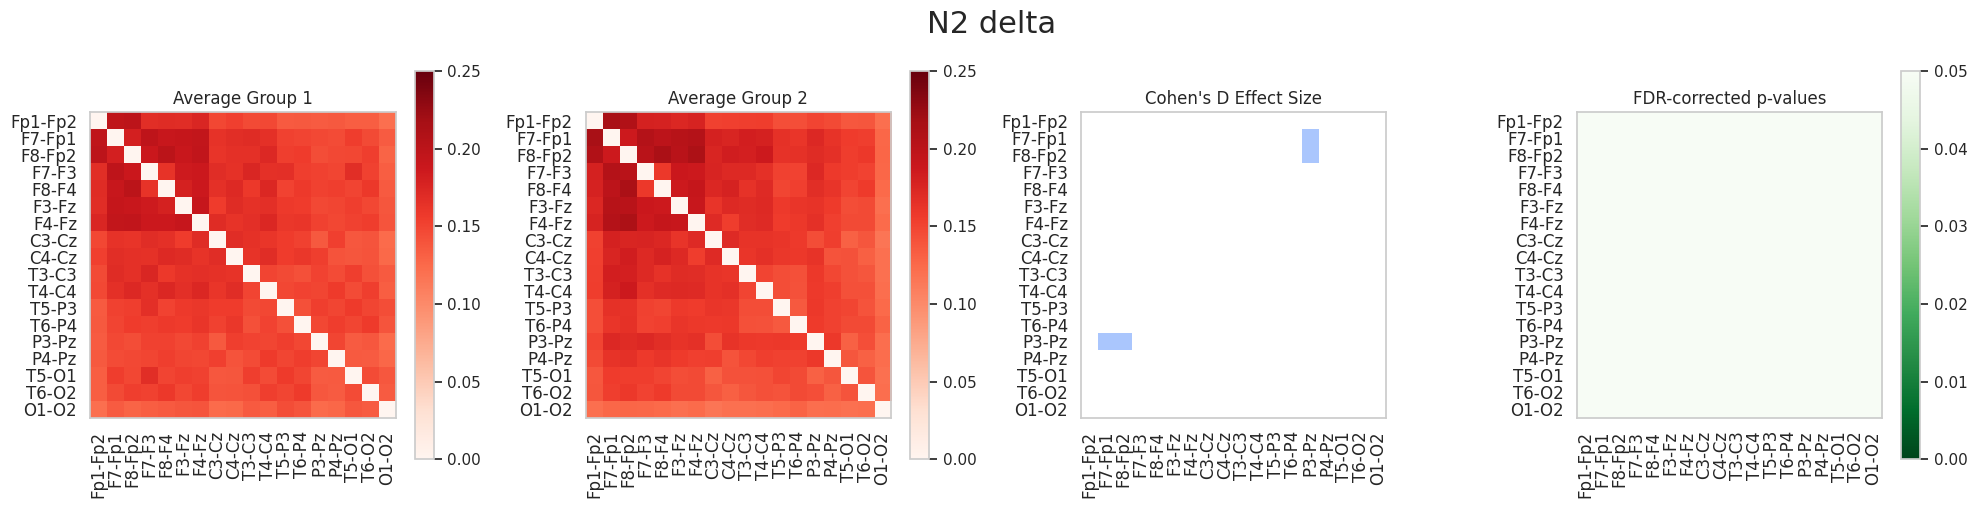

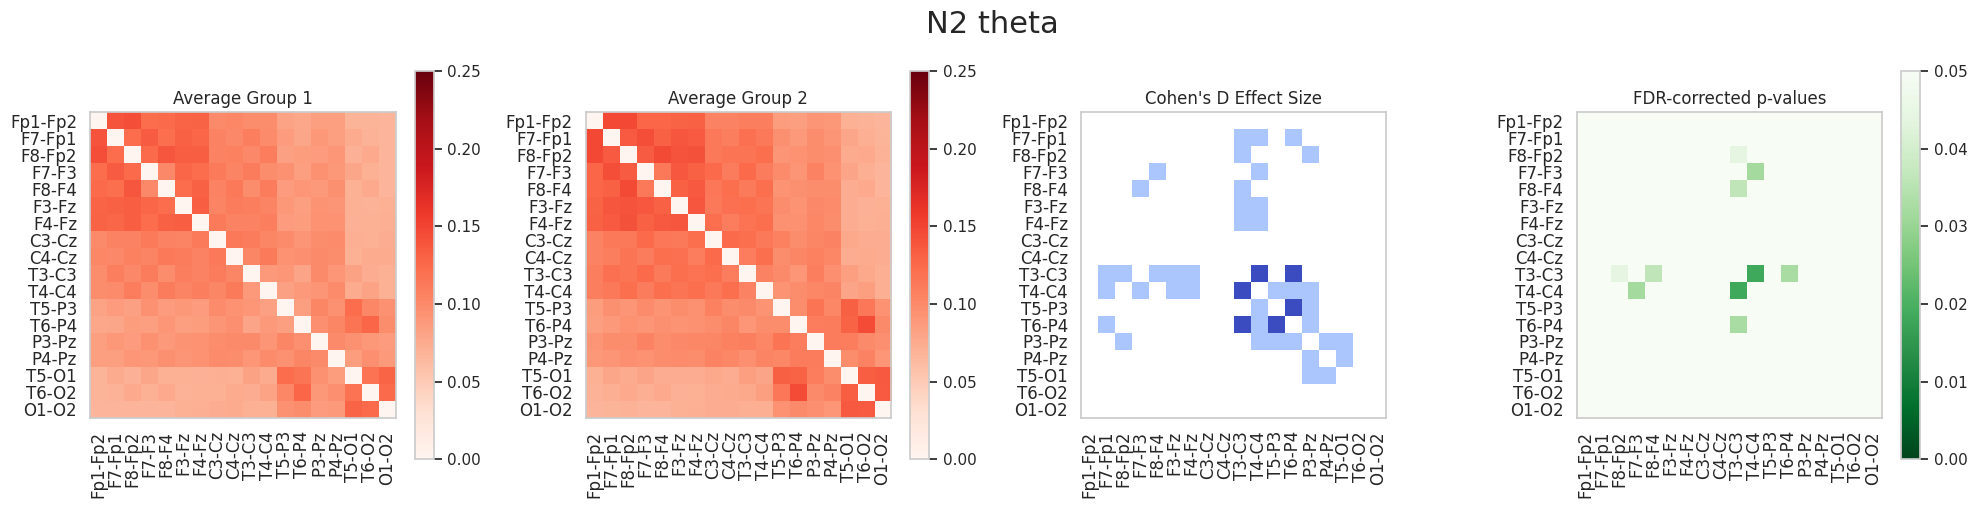

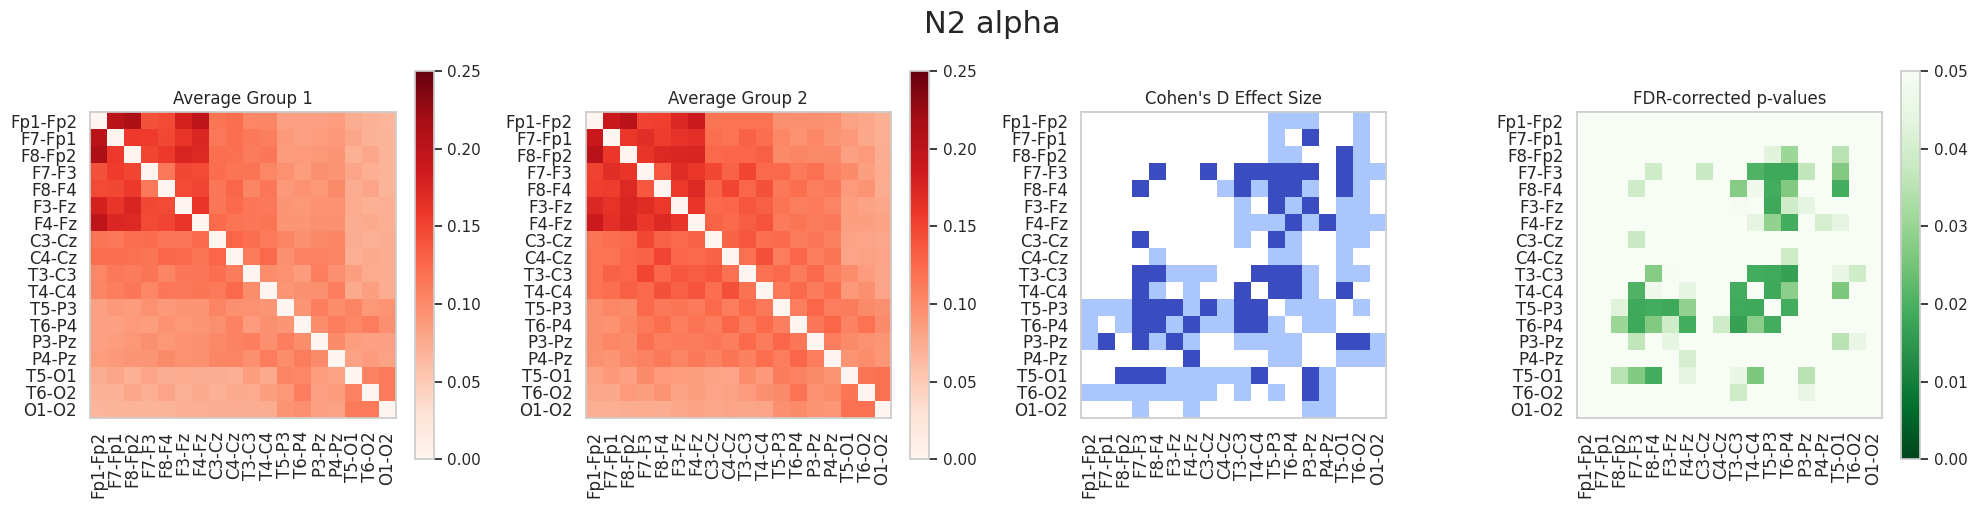

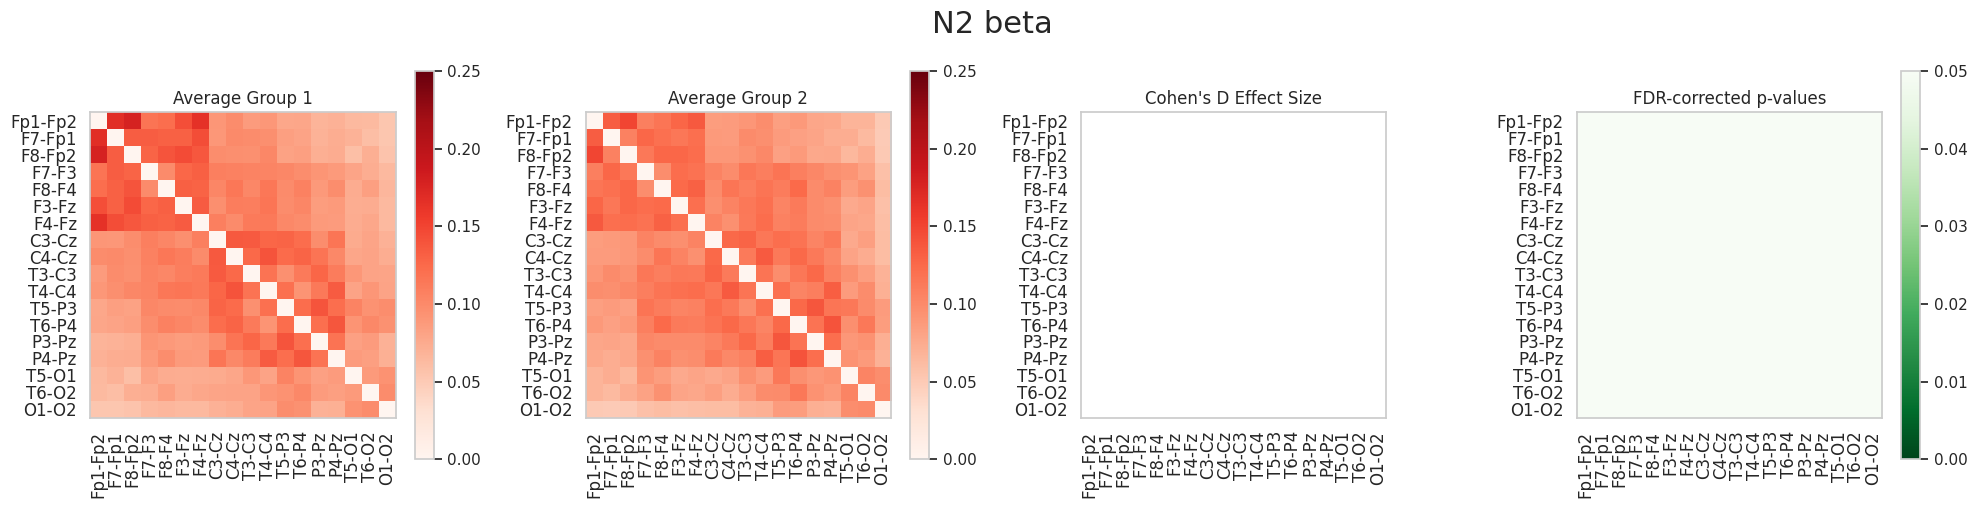

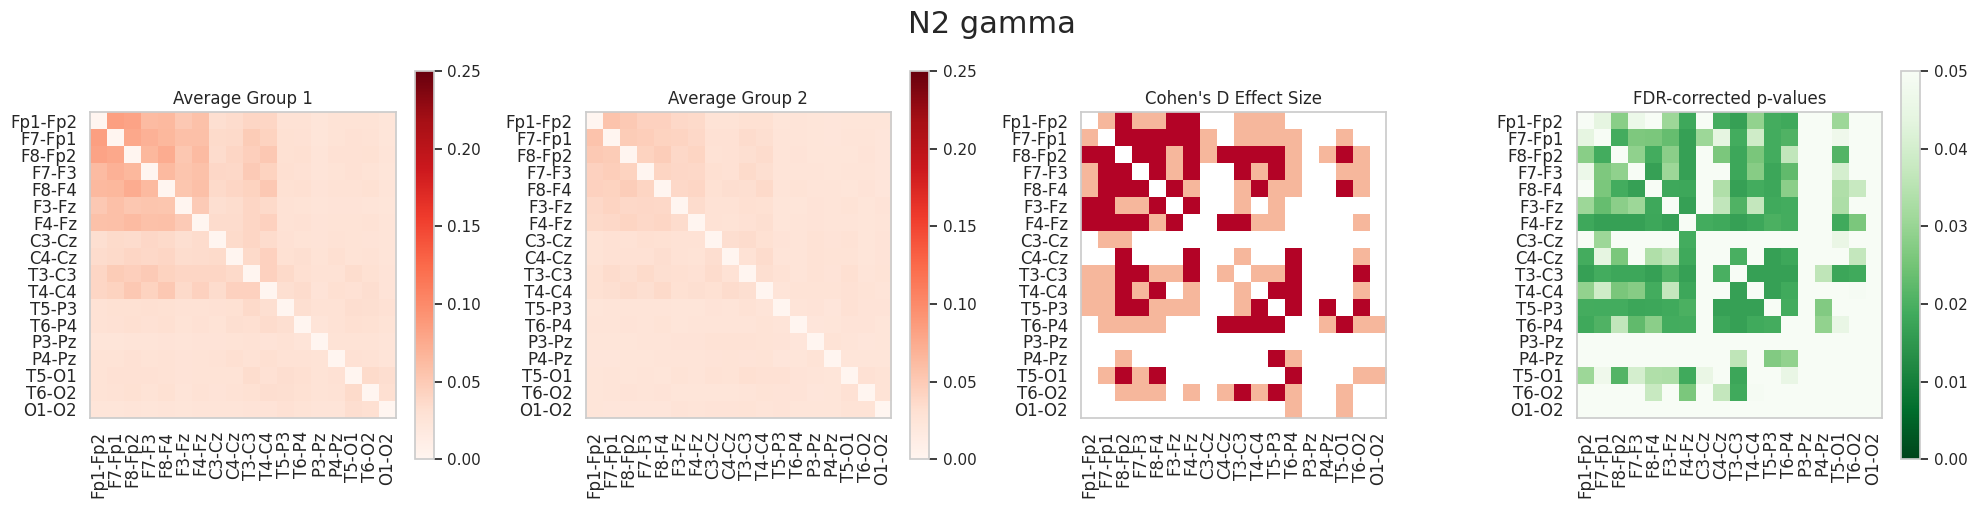

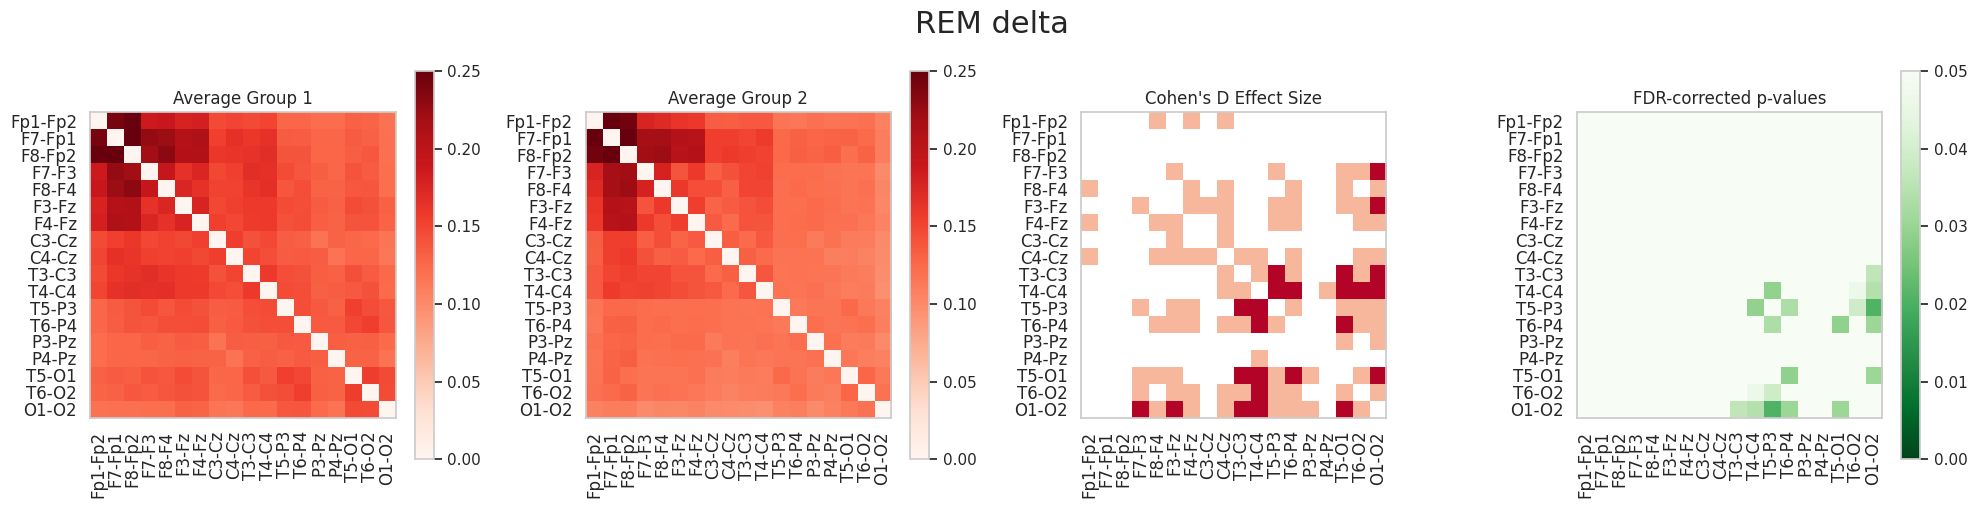

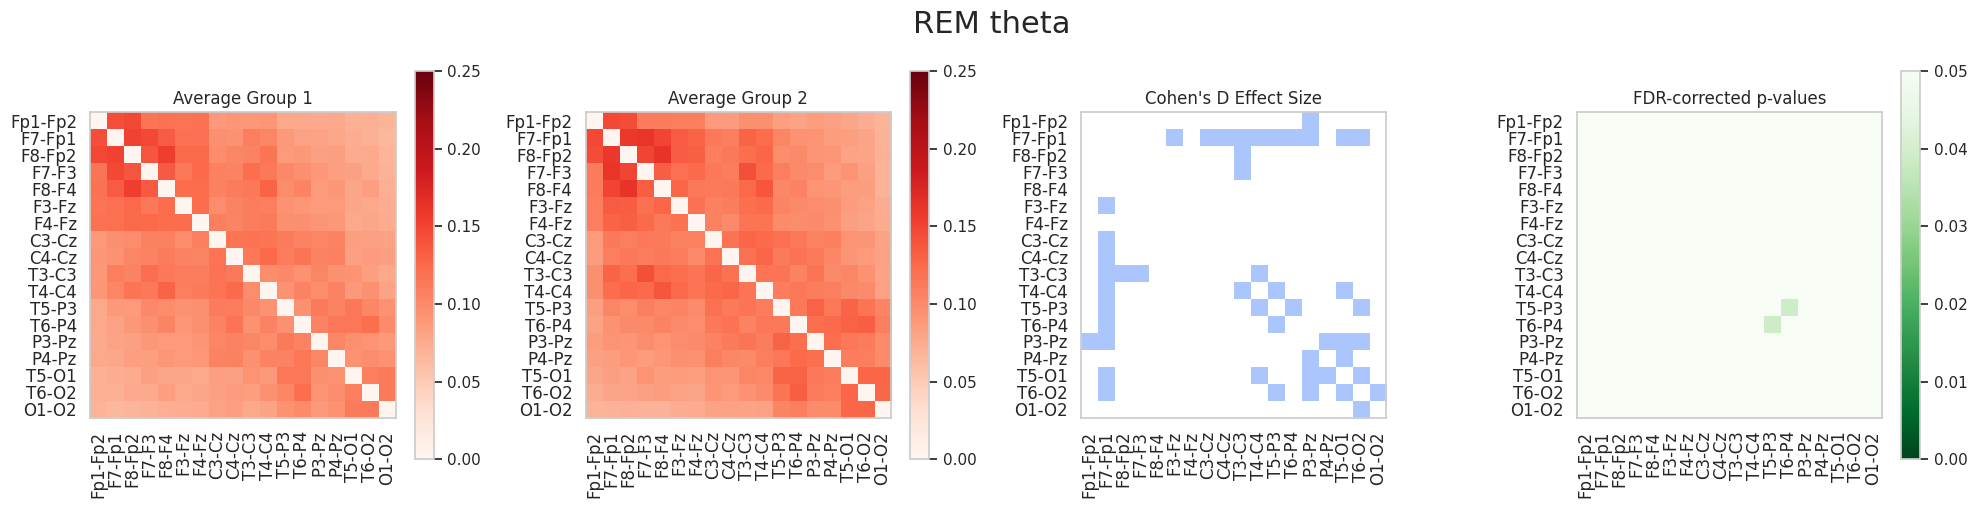

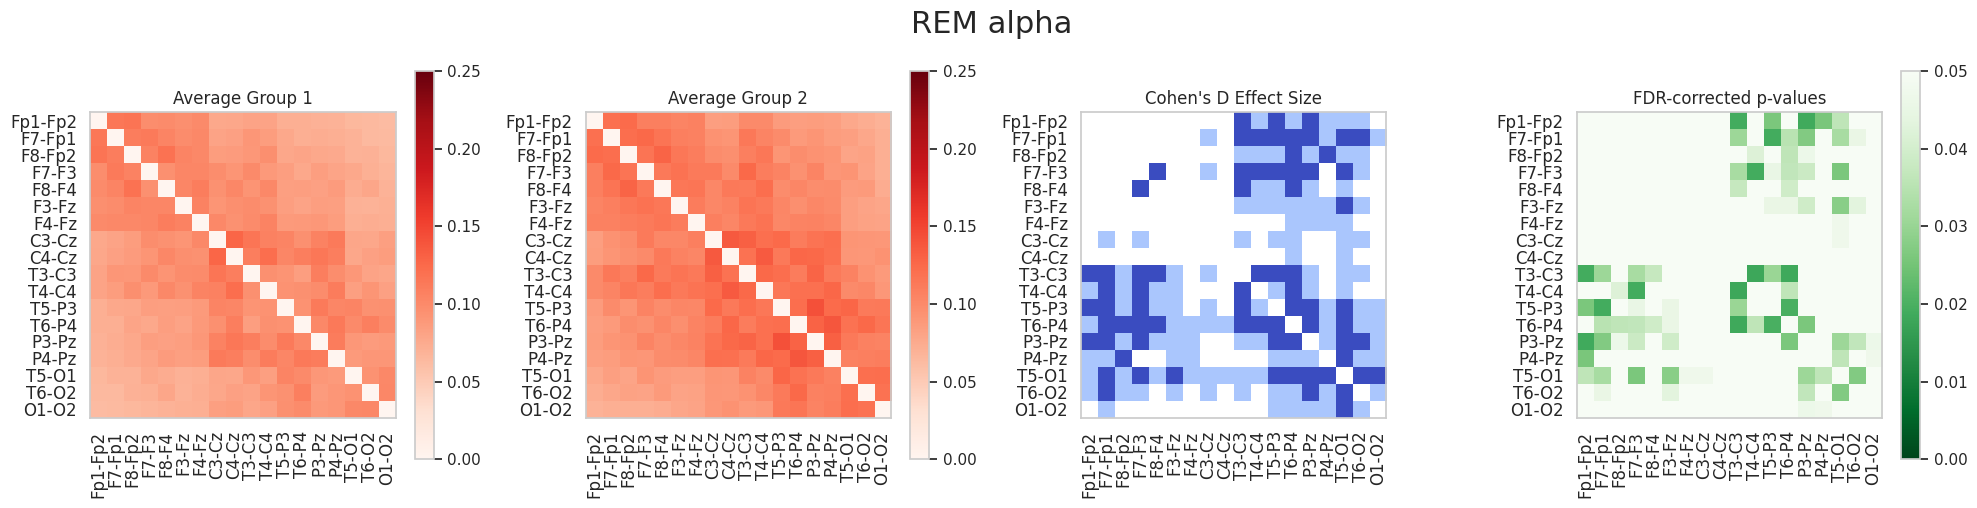

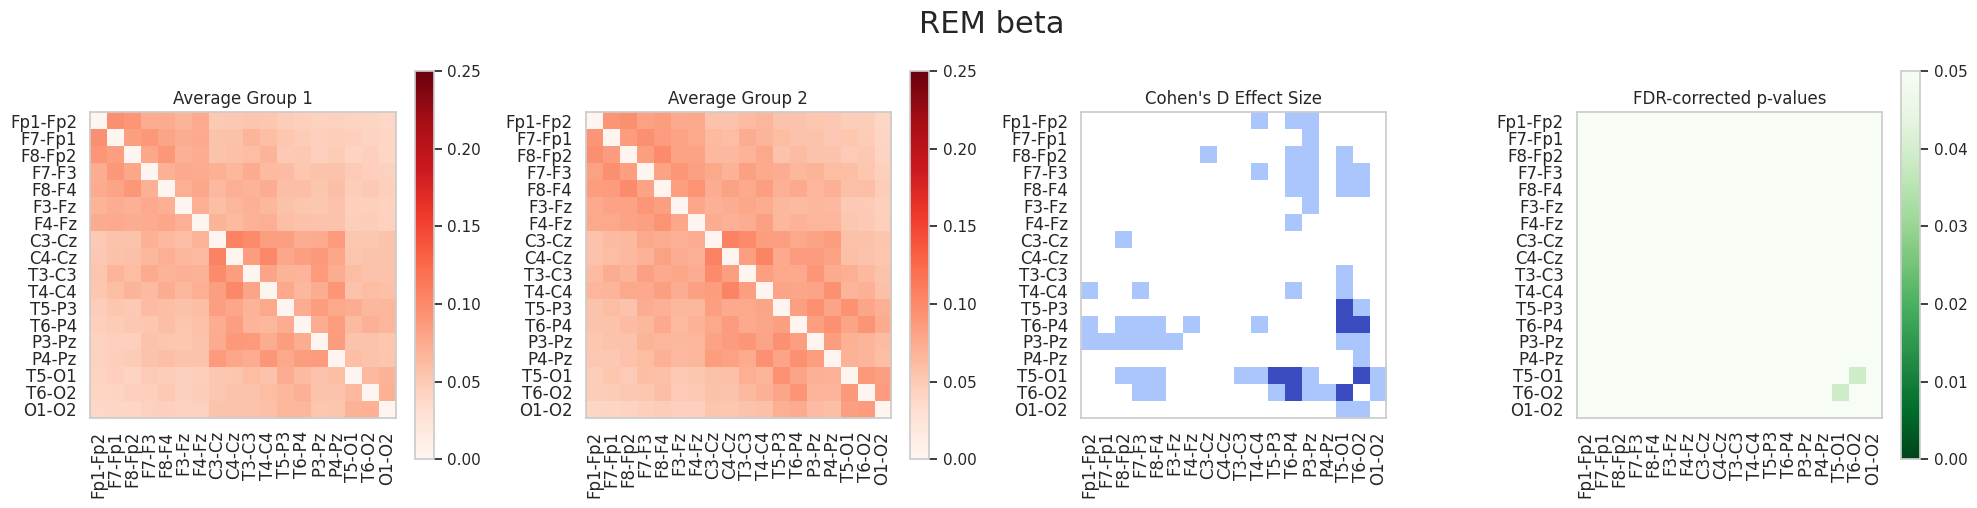

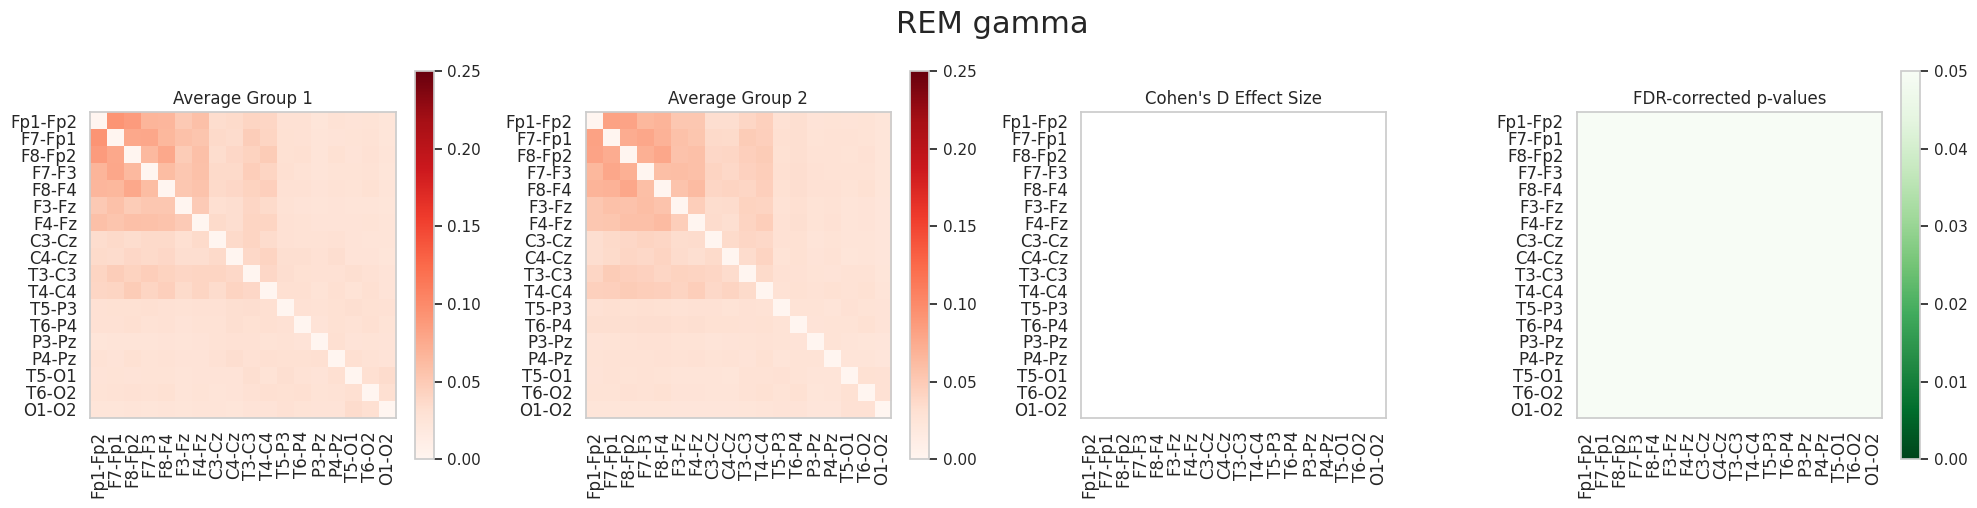

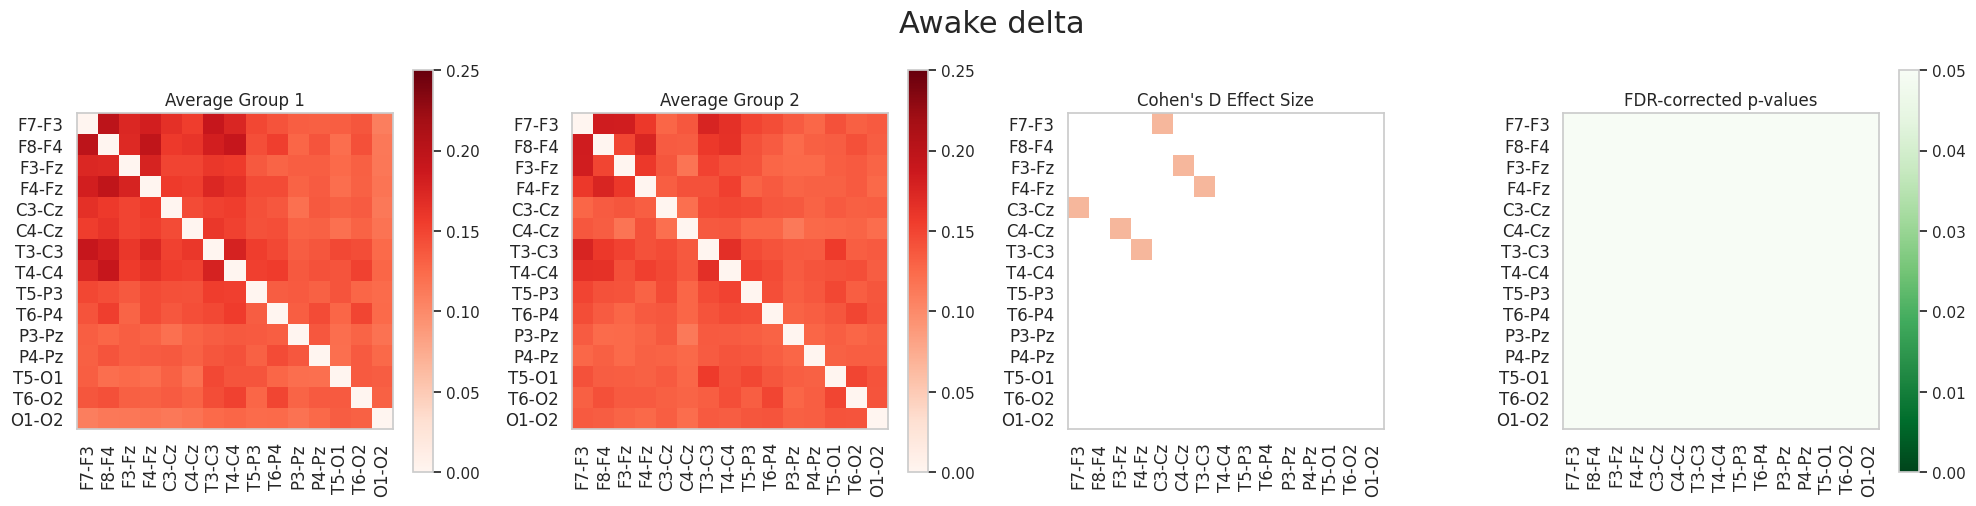

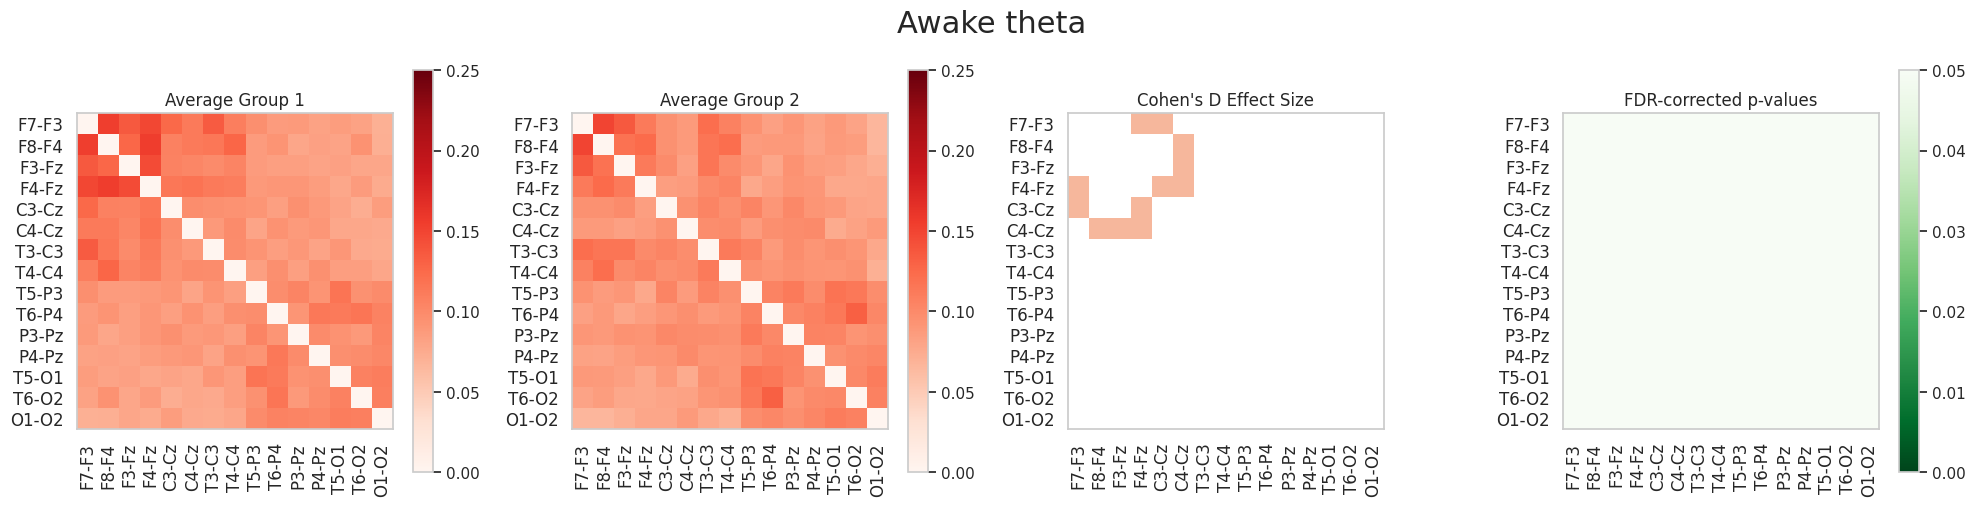

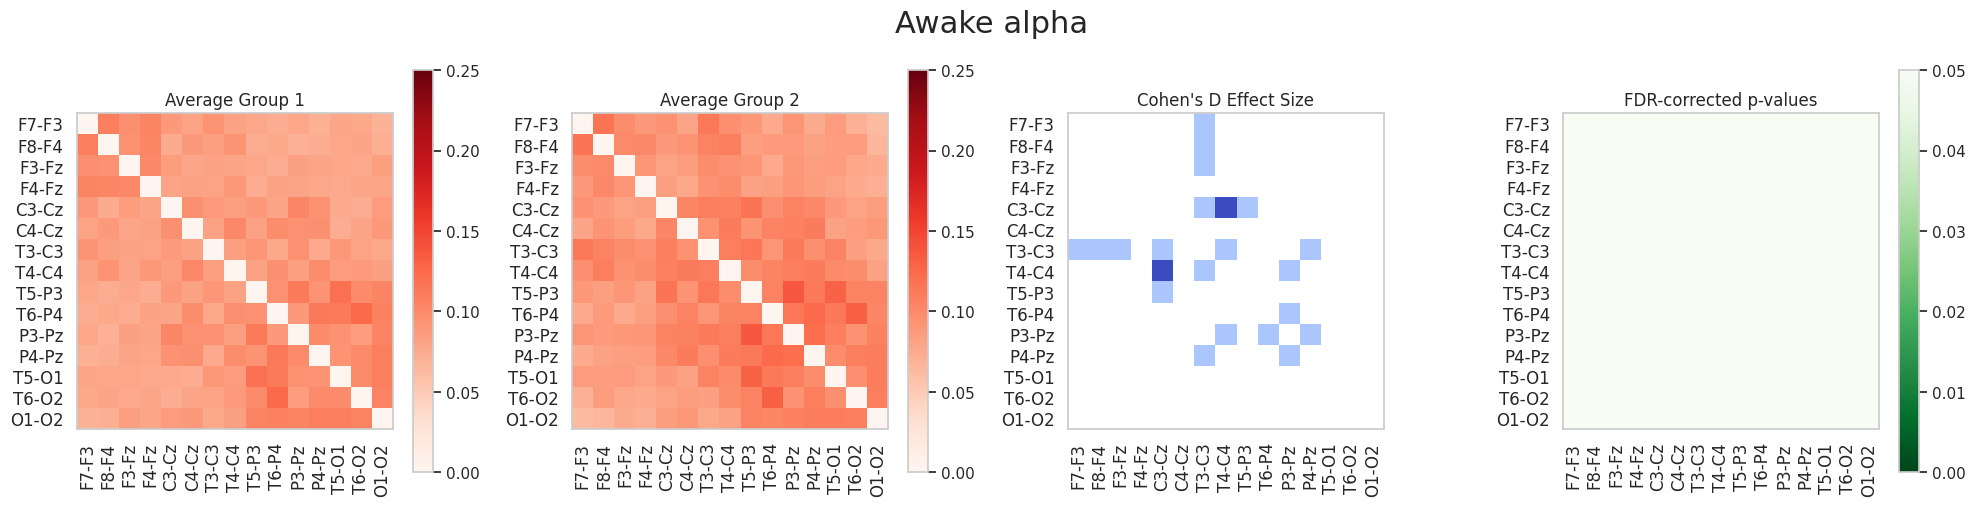

In [ ]:
# Compare AD-NoEp vs HC with the AD-NoEp > HC contrast

# Plot Cohen's d matrices with significant p-values after FDR correction as asterisks
# The formula for the number of p-values to correct, for example, in upper triangular matrices without diagonals would be "n*(n-1)/2 * stages * freq bands", with n as the number of channels
# If we exclude channels from the awake from awake analysis comprising Fp1 and Fp2 (i.e., Fp1-Fp2, F7-Fp1, F8-Fp2),
# corresponding to [0,1,2] rows in the connectivity matrices
# And we exlude the beta and gamma bands from the awake state, the calculation is the following:
# (18*17)/2 * 2 * 5 + (15*14/2) * 1 * 3 = 1530 + 315 = 1845

# Now adding inputs for Cohen's d thresholds
# The matrix entries between -th1 and +th1 will be displayed white

cohens_d_channels_w_pval(adnoep_aec, hc_aec, channels, threshold_1=0.5, threshold_2=0.7, excluded_awake_channels=[0,1,2], excluded_keys=["4_beta", "4_gamma"])

Number of channel-wise p-values to correct = 1845



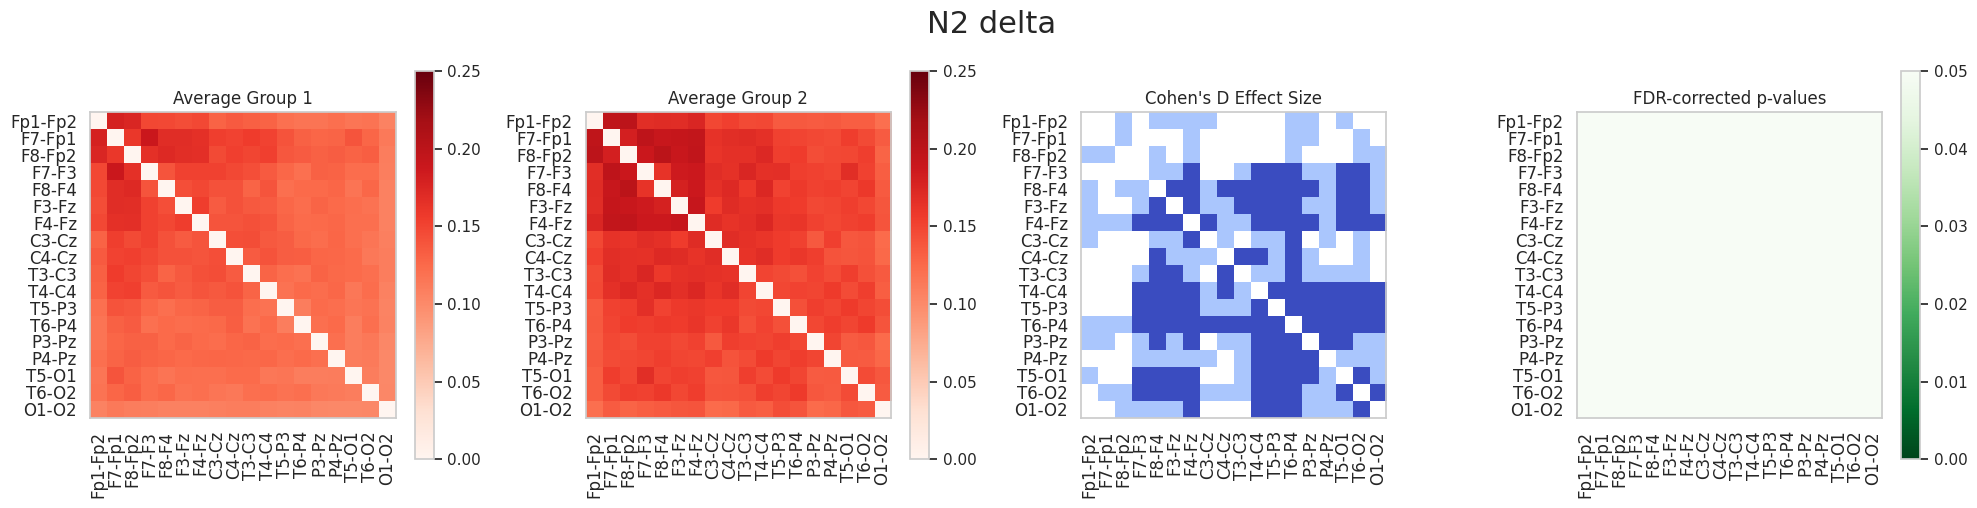

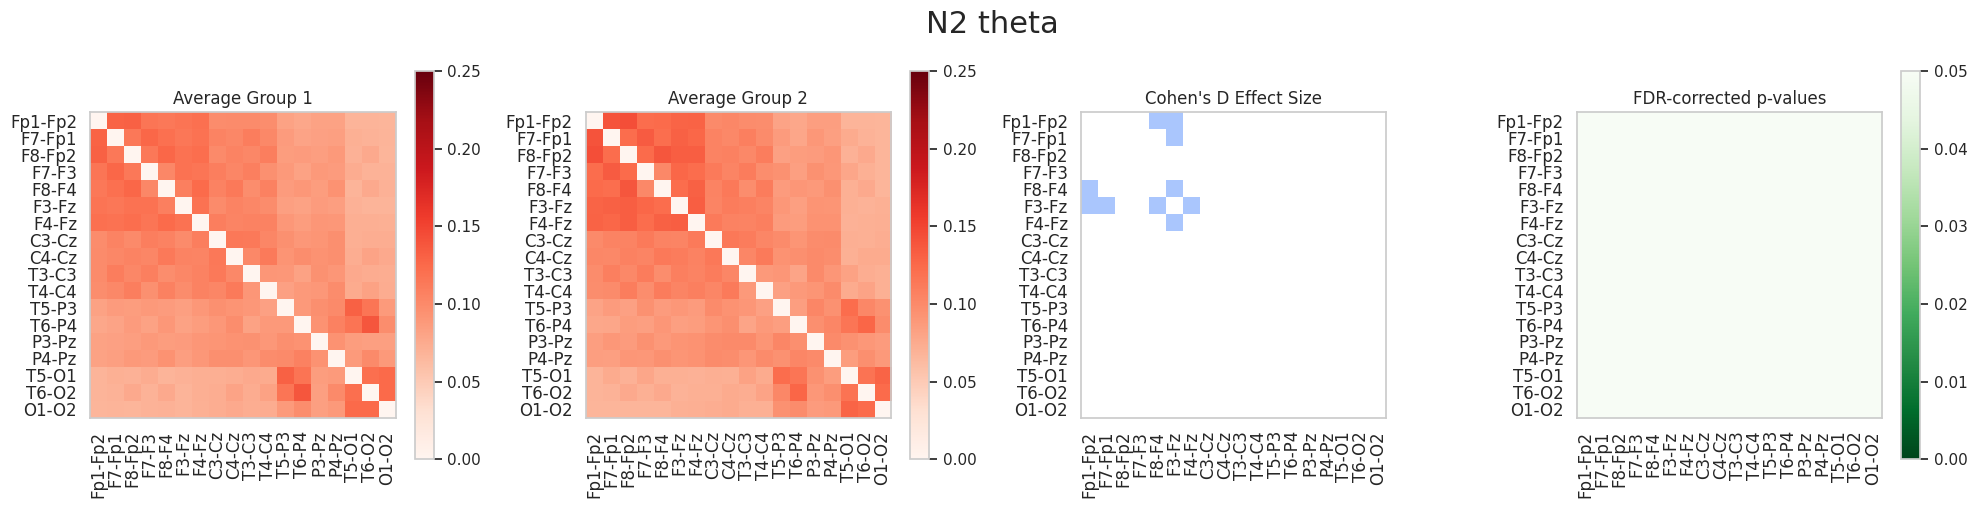

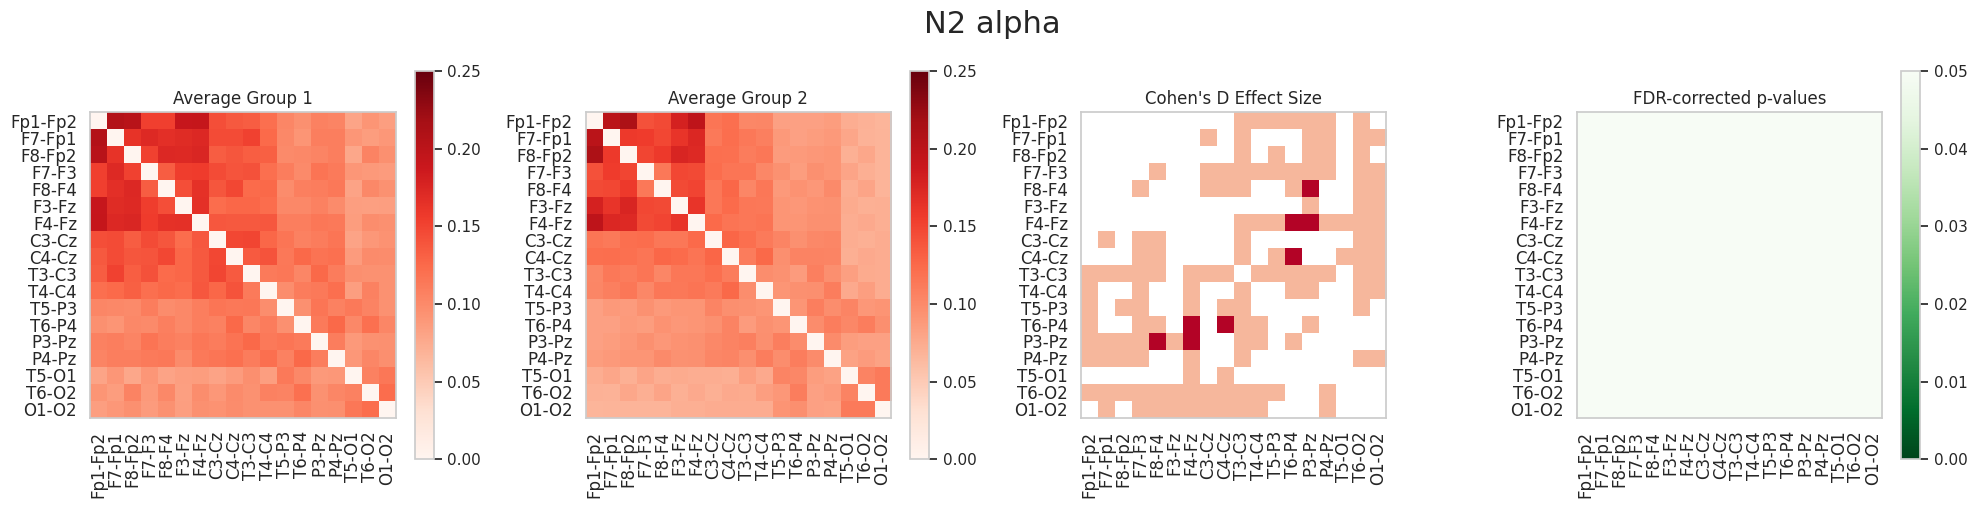

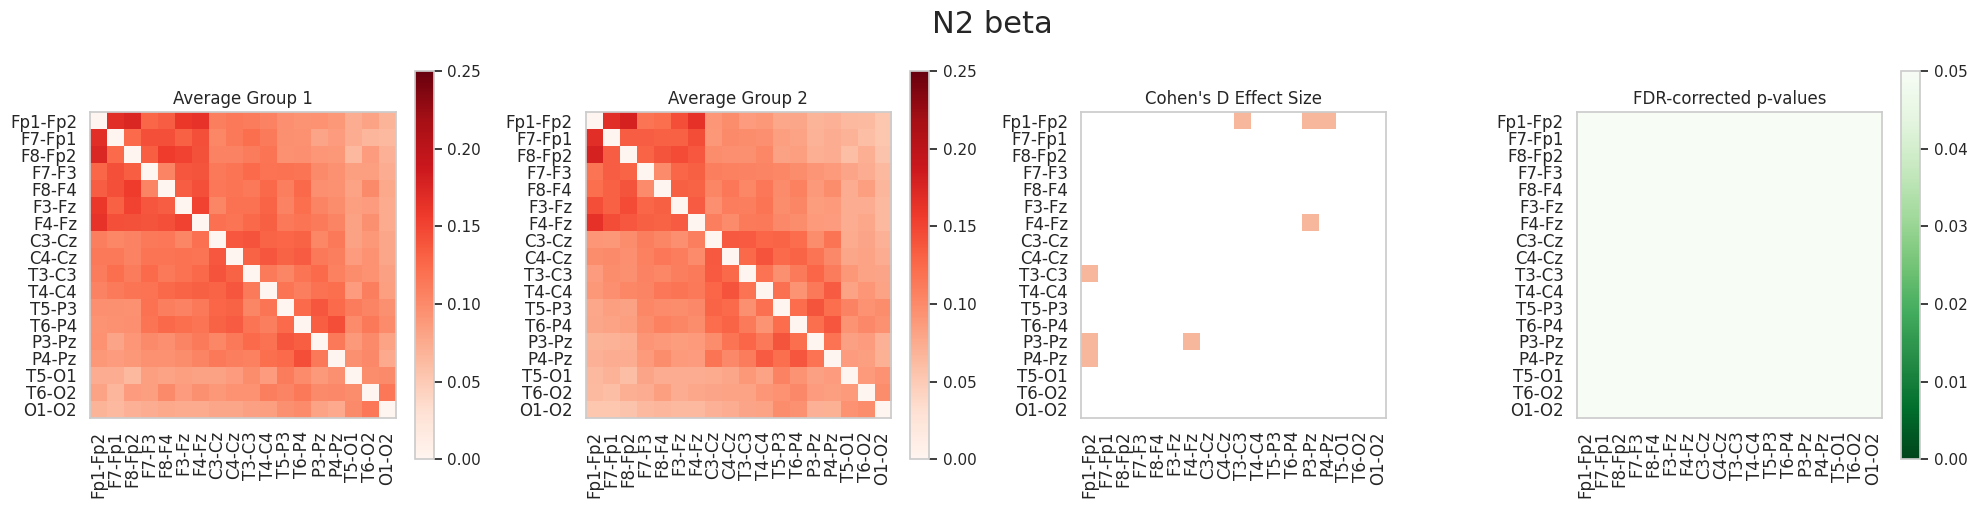

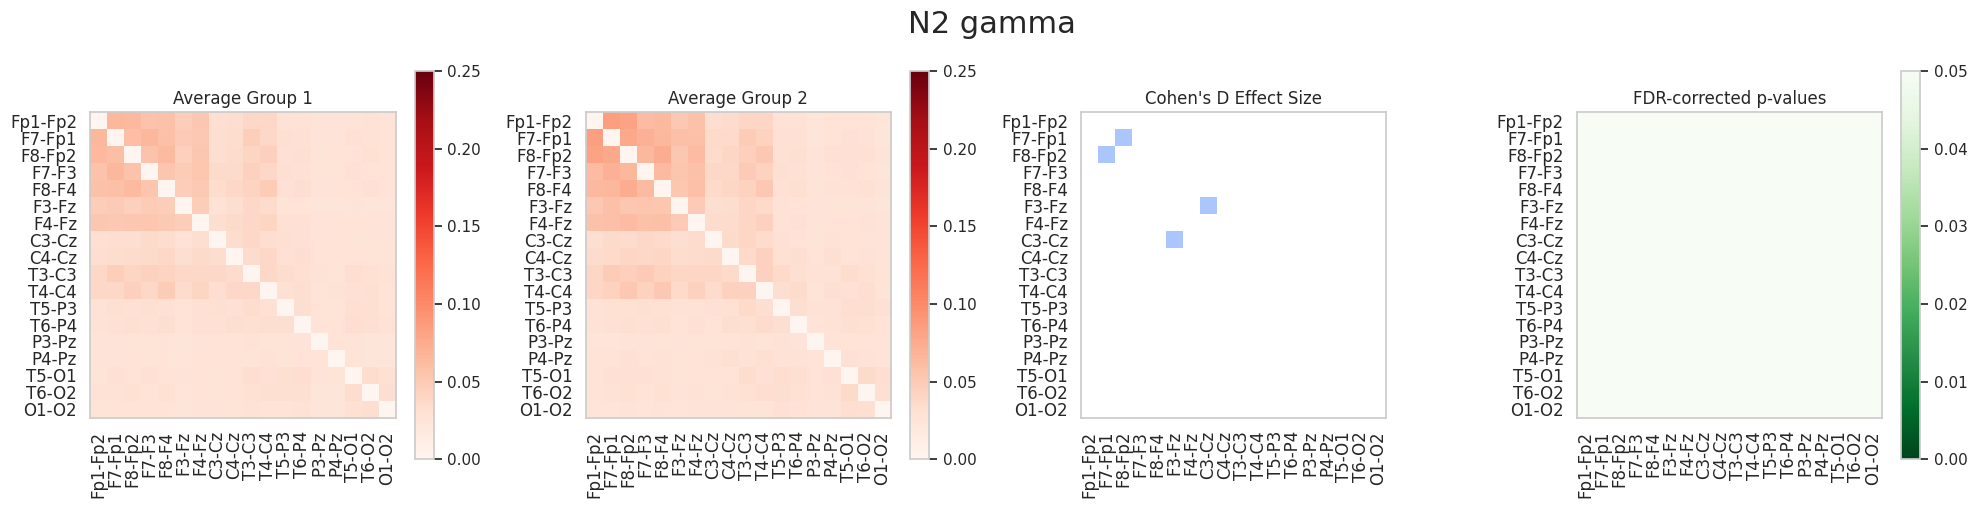

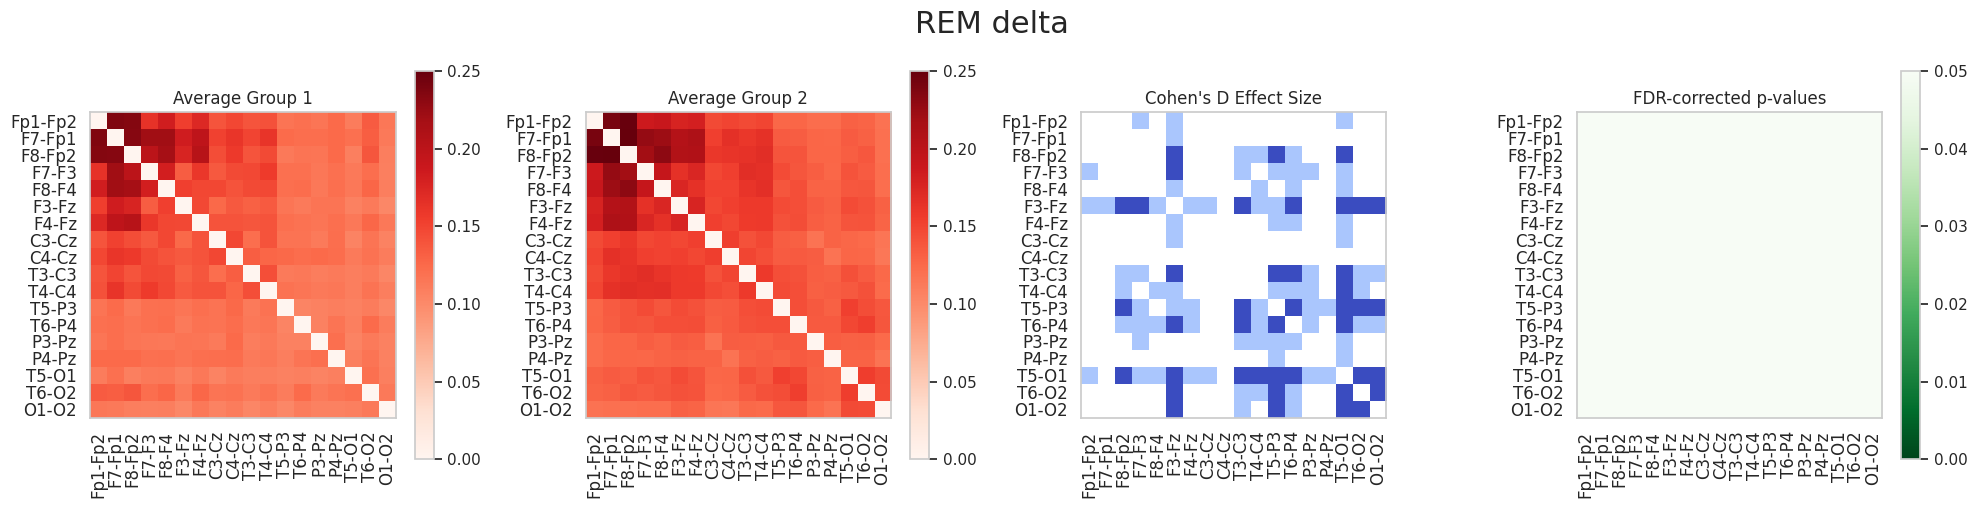

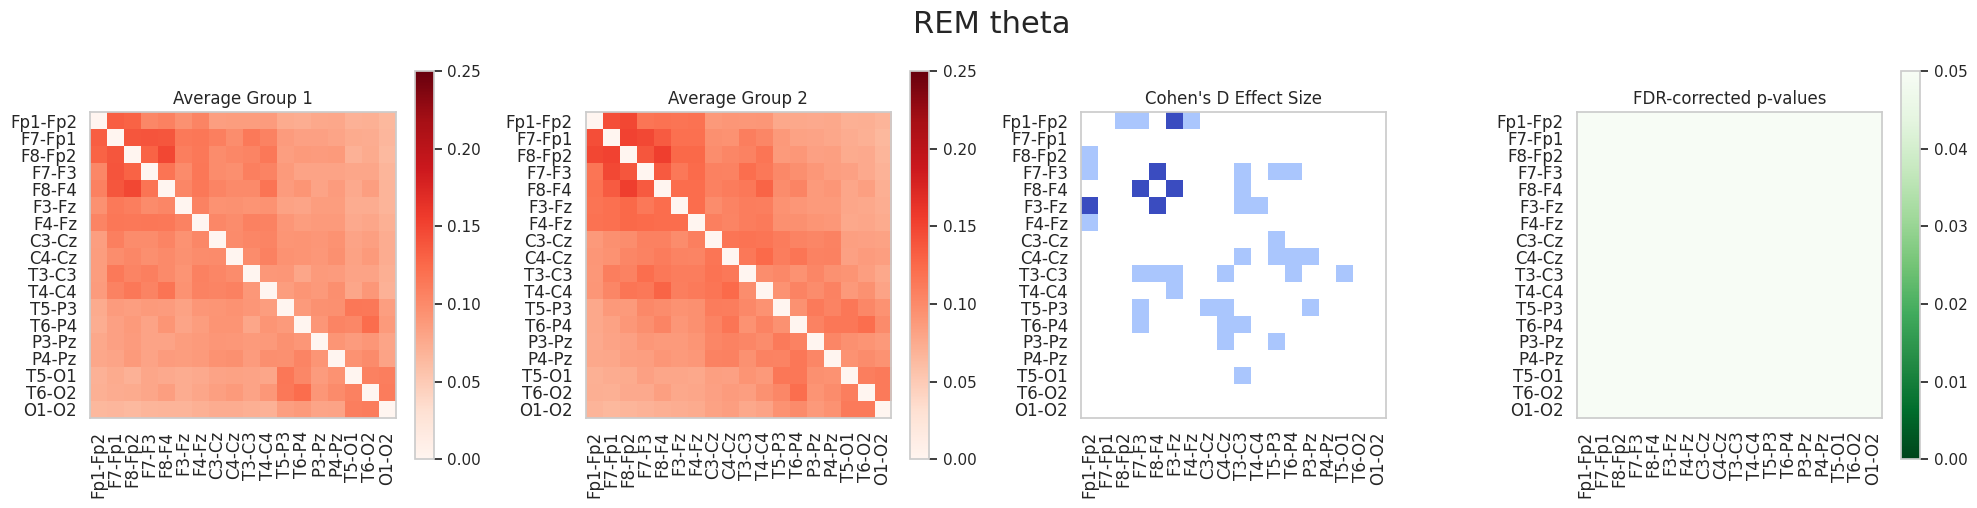

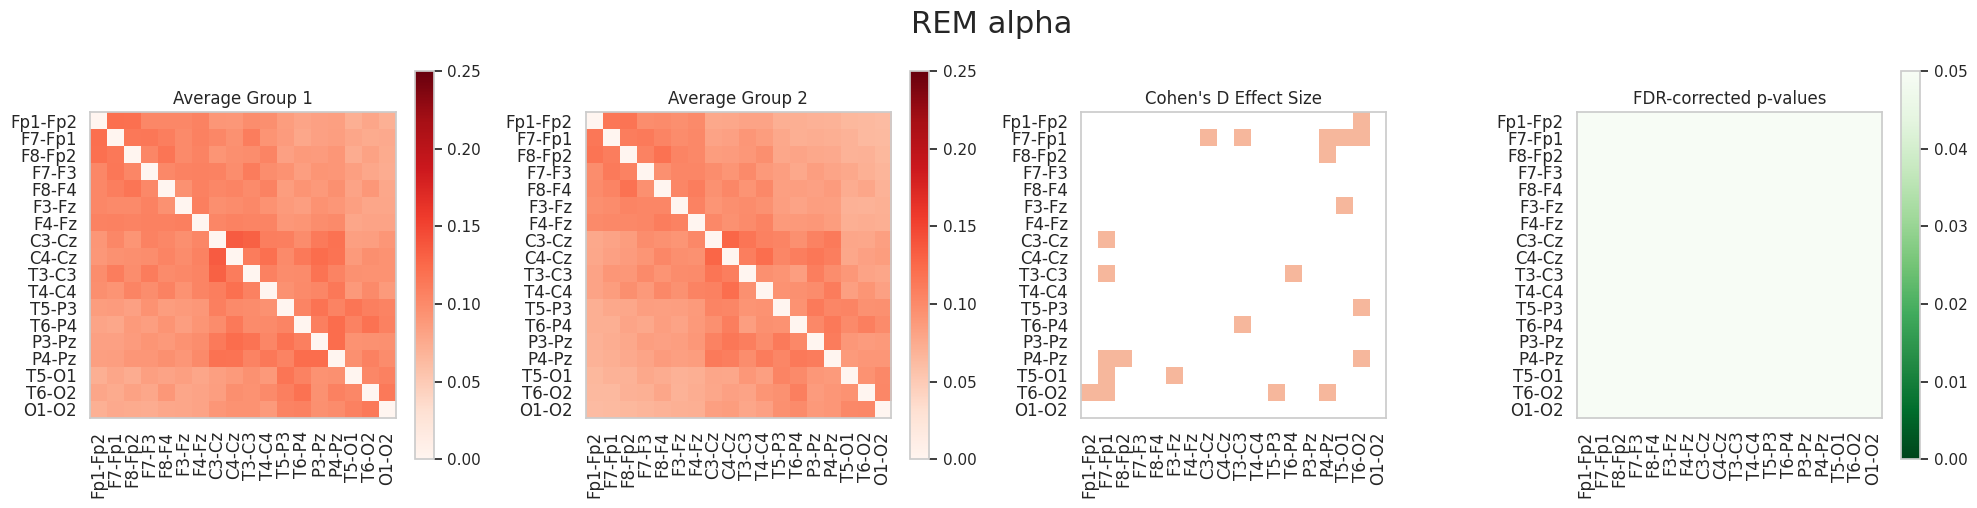

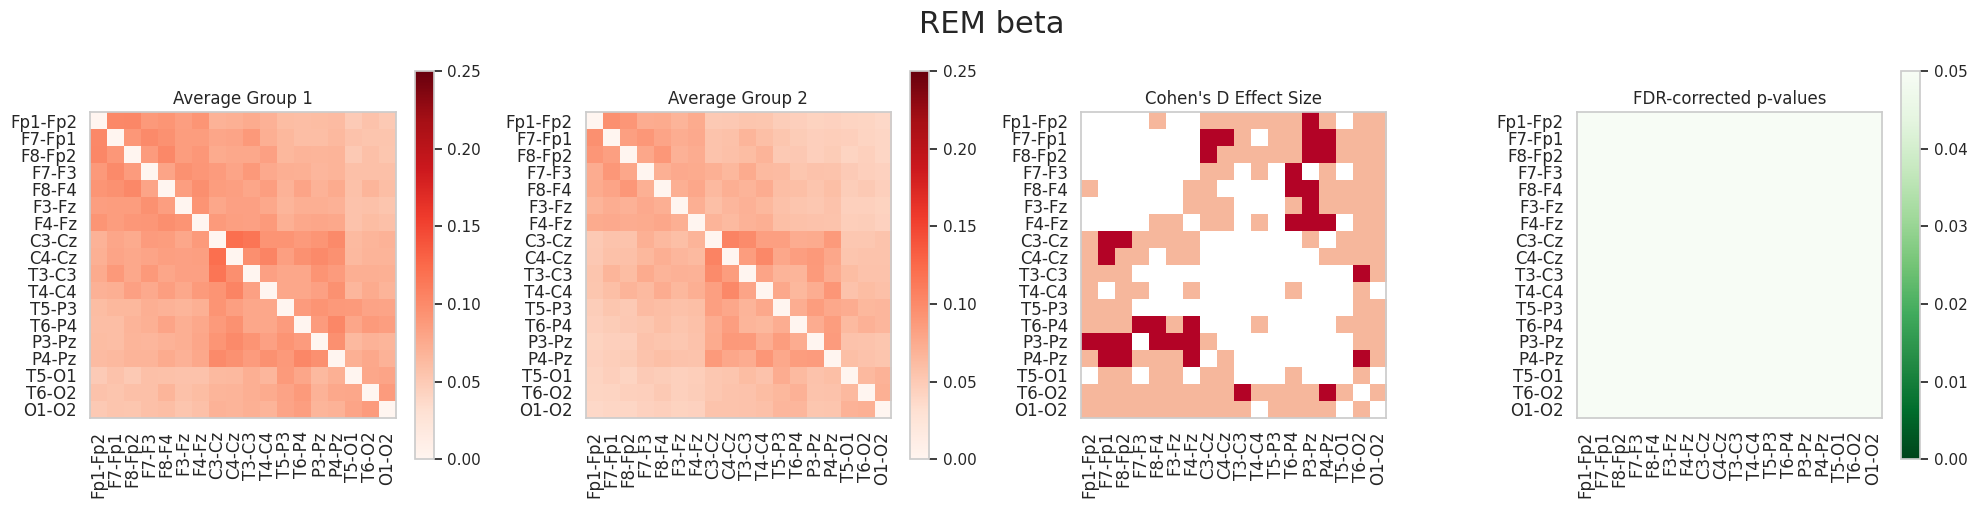

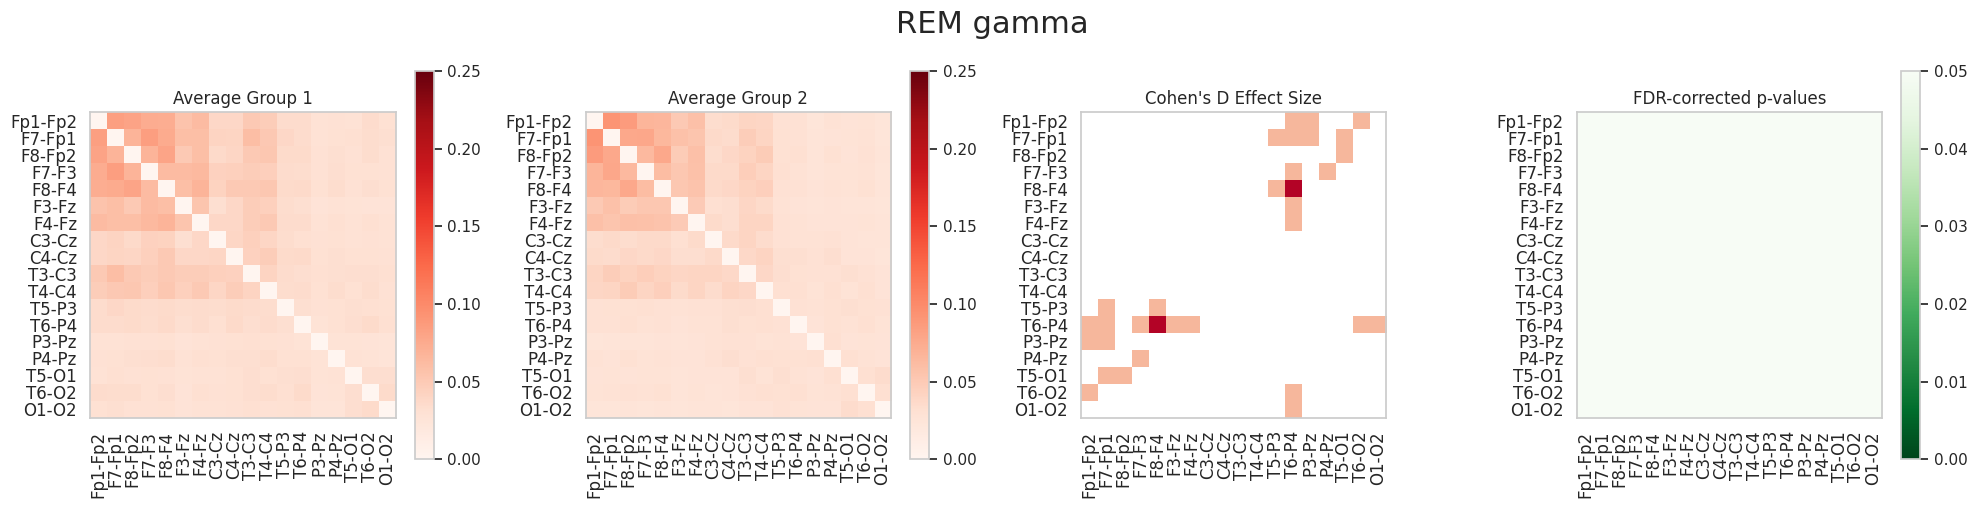

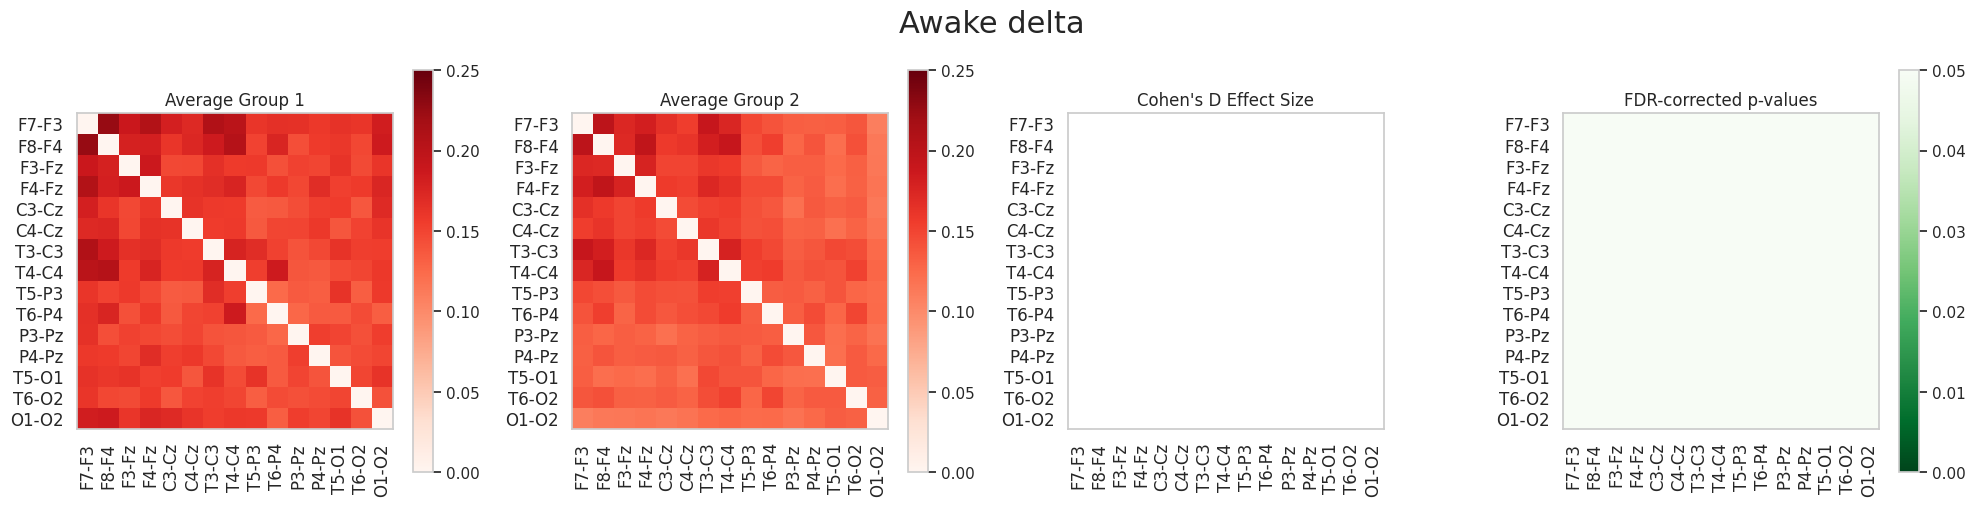

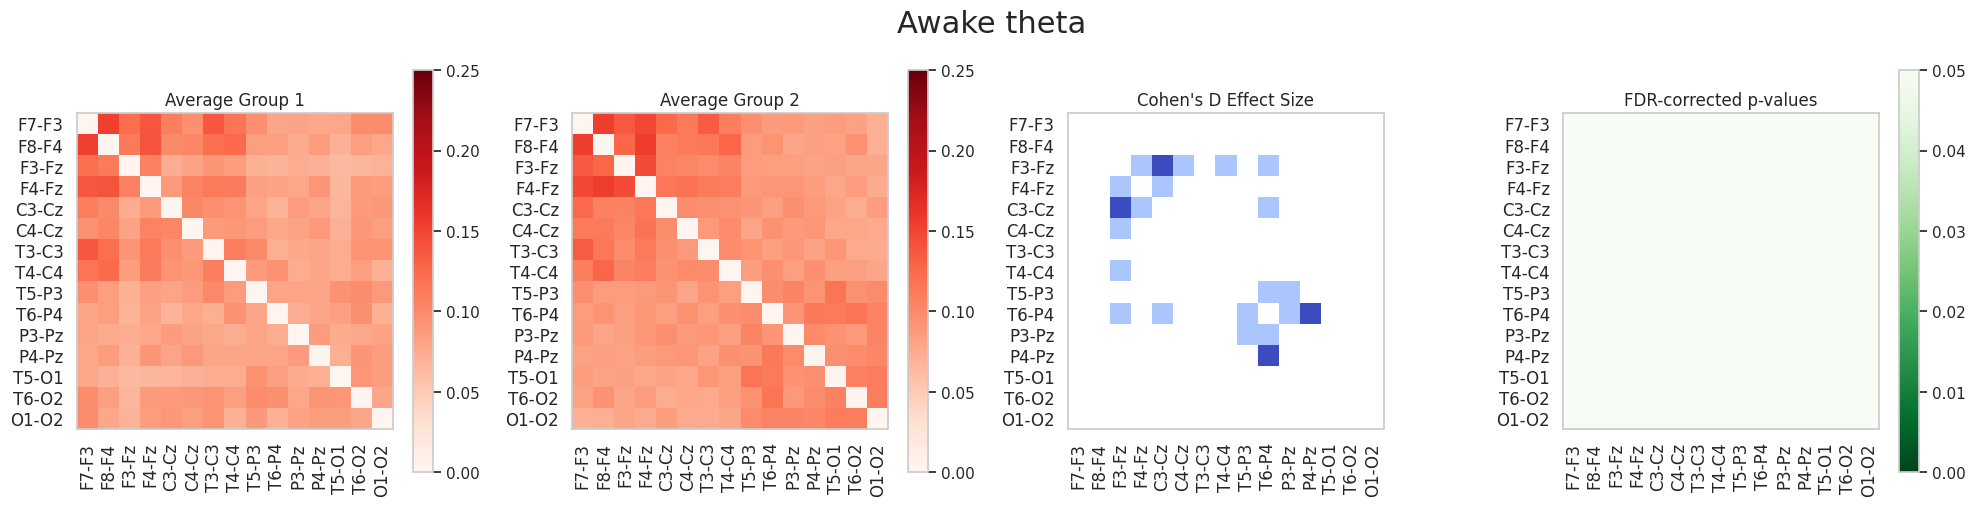

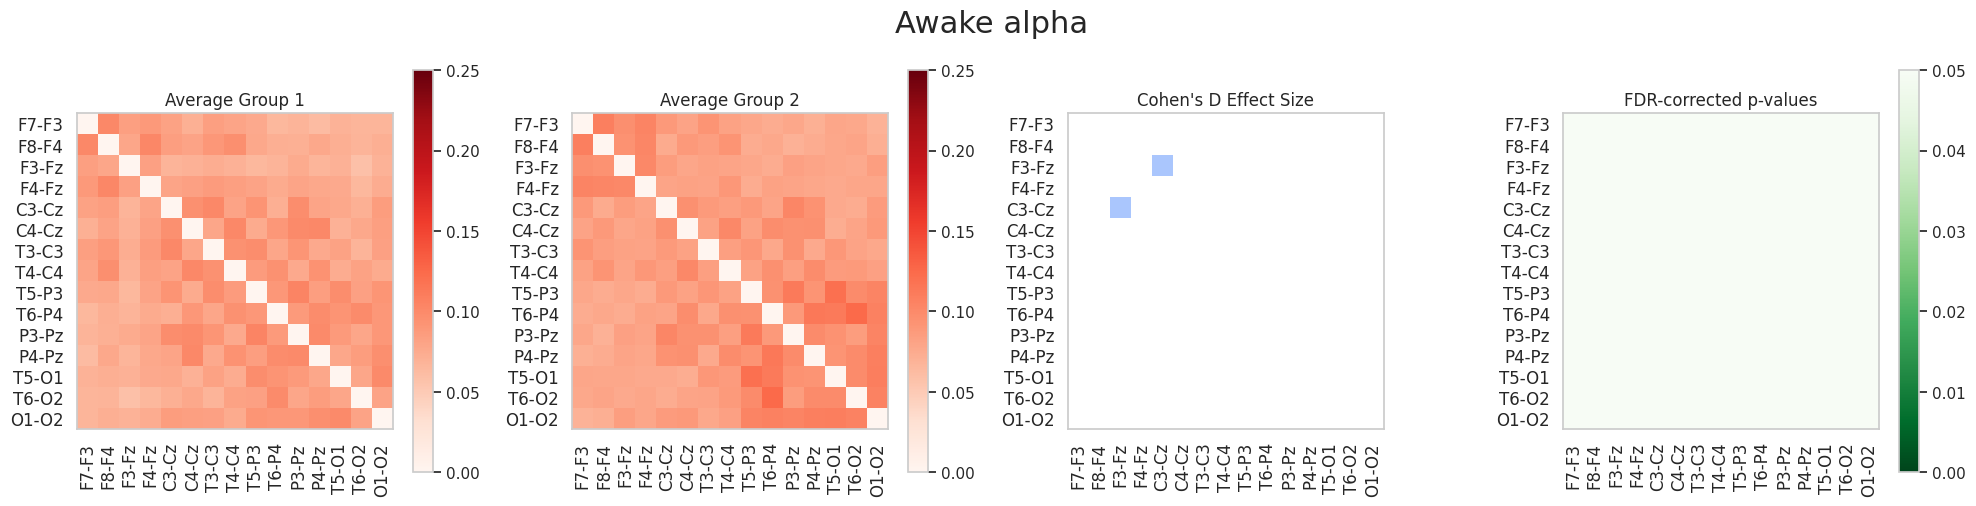

In [ ]:
# Compare AD-Ep vs AD-NoEp with the AD-Ep > AD-NoEp contrast
cohens_d_channels_w_pval(adep_aec, adnoep_aec, channels, threshold_1=0.5, threshold_2=0.7, excluded_awake_channels=[0,1,2], excluded_keys=["4_beta", "4_gamma"])

Number of channel-wise p-values to correct = 1845



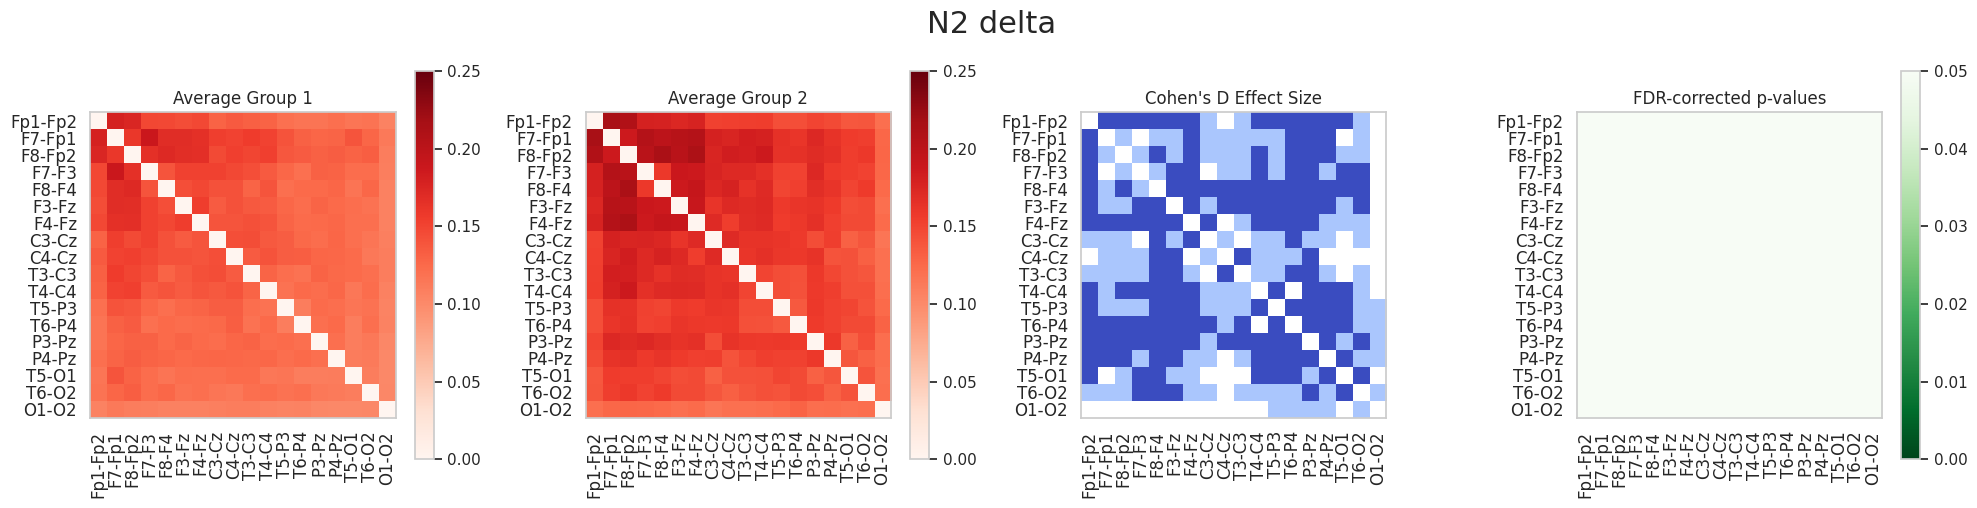

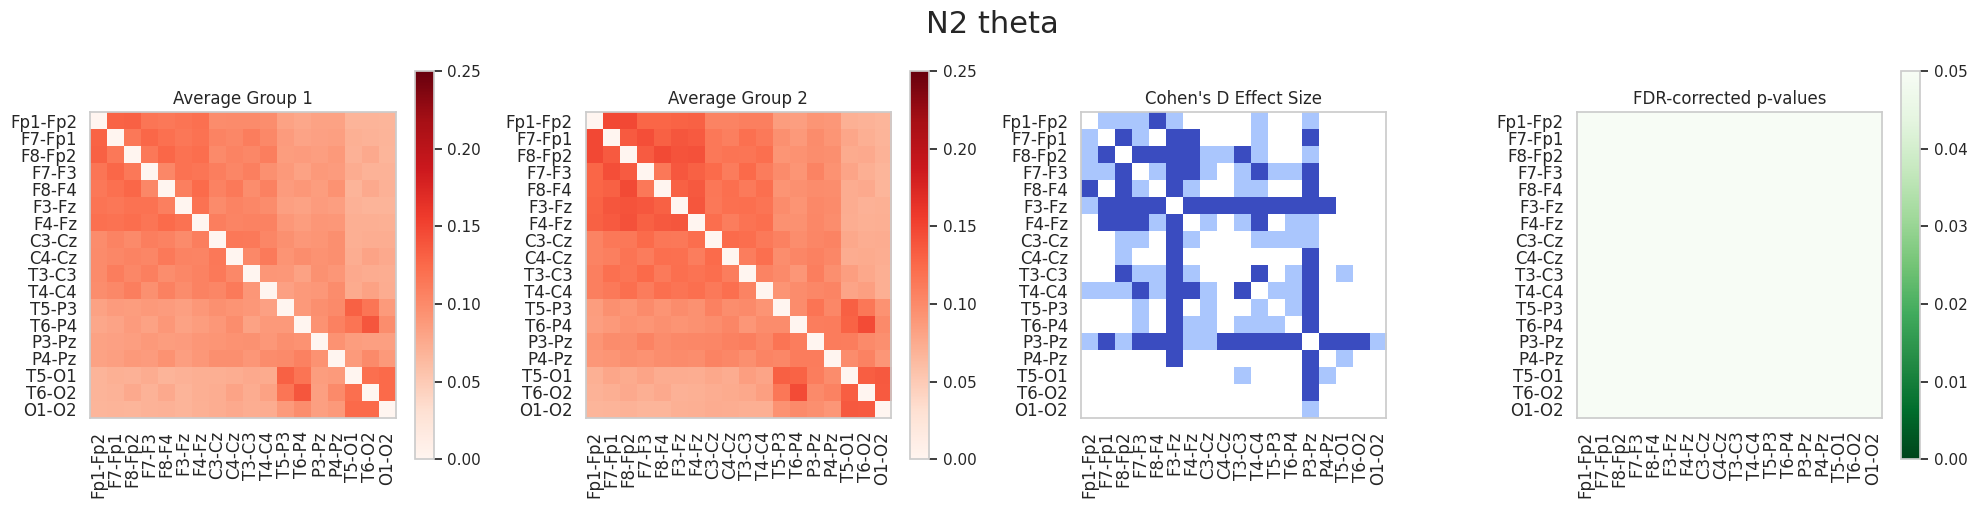

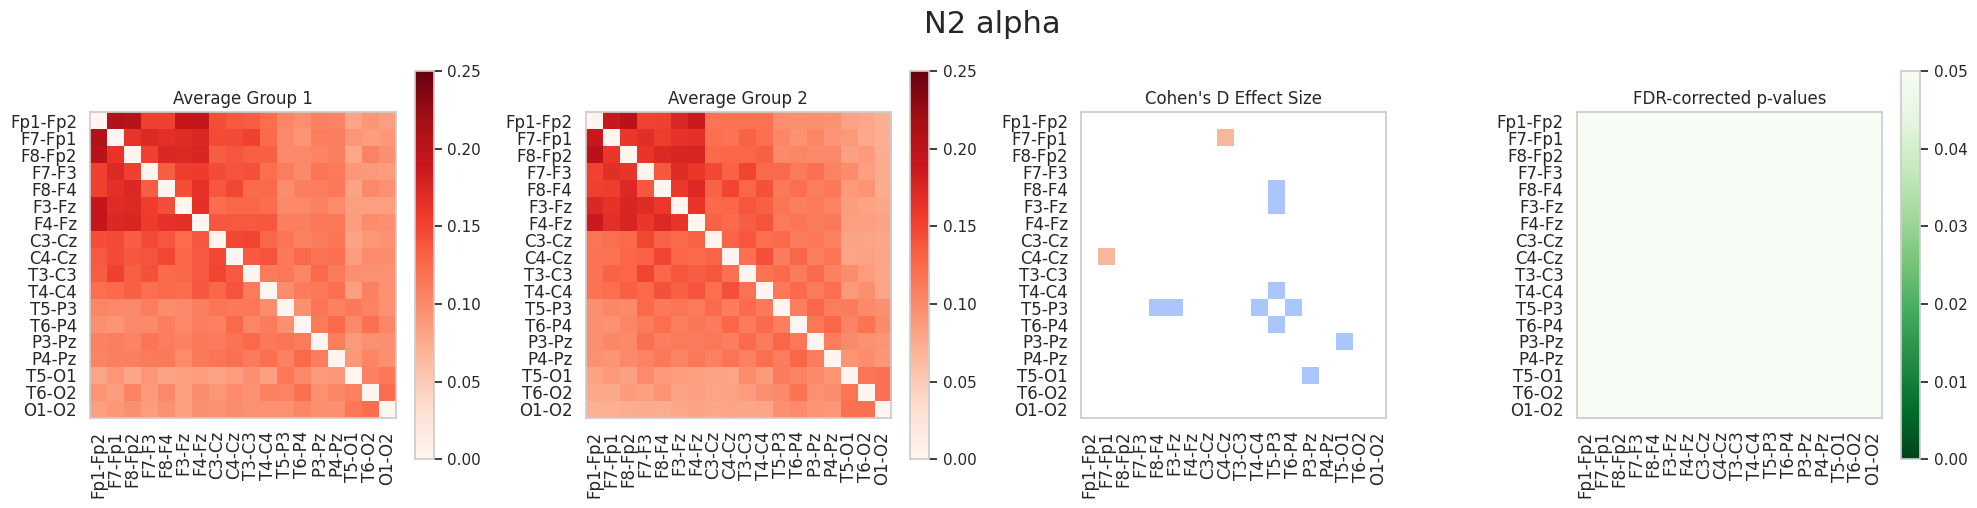

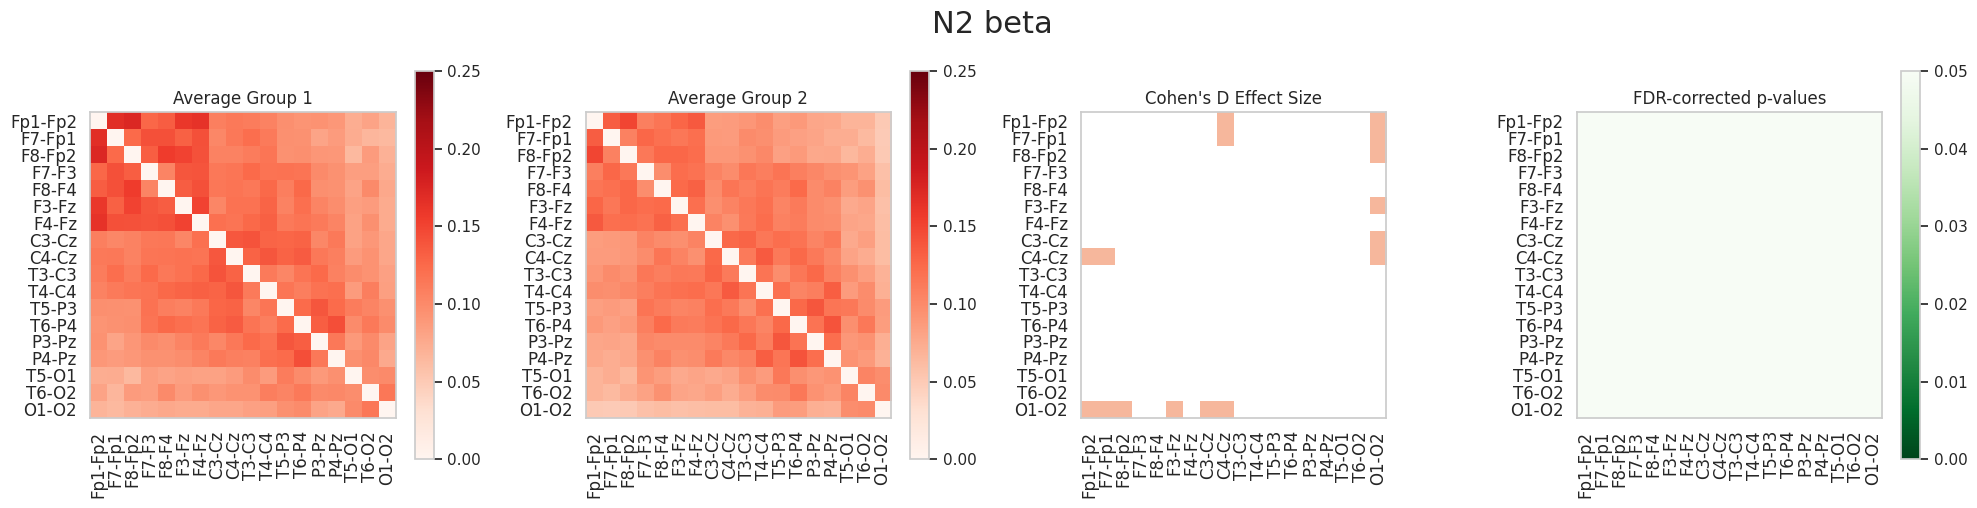

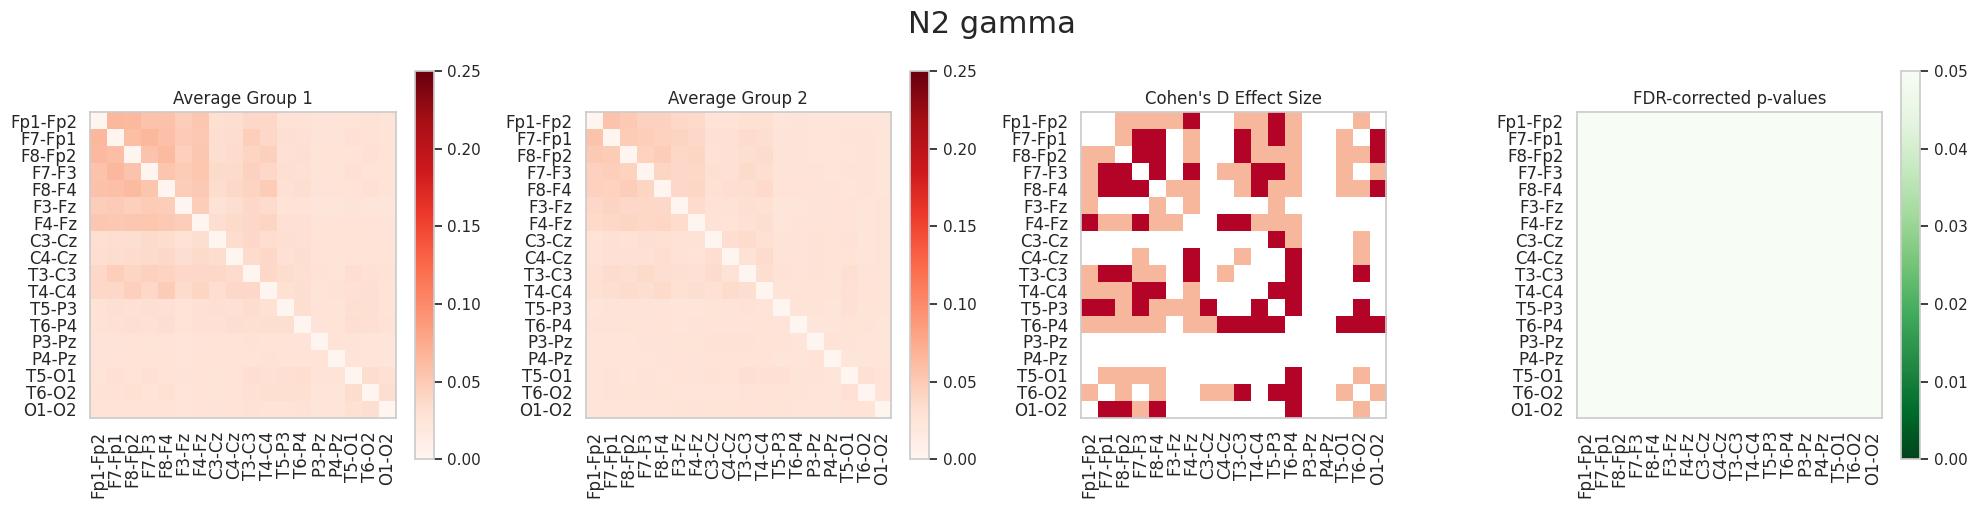

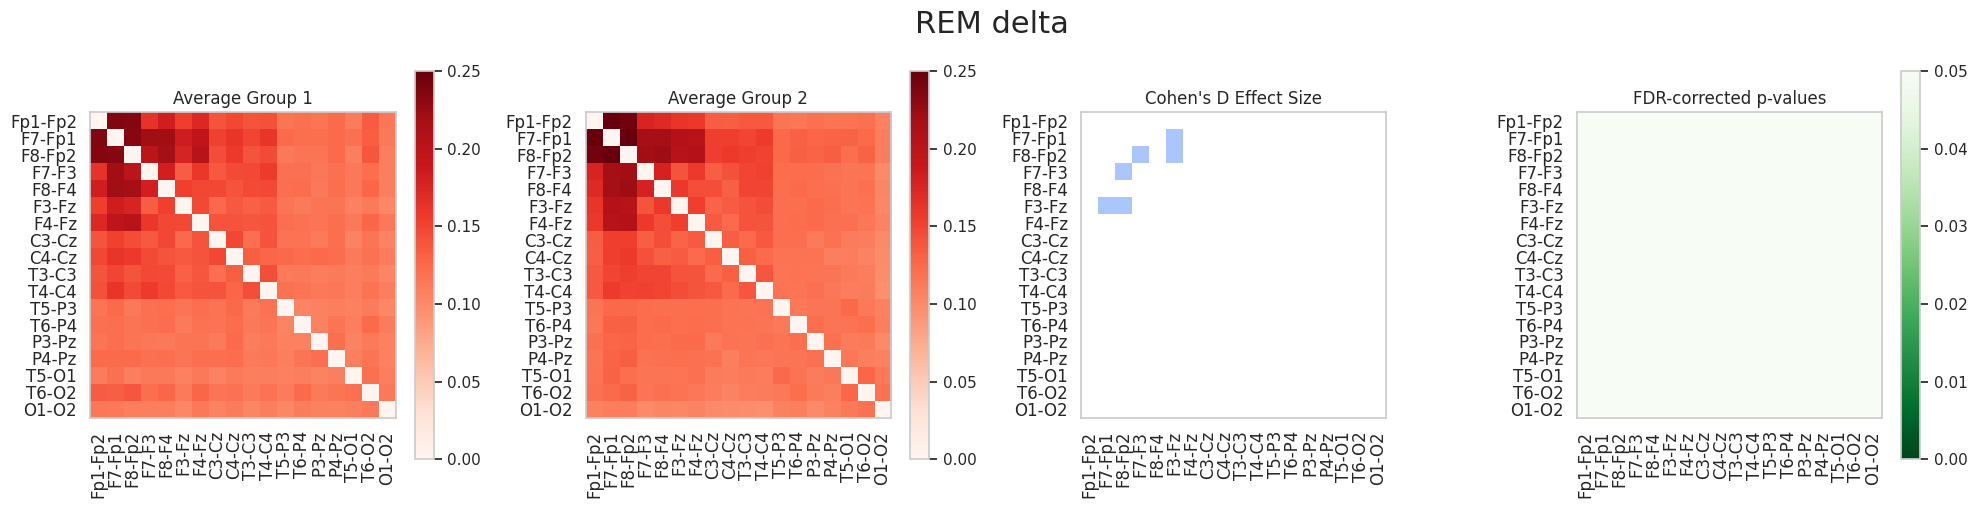

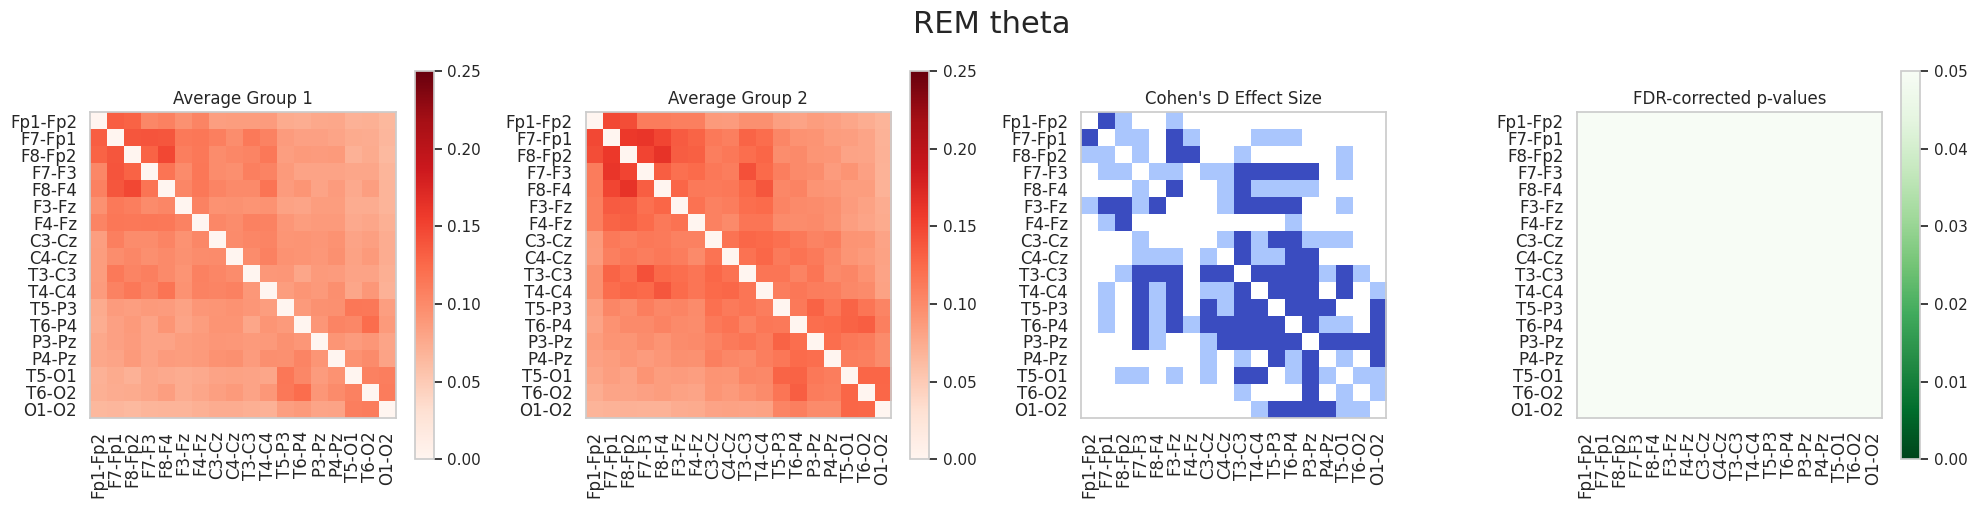

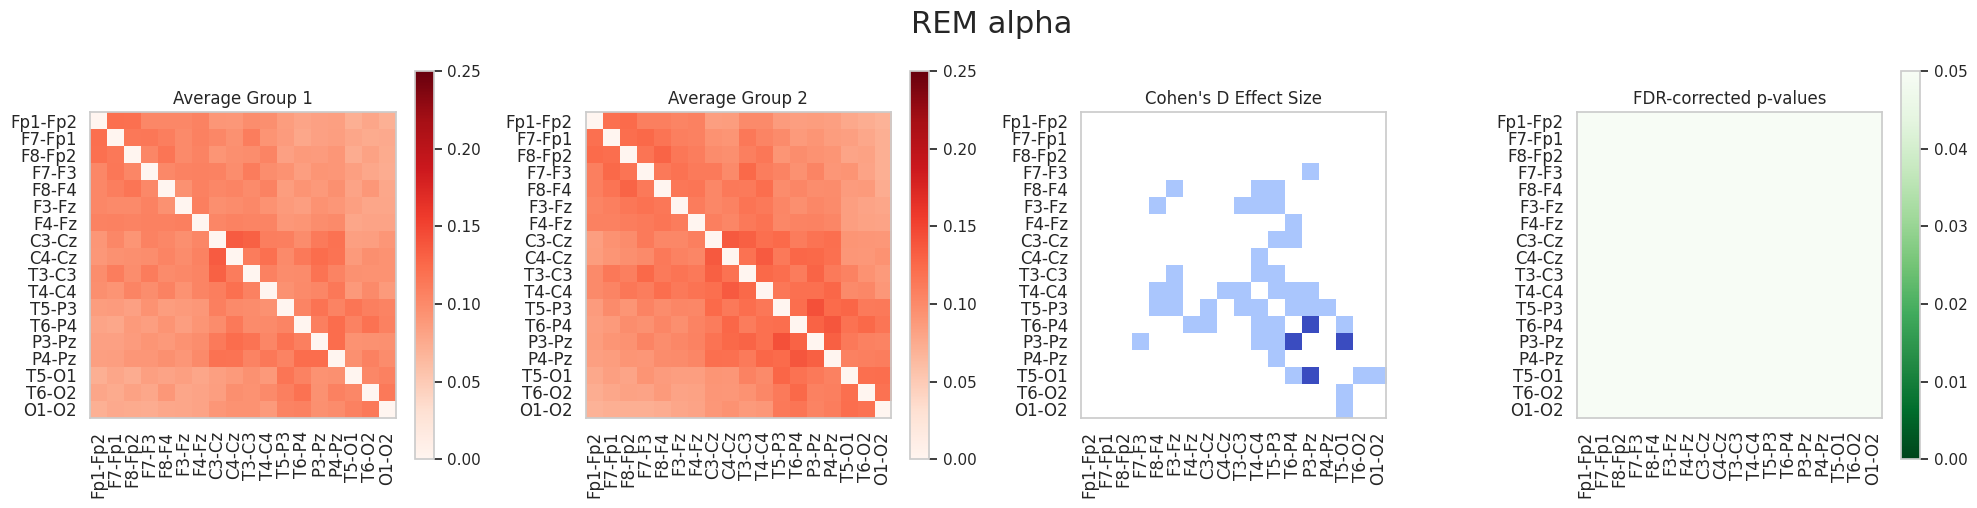

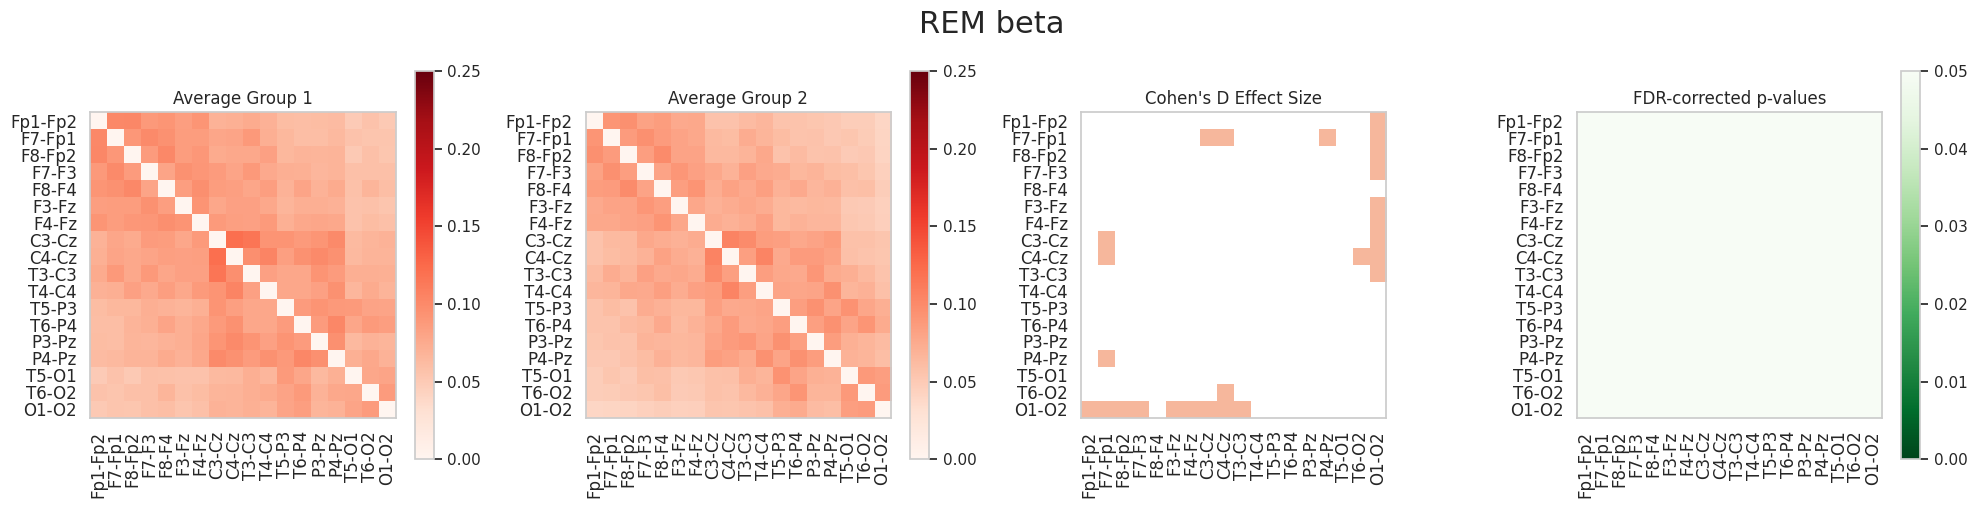

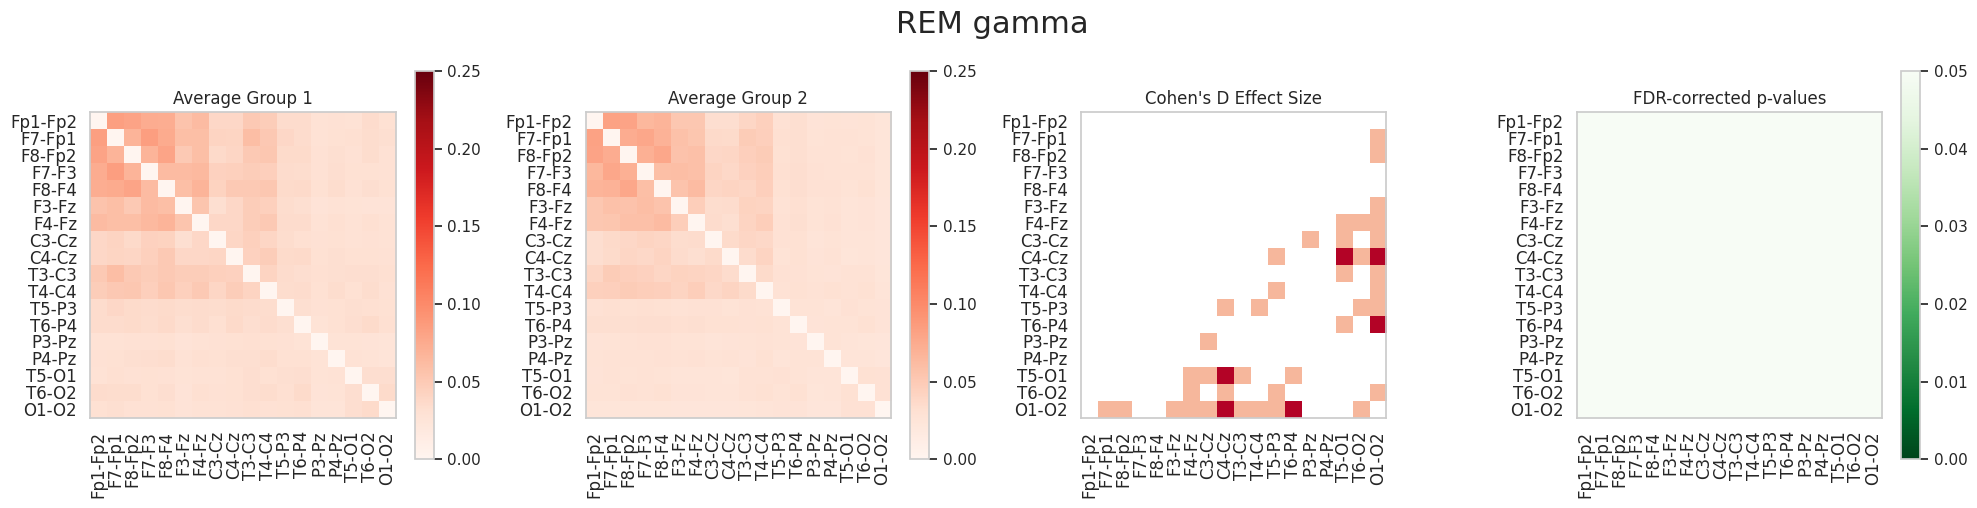

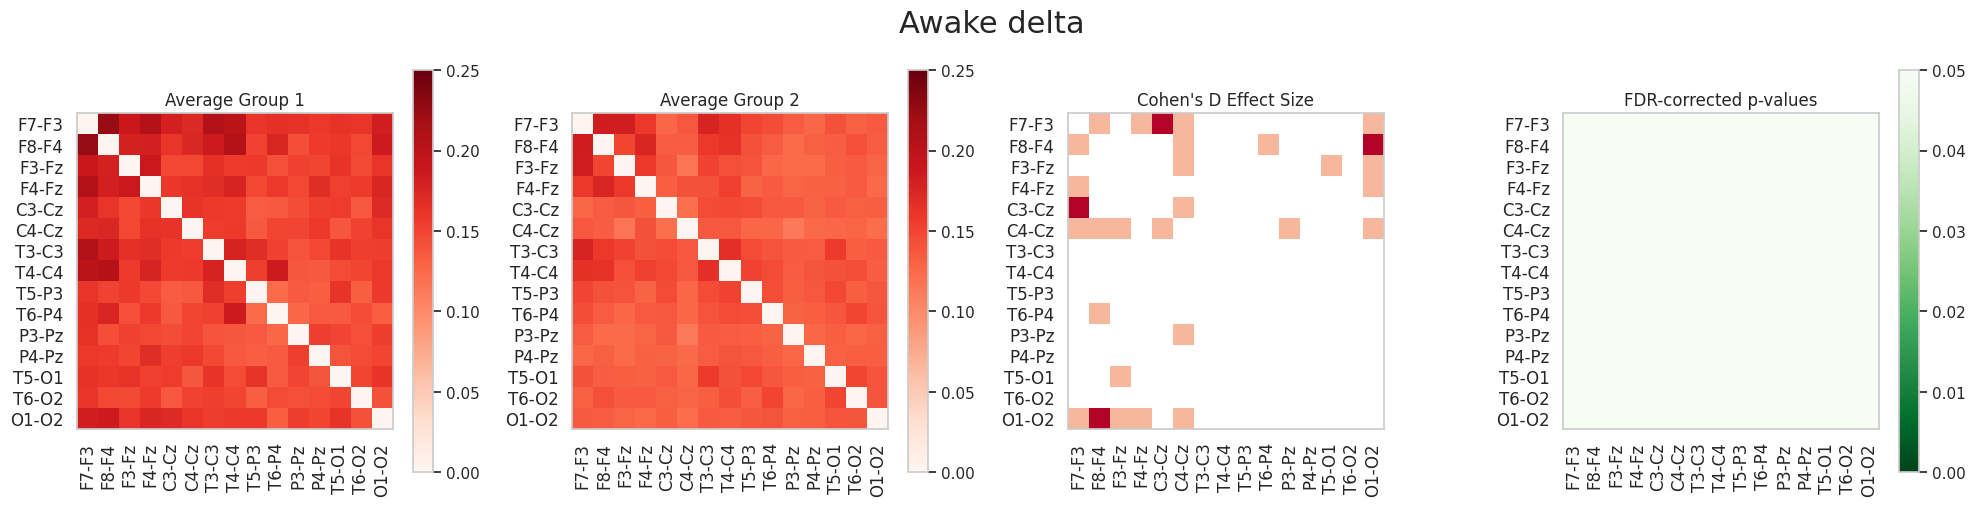

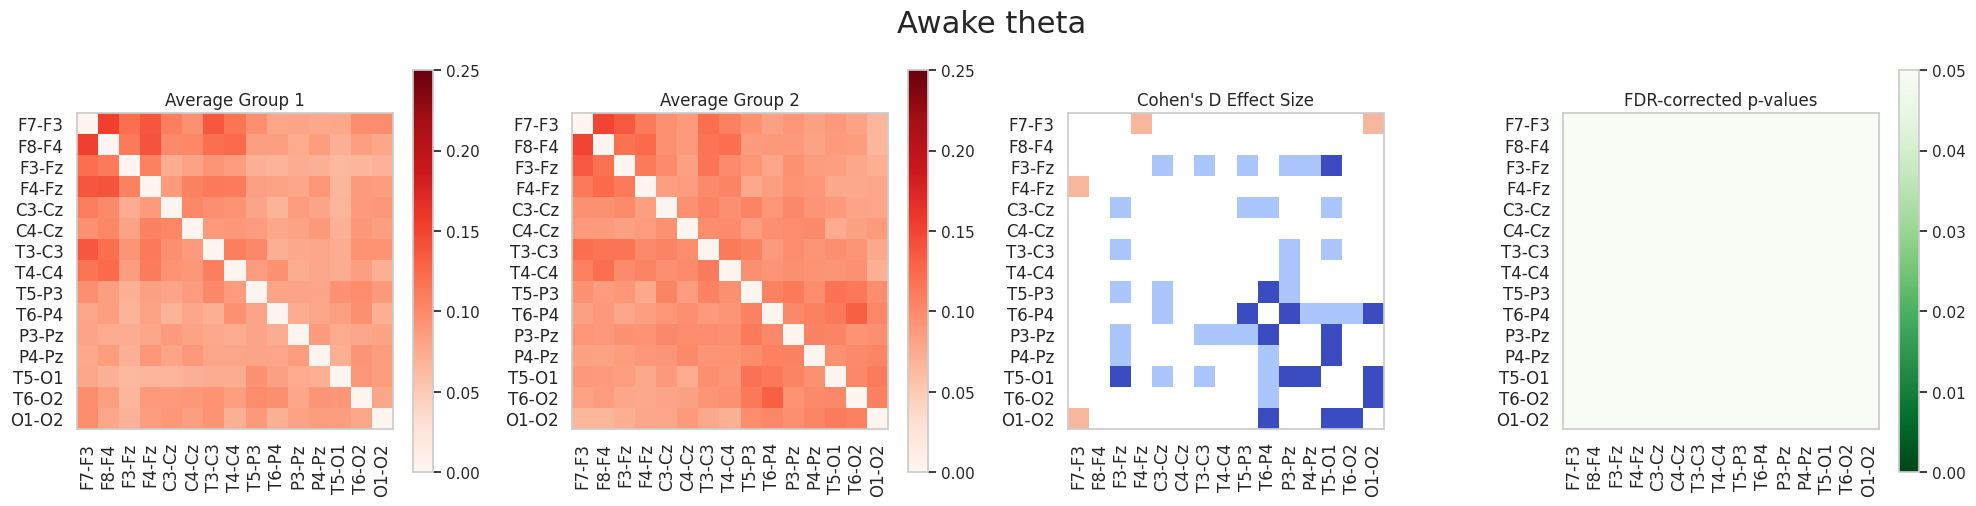

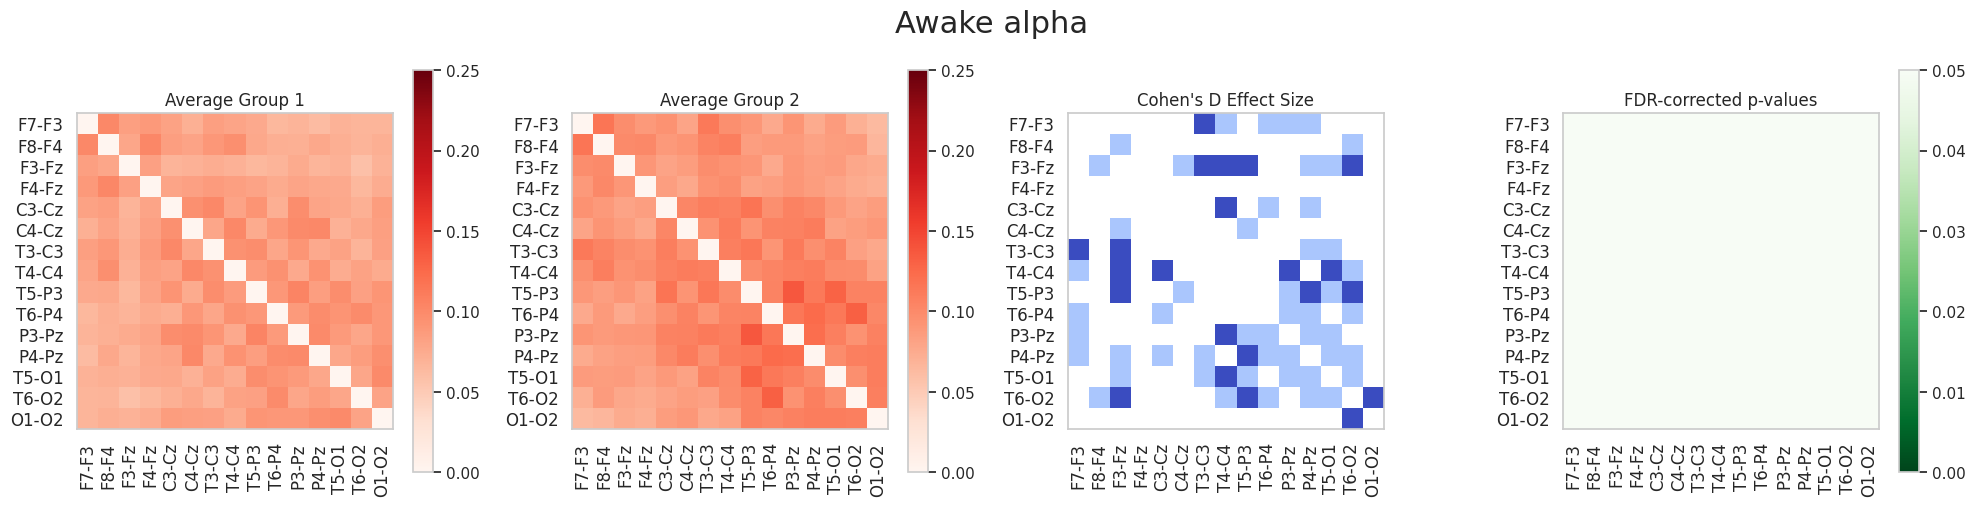

In [ ]:
# Compare AD-Ep vs HC with the AD-Ep > HC contrast
cohens_d_channels_w_pval(adep_aec, hc_aec, channels, threshold_1=0.5, threshold_2=0.7, excluded_awake_channels=[0,1,2], excluded_keys=["4_beta", "4_gamma"])

In [ ]:
# Get the 'ImCoh' matrices for all groups from the "metrics" data structure
adnoep_coh = {key: val['ADNoEp']['ImCoh'] for key, val in metrics.items()}
adep_coh = {key: val['ADEp']['ImCoh'] for key, val in metrics.items()}
hc_coh = {key: val['HC']['ImCoh'] for key, val in metrics.items()}

Number of channel-wise p-values to correct = 1845



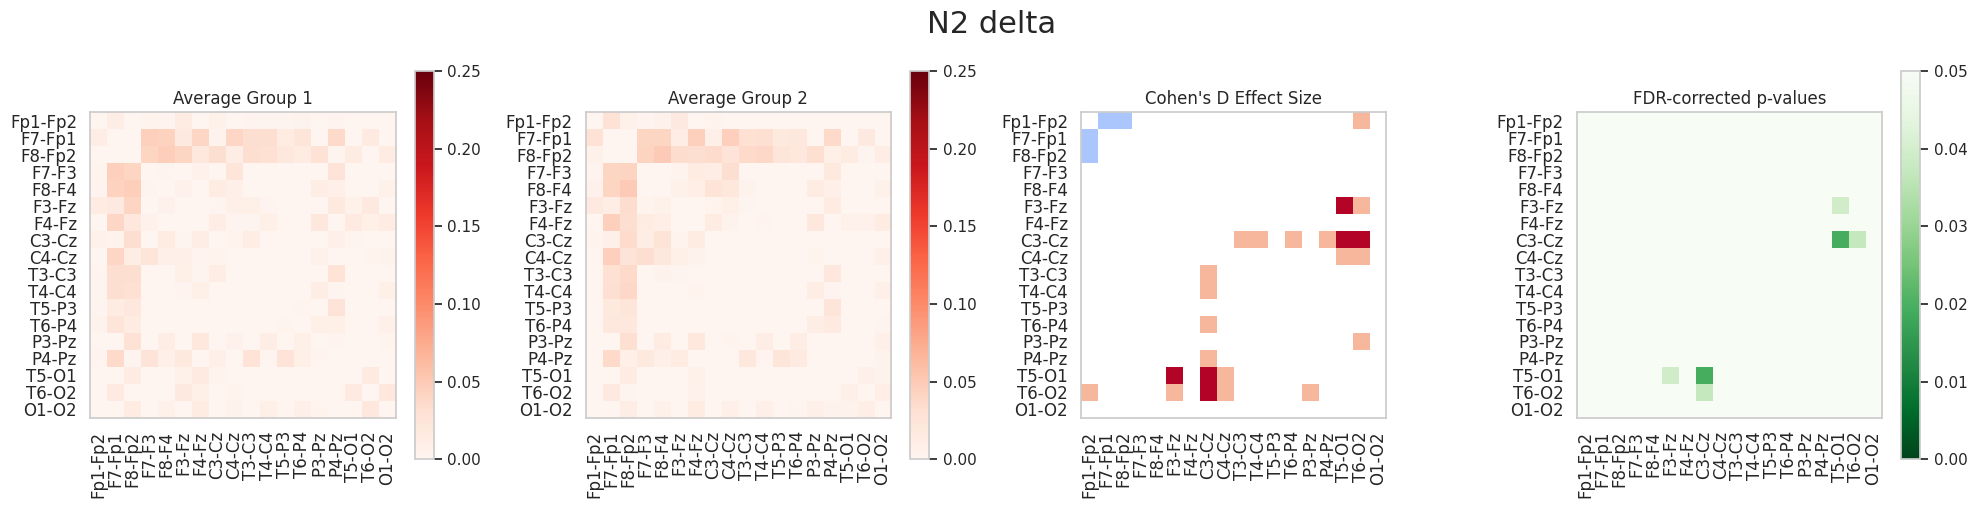

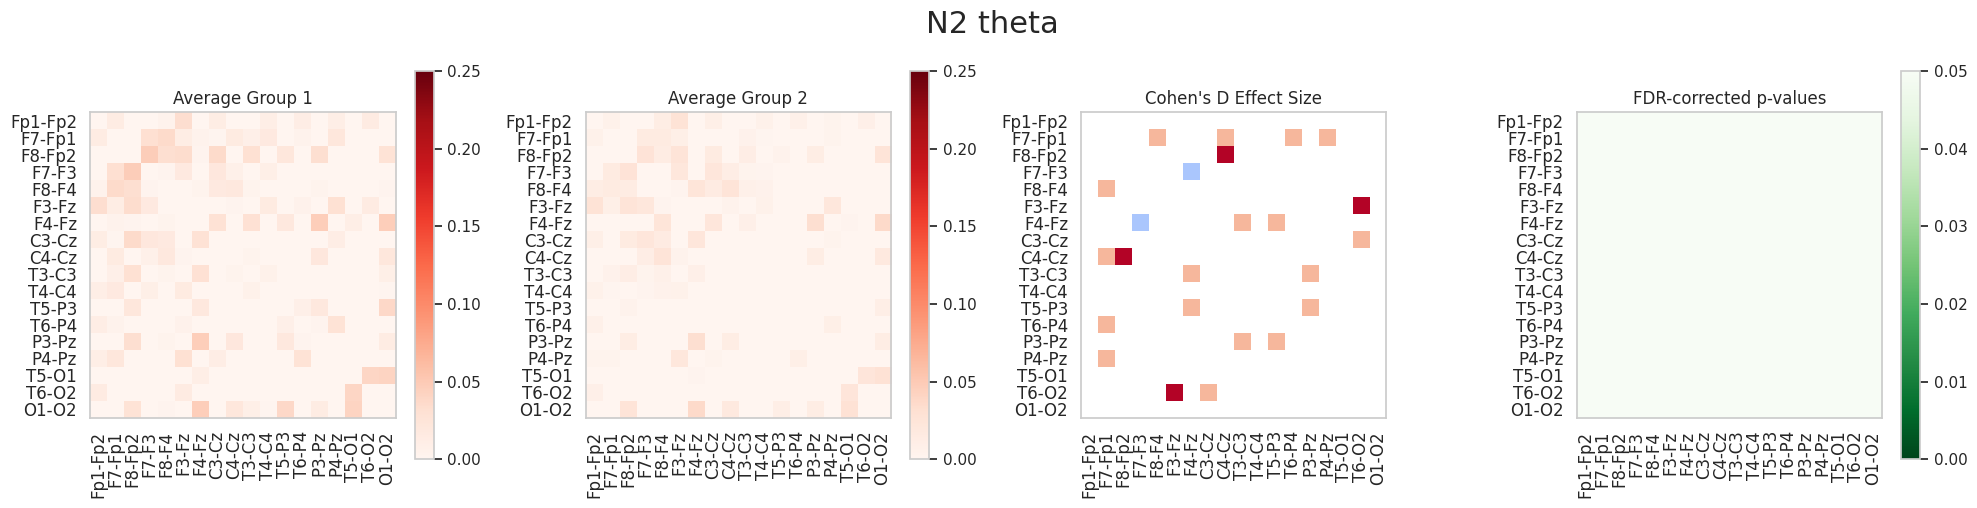

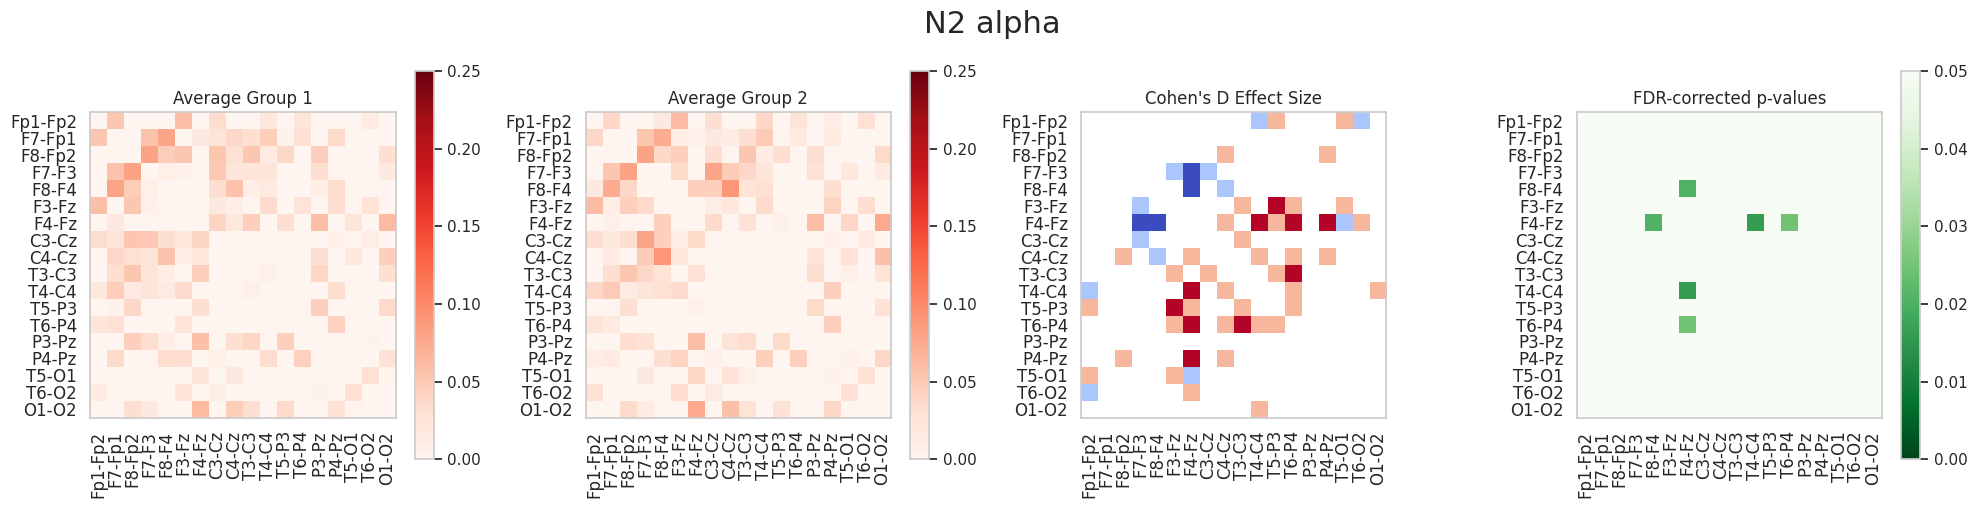

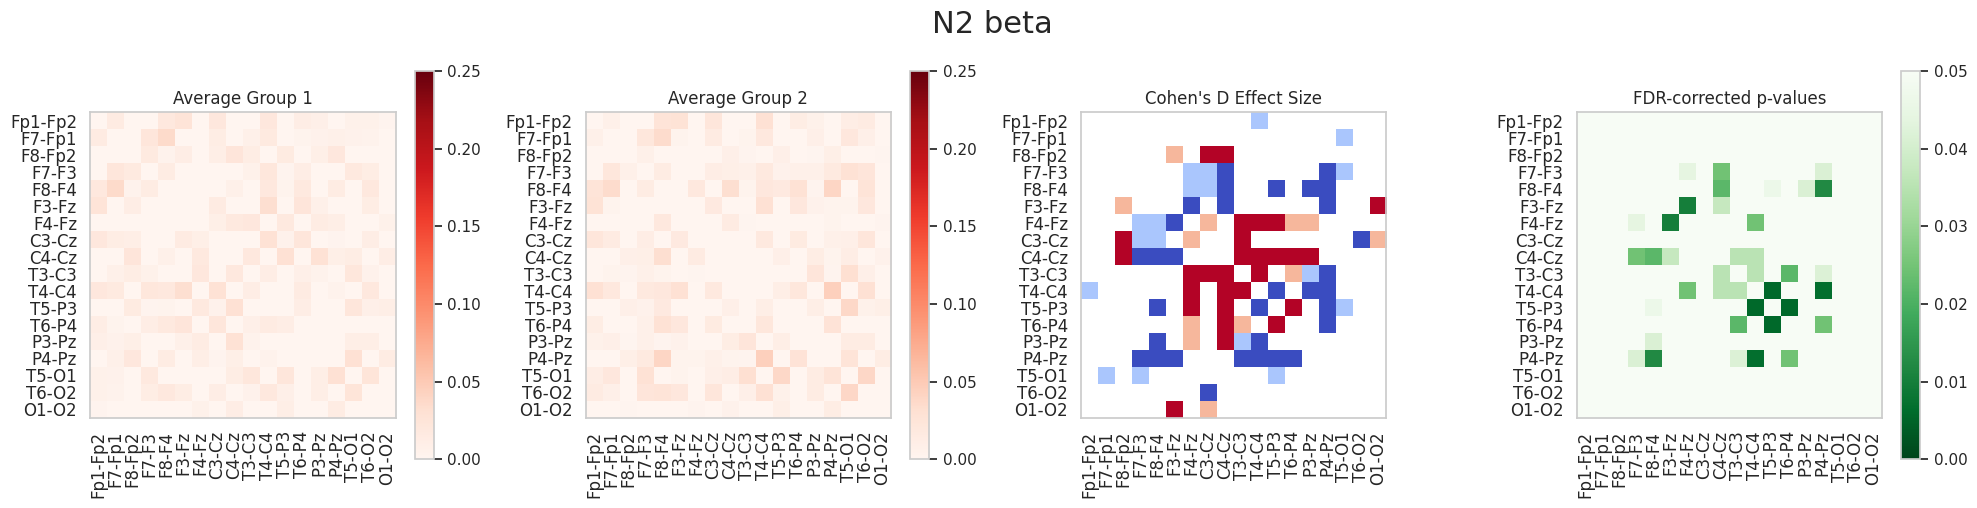

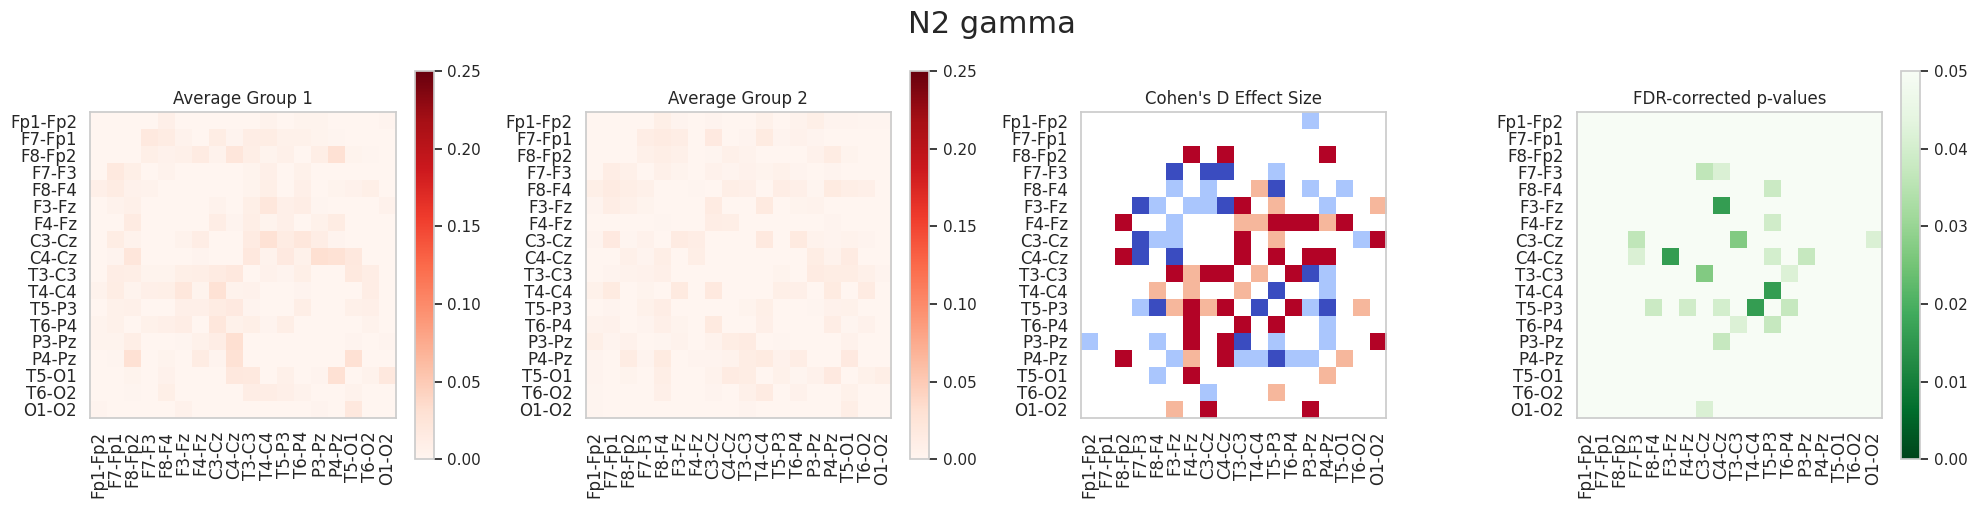

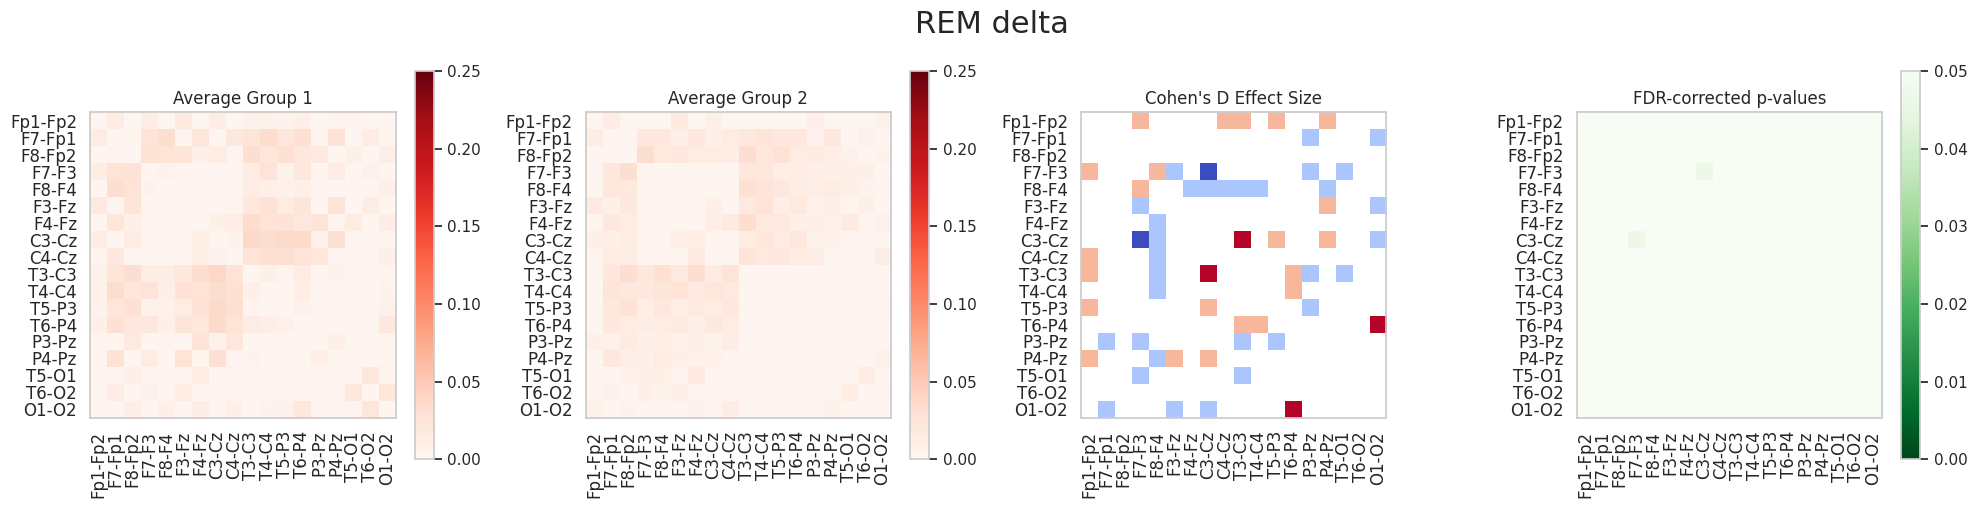

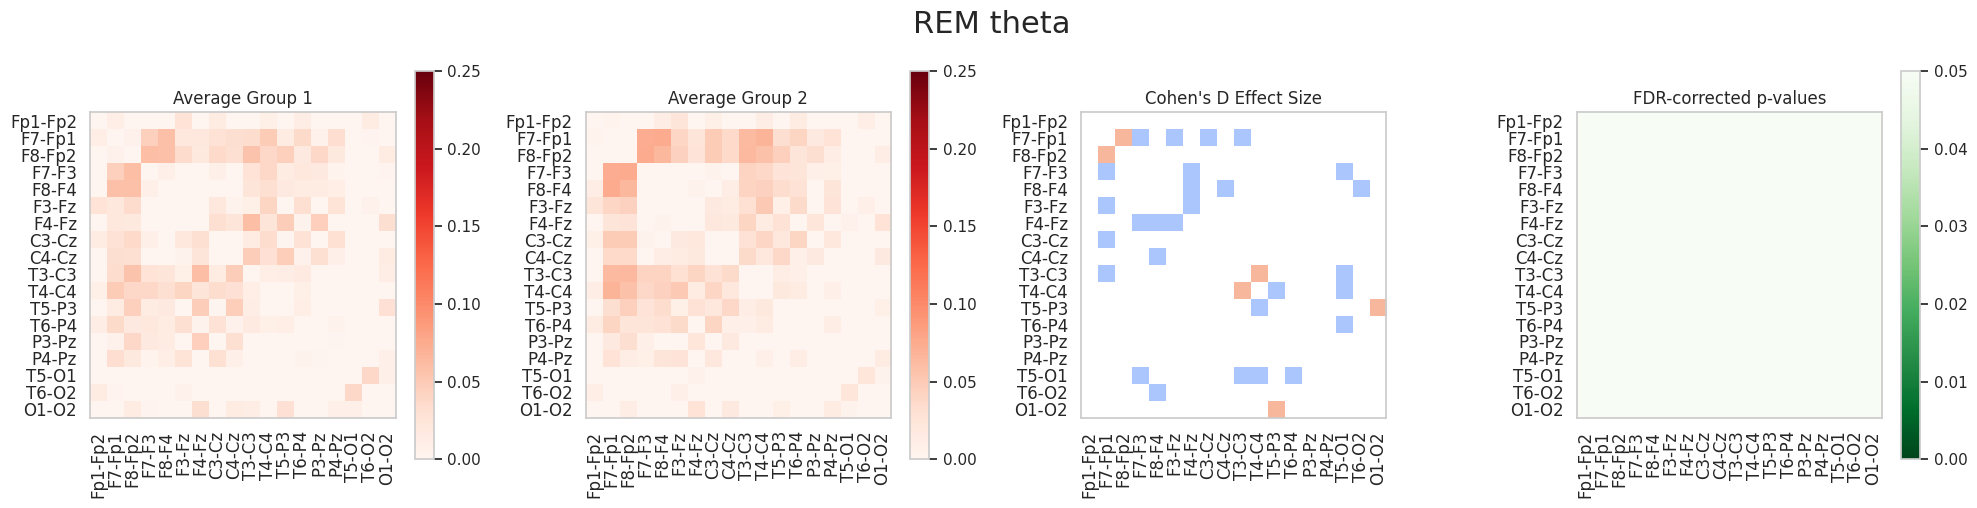

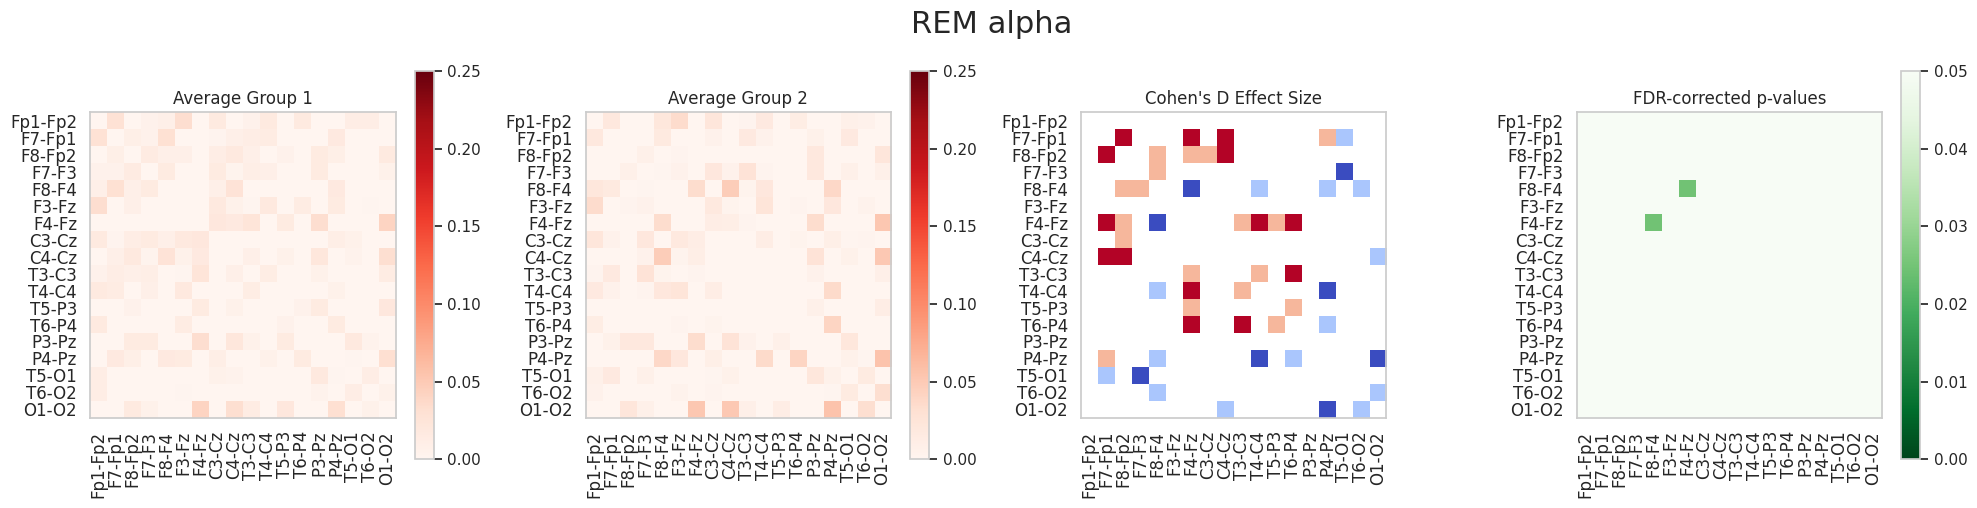

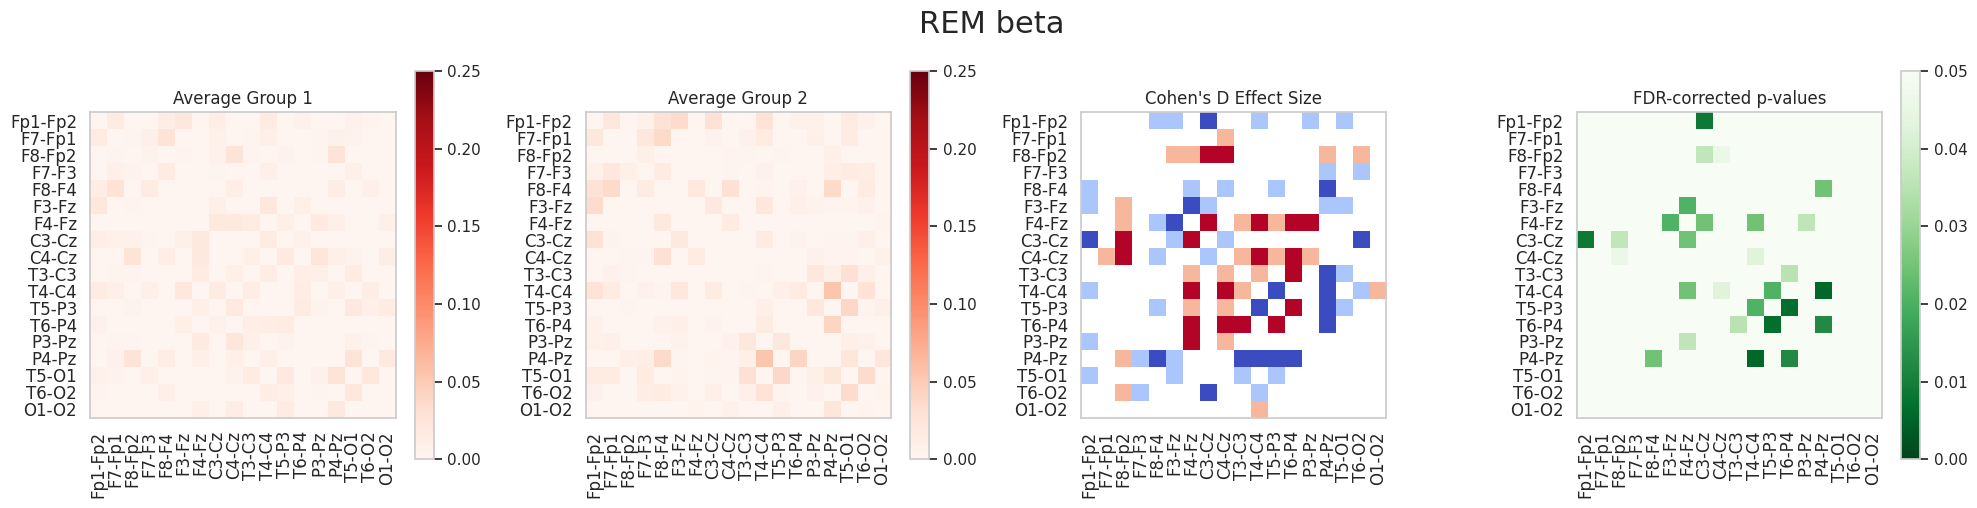

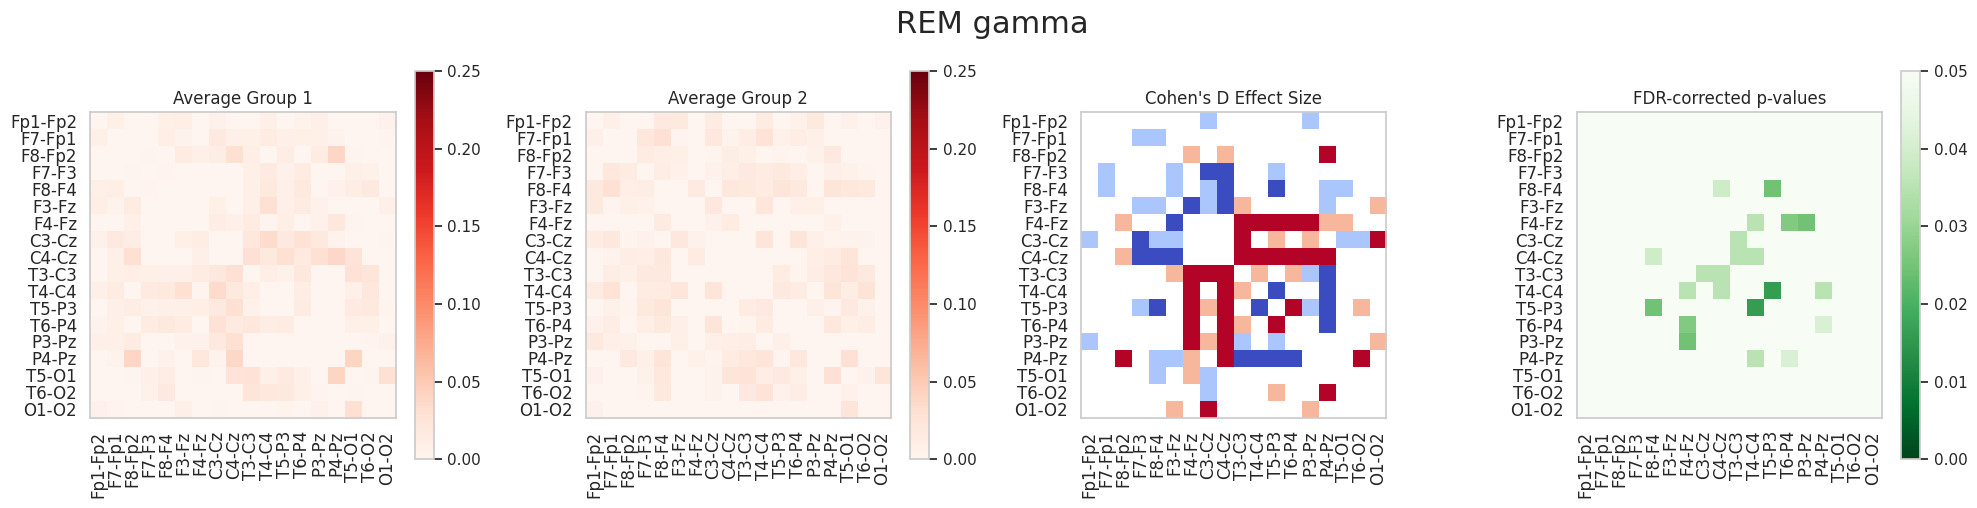

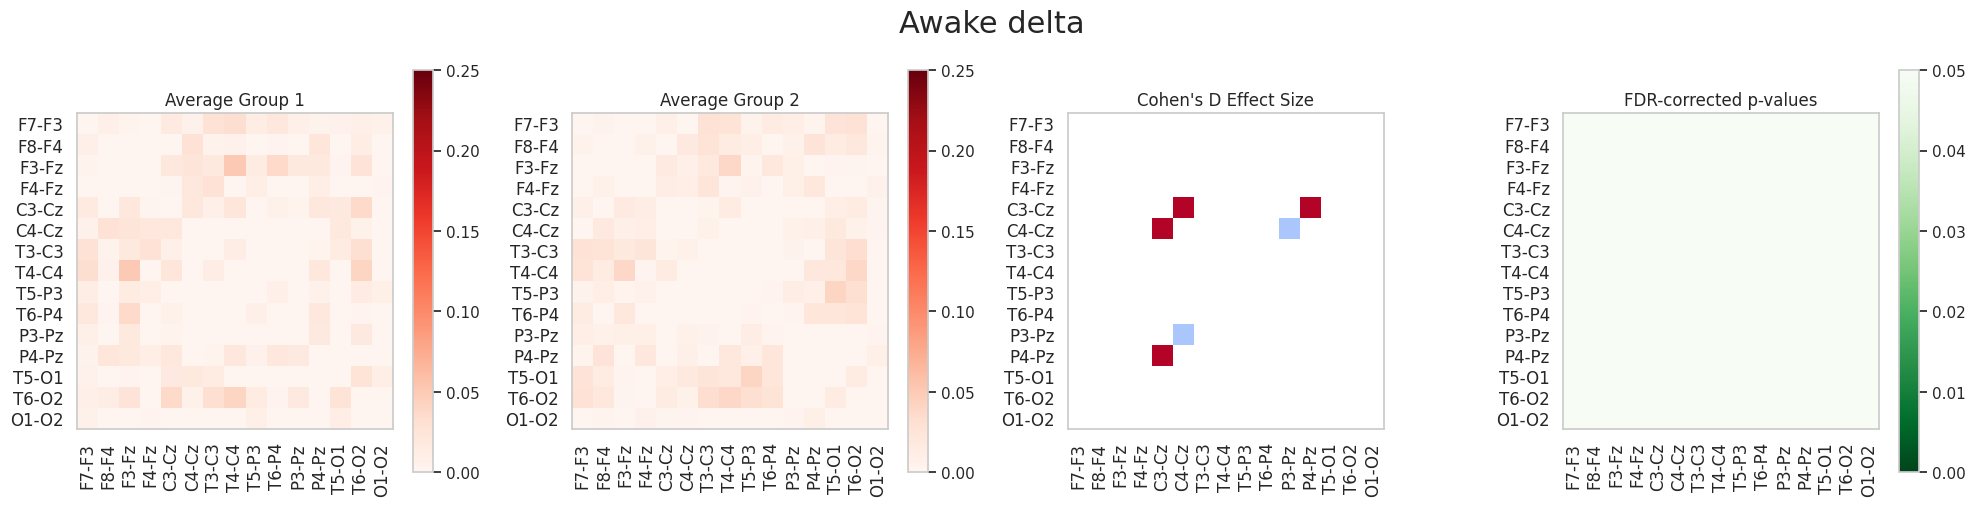

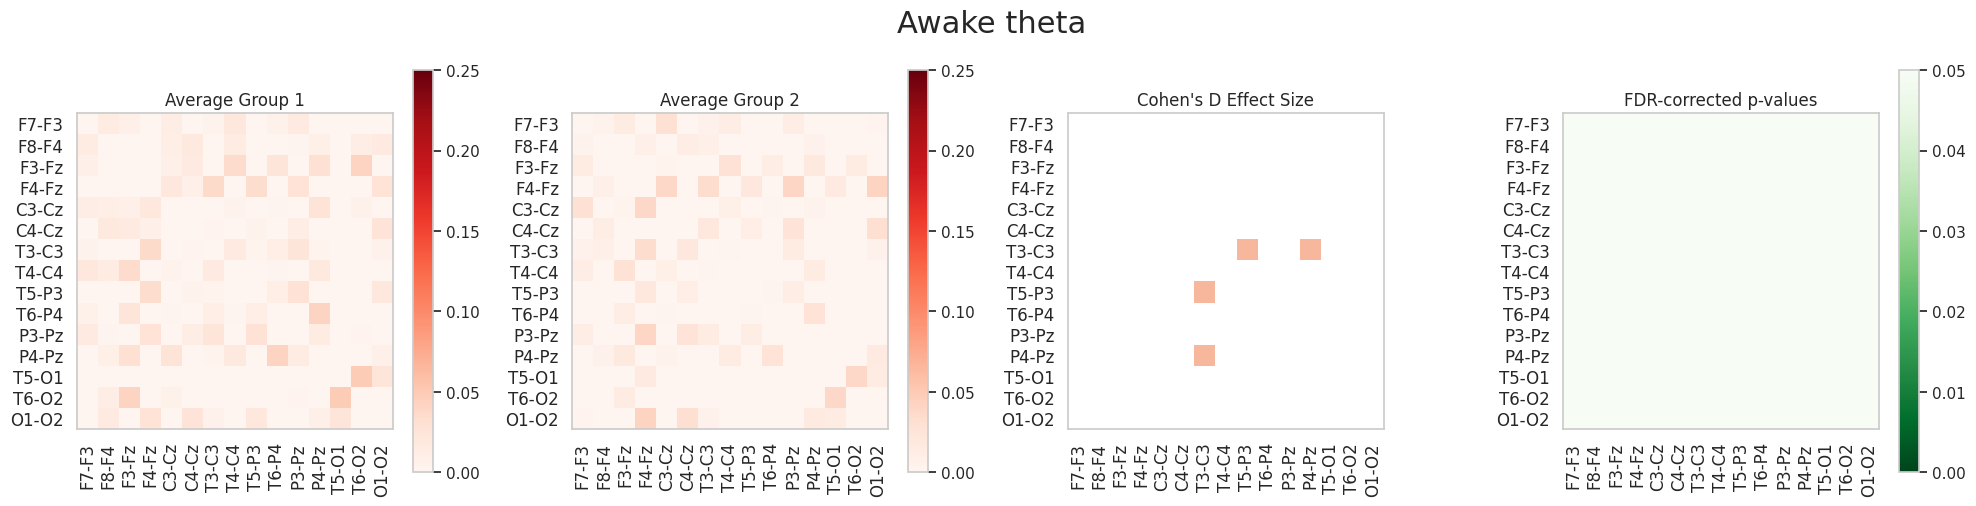

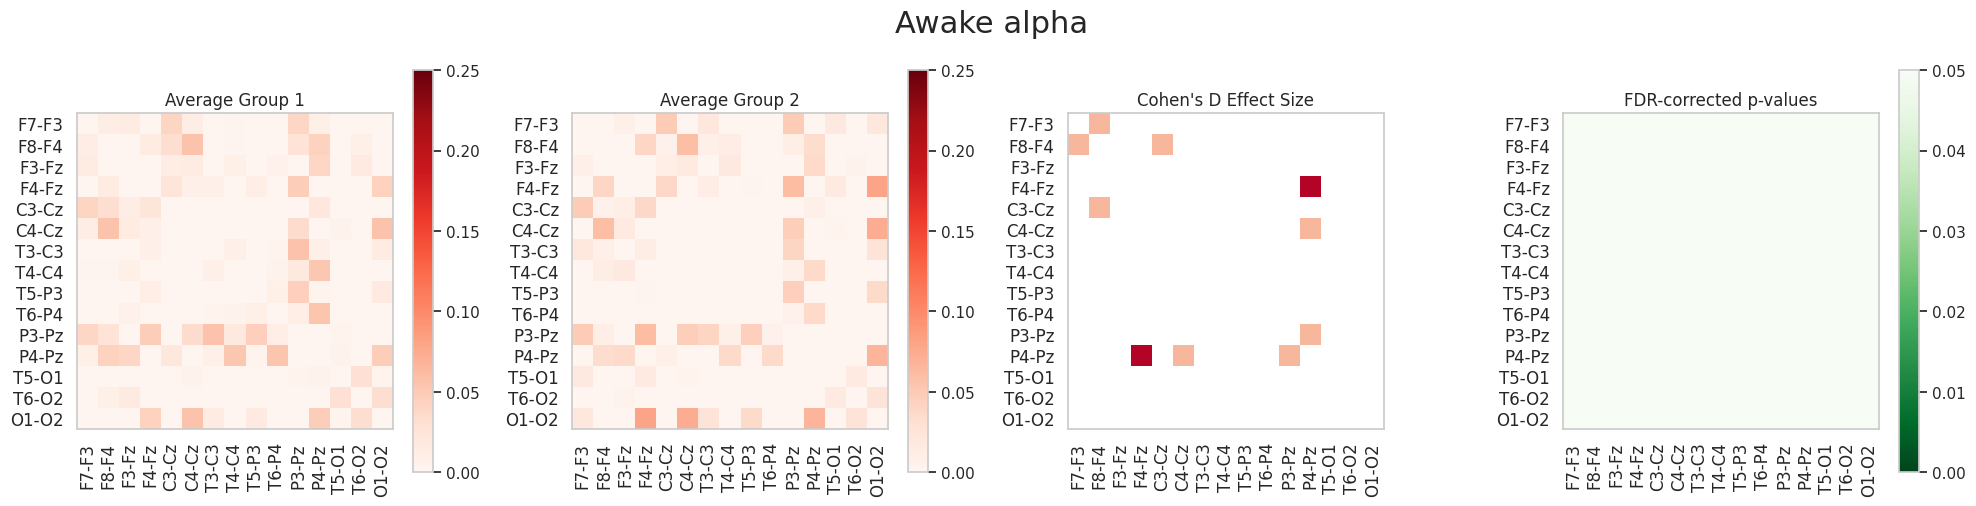

In [ ]:
# Compare AD-NoEp vs HC with the AD-NoEp > HC contrast
# Employ the ImCoh connectivity metric
cohens_d_channels_w_pval(adnoep_coh, hc_coh, channels, threshold_1=0.5, threshold_2=0.7, excluded_awake_channels=[0,1,2], excluded_keys=["4_beta", "4_gamma"])

Number of channel-wise p-values to correct = 1845



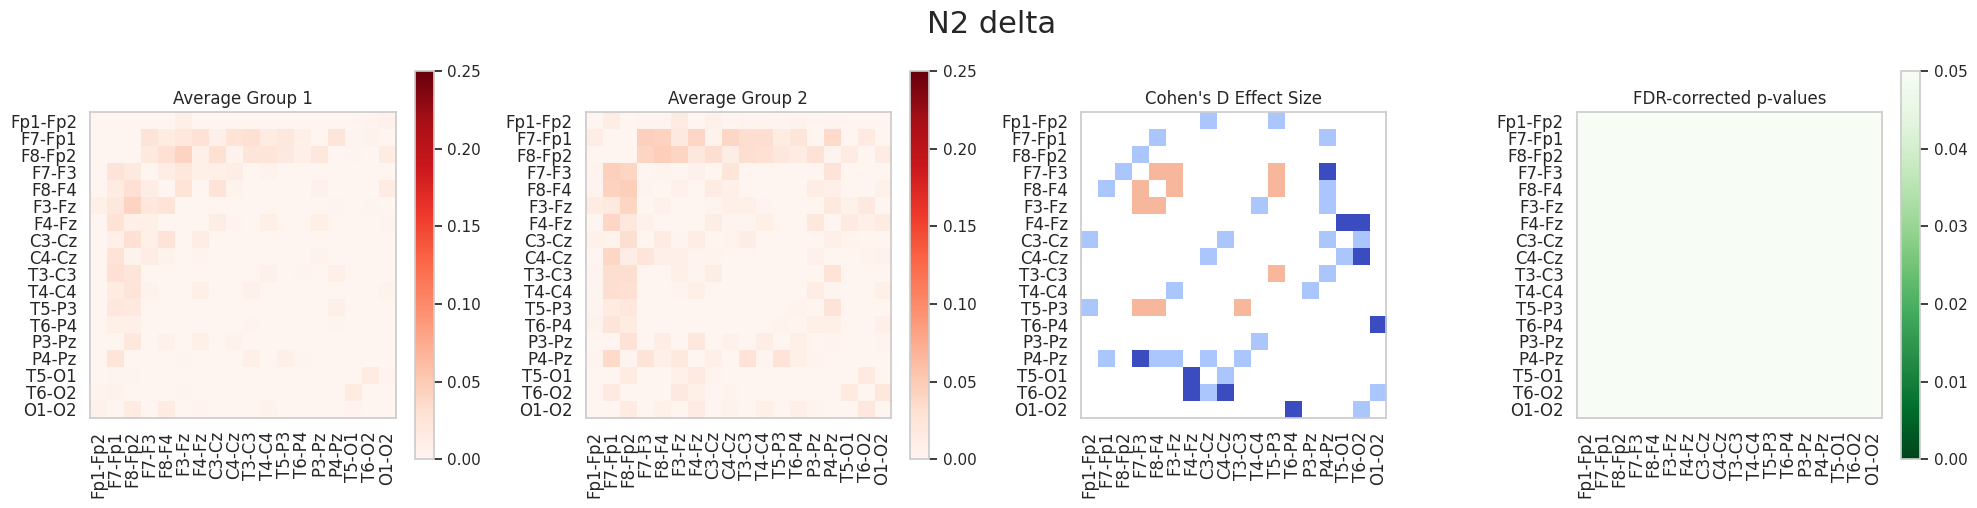

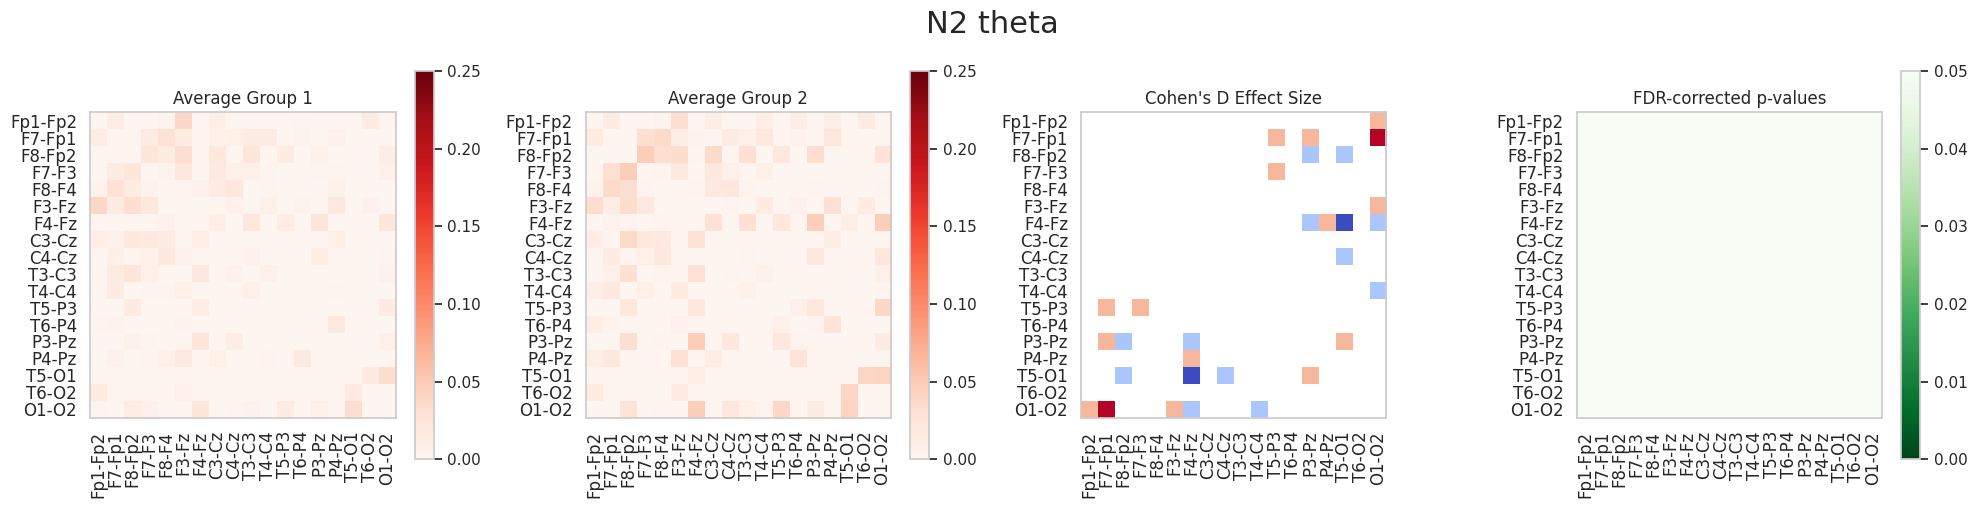

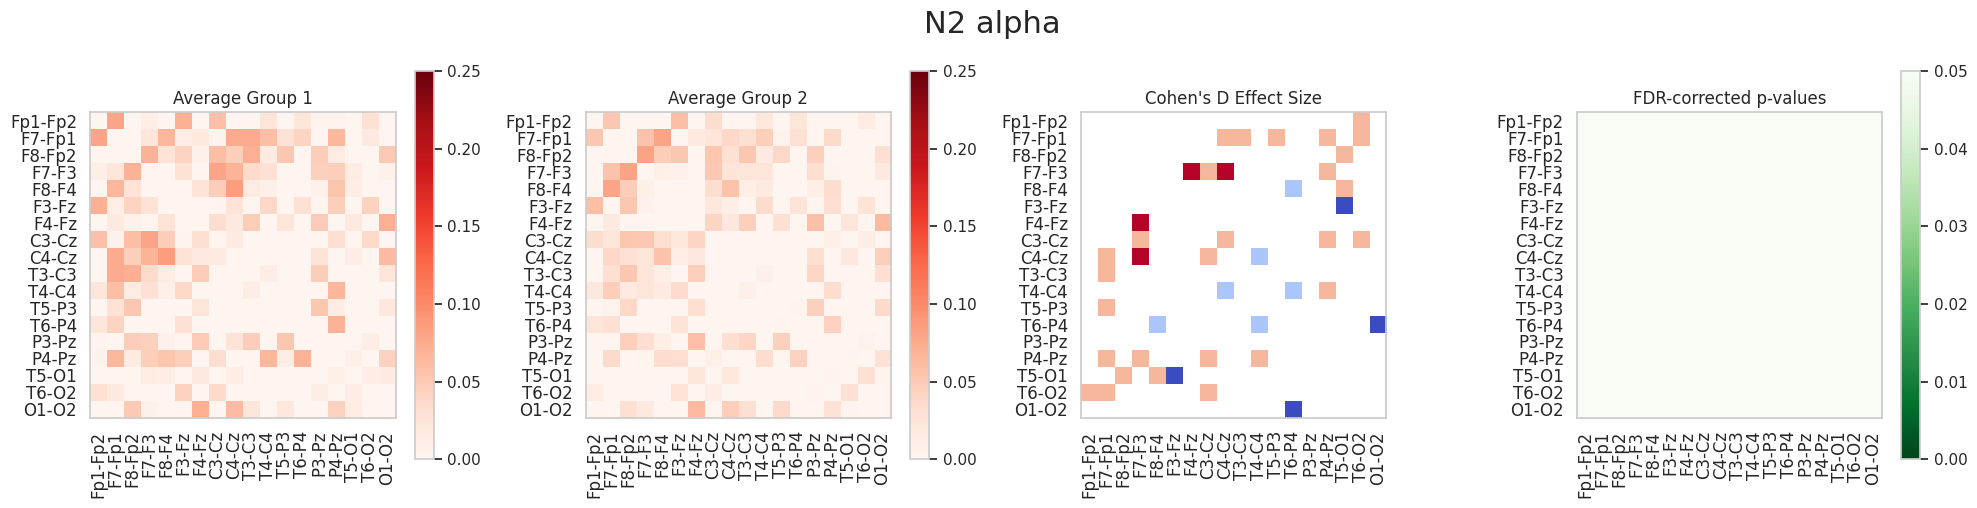

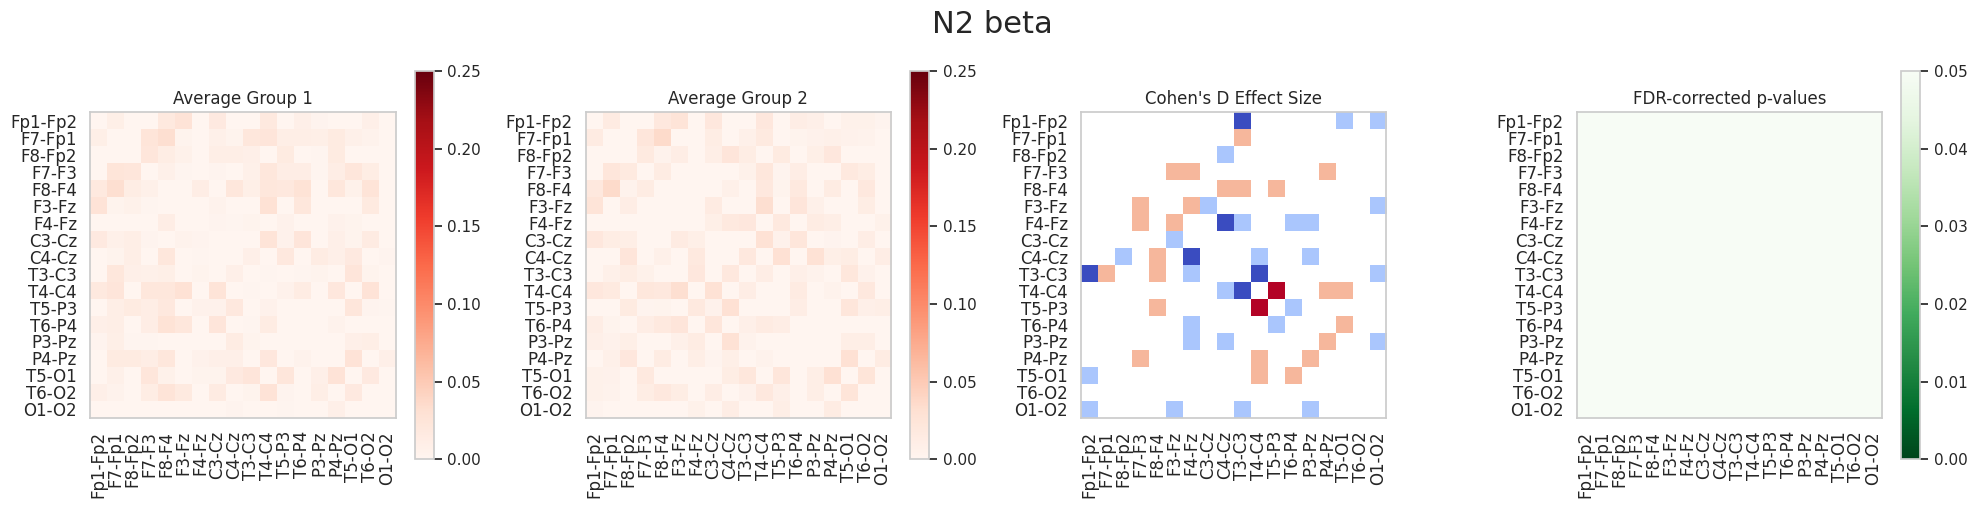

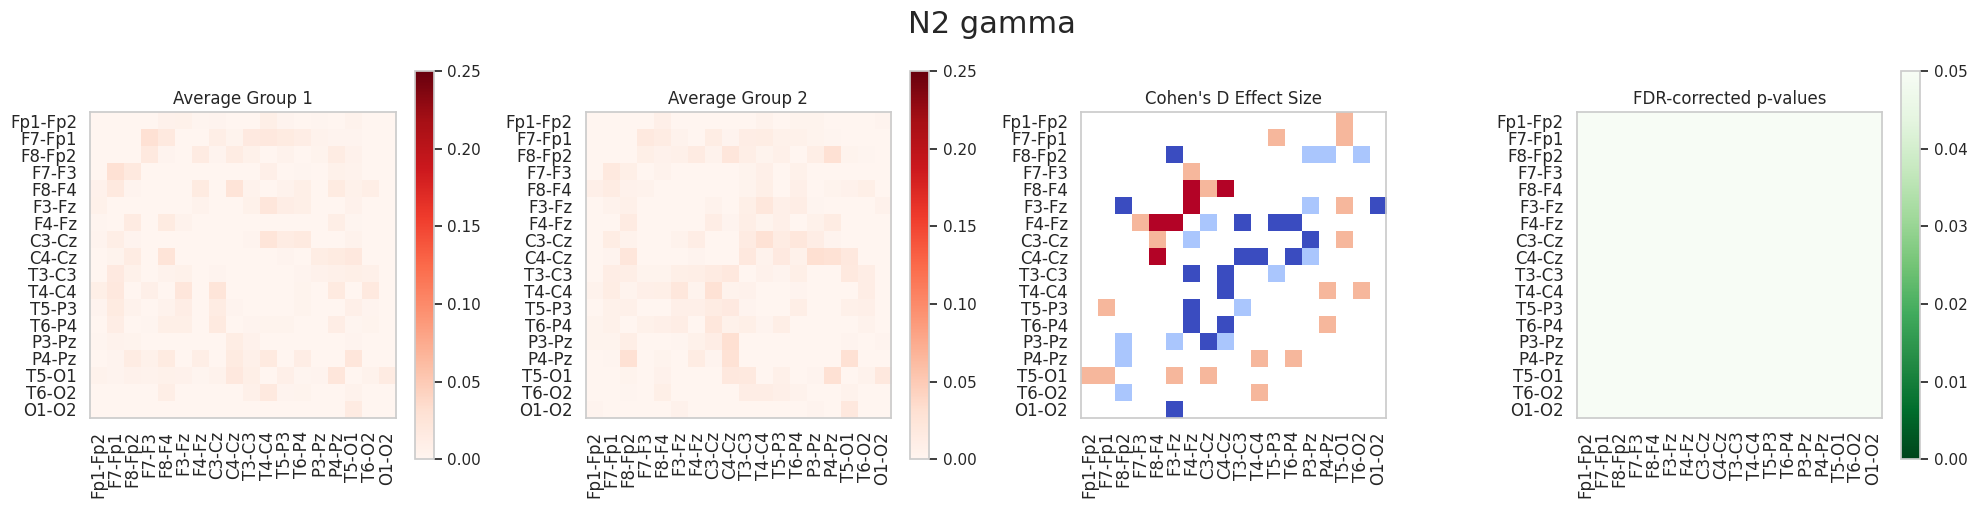

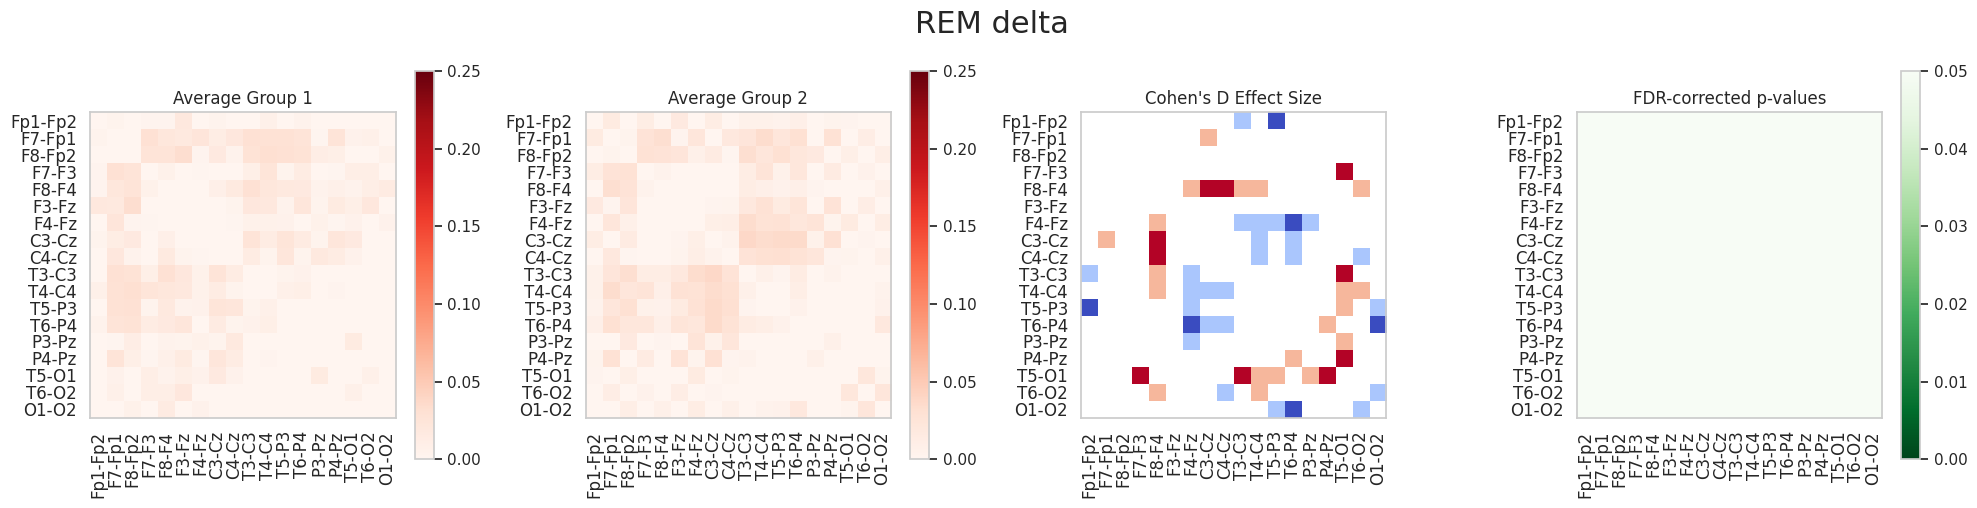

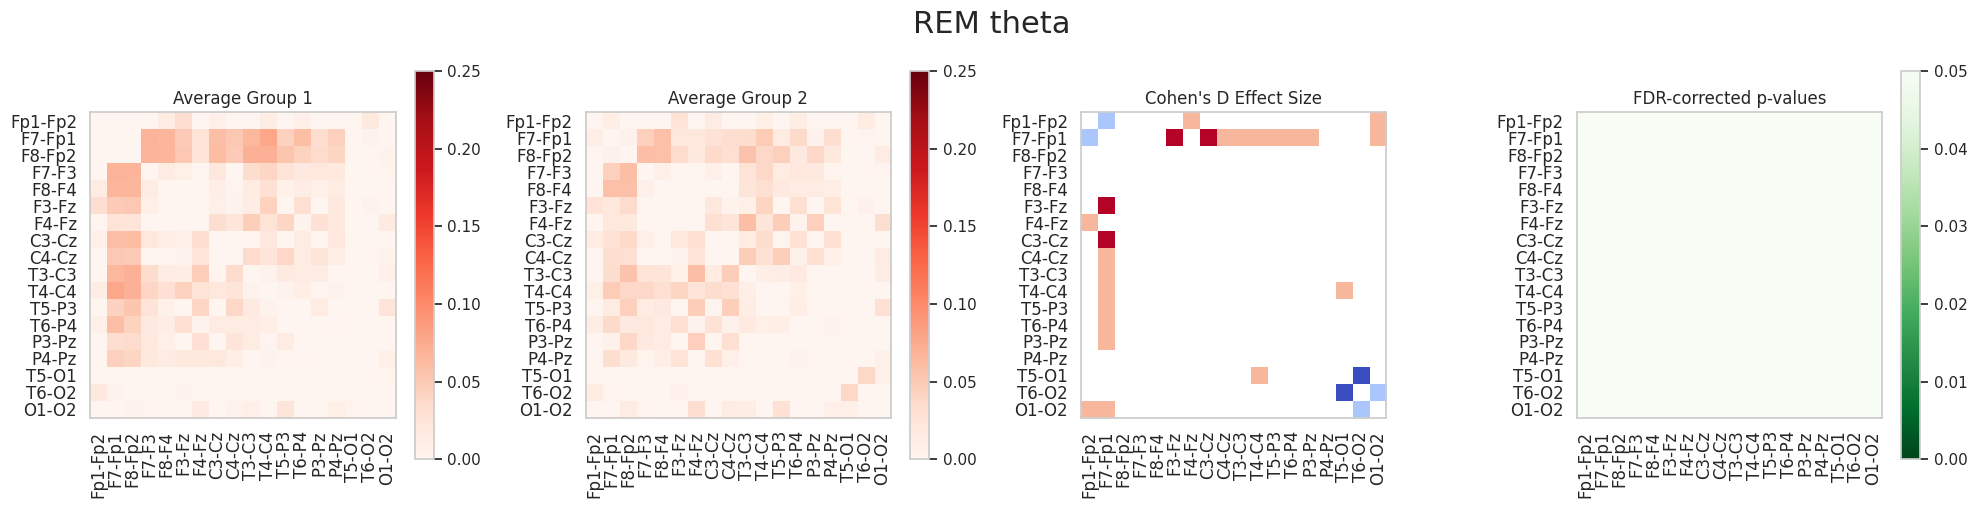

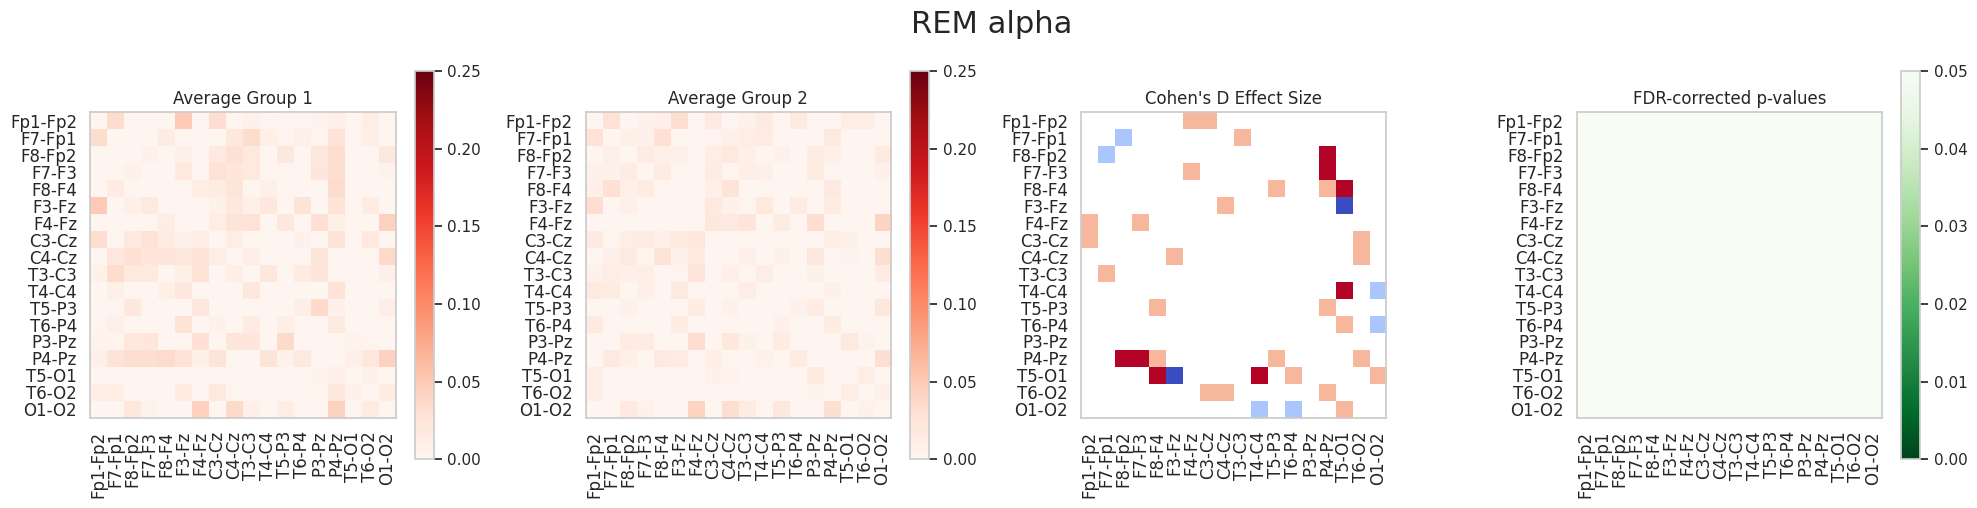

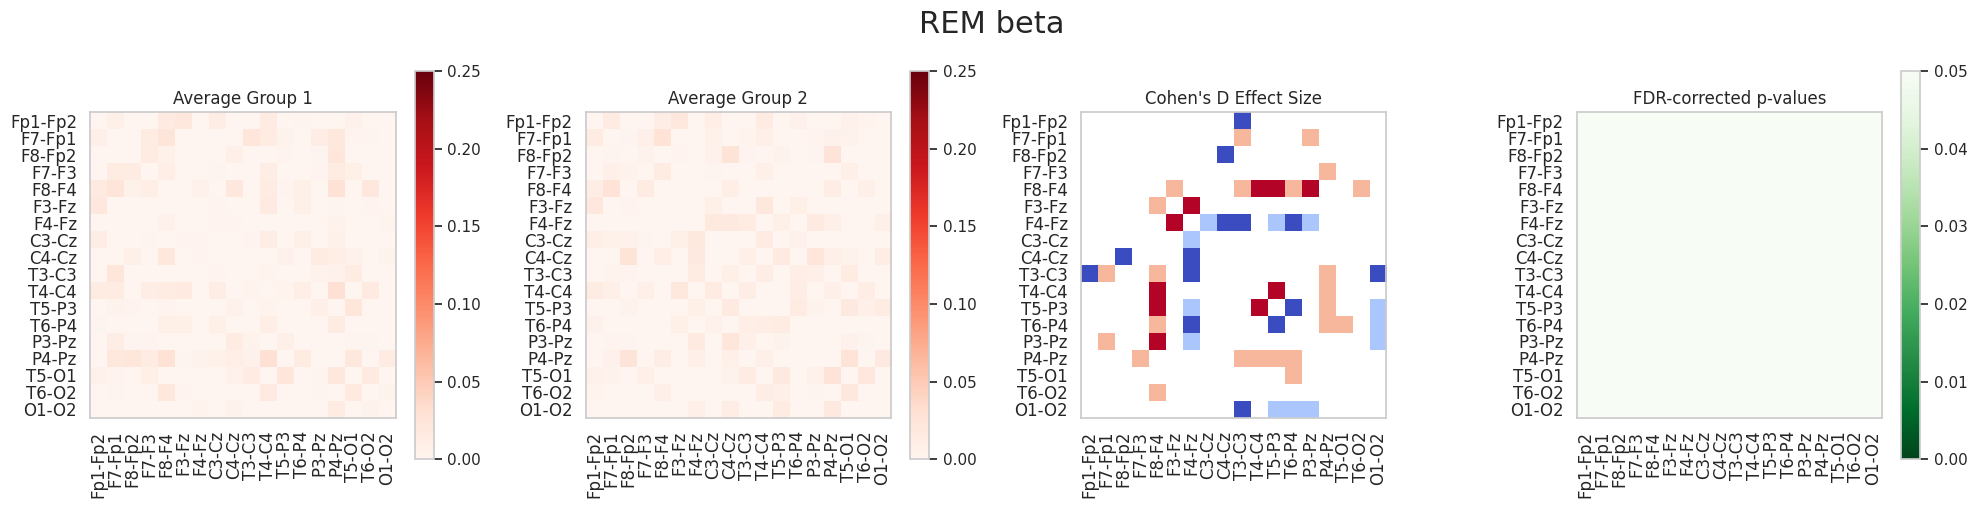

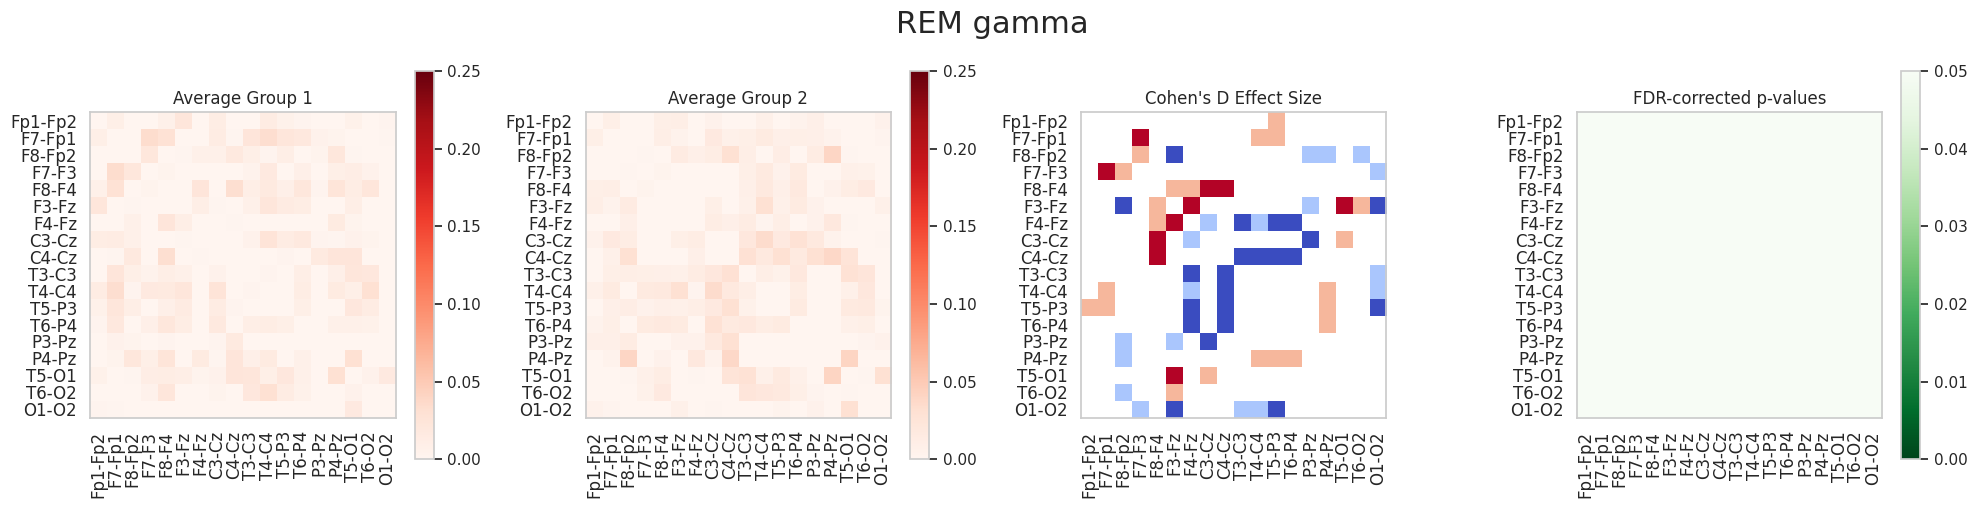

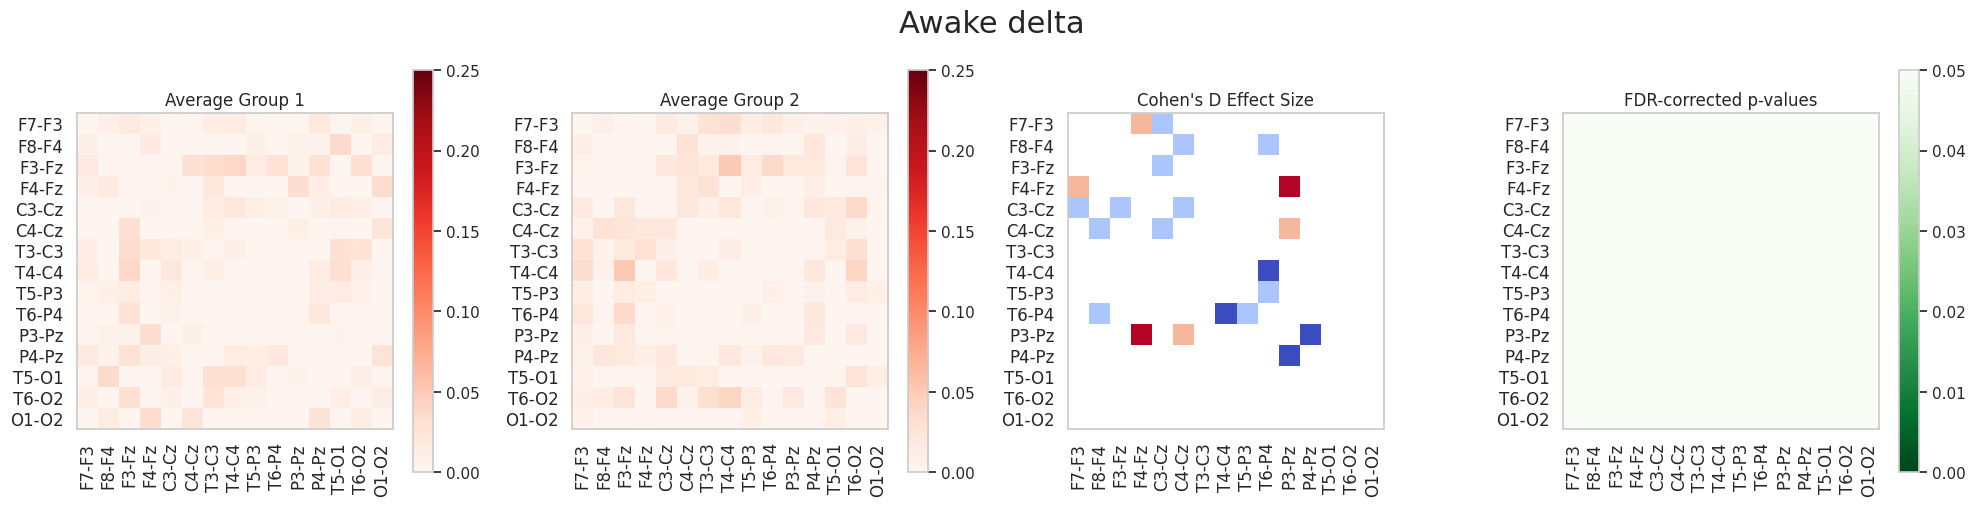

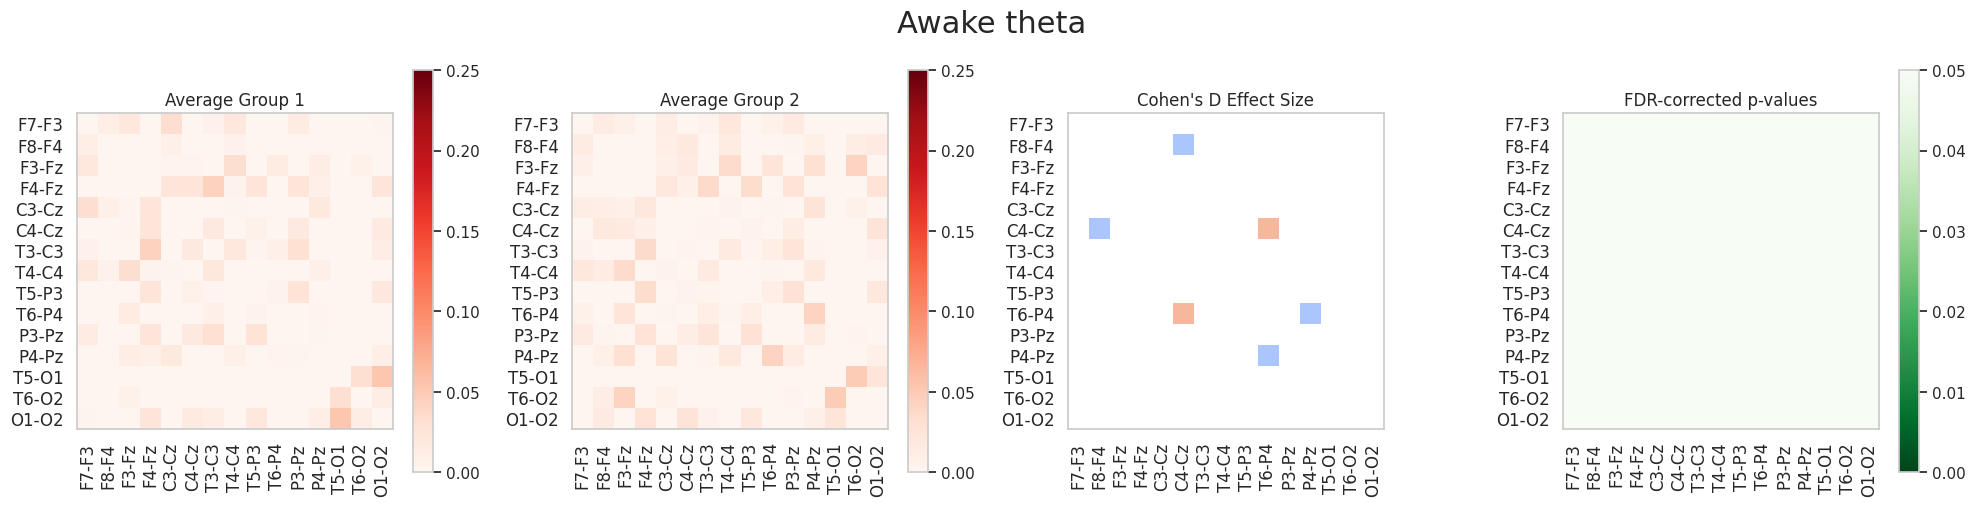

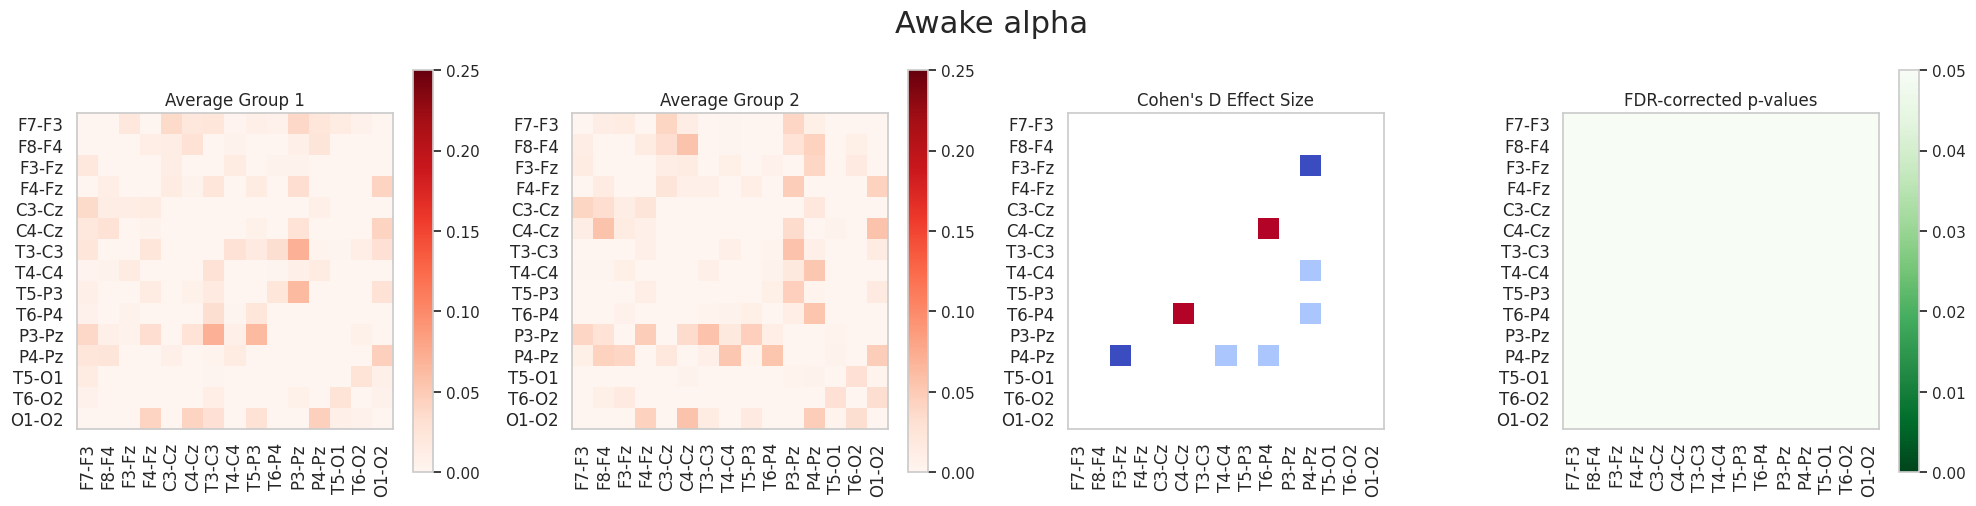

In [ ]:
# Compare AD-Ep vs AD-NoEp with the AD-Ep > AD-NoEp contrast
# Employ the ImCoh connectivity metric
cohens_d_channels_w_pval(adep_coh, adnoep_coh, channels, threshold_1=0.5, threshold_2=0.7, excluded_awake_channels=[0,1,2], excluded_keys=["4_beta", "4_gamma"])

In [ ]:
# Analyze second night effects
# Merge 1st night and 2nd night feature tables

df_N2_gamma = features['1_gamma'].merge(second_night['1_gamma'], on = 'ID')
df_N2_delta = features['1_delta'].merge(second_night['1_delta'], on = 'ID')
df_N2_alpha = features['1_alpha'].merge(second_night['1_alpha'], on = 'ID')
df_REM_alpha = features['3_alpha'].merge(second_night['3_alpha'], on = 'ID')
df_REM_delta = features['3_delta'].merge(second_night['3_delta'], on = 'ID')
df_REM_beta = features['3_beta'].merge(second_night['3_beta'], on = 'ID')

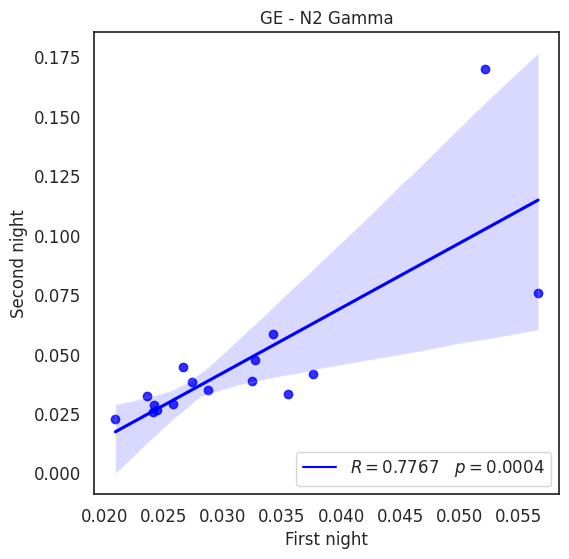

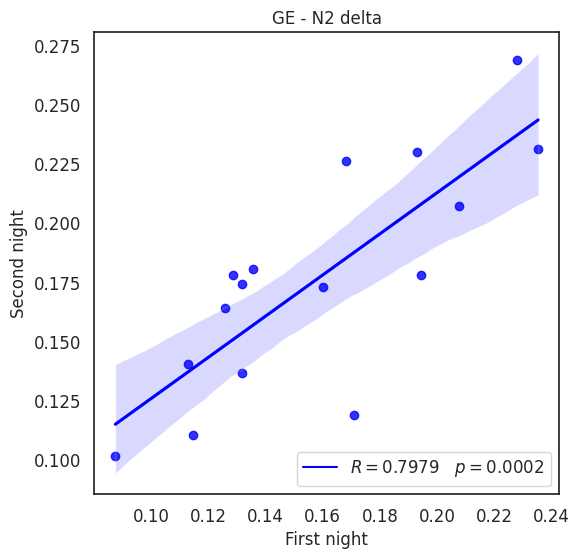

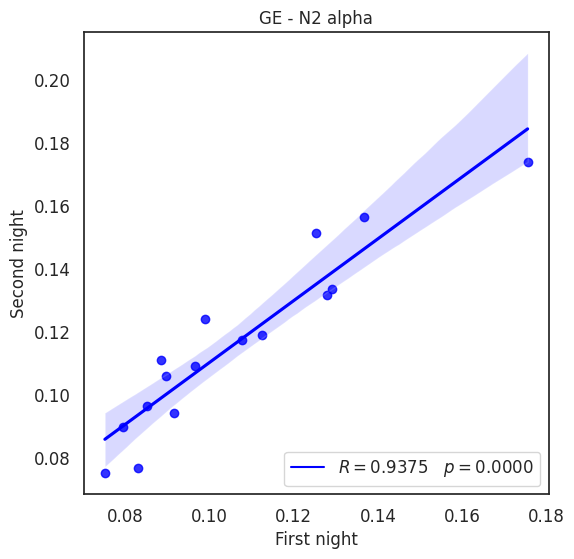

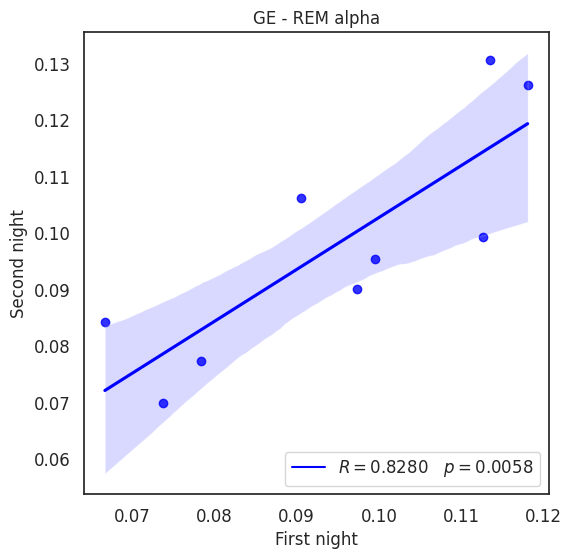

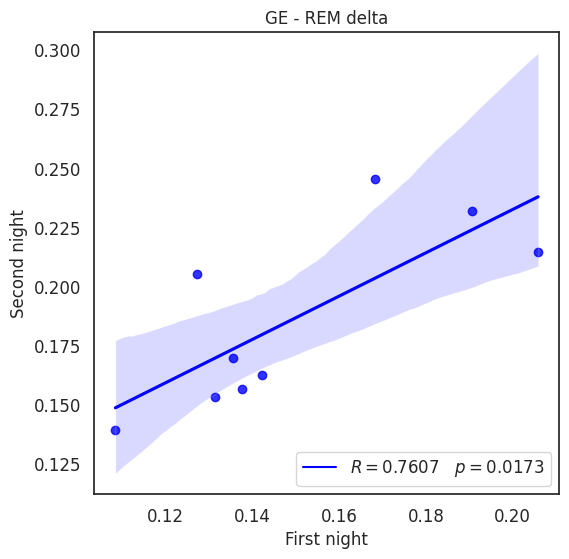

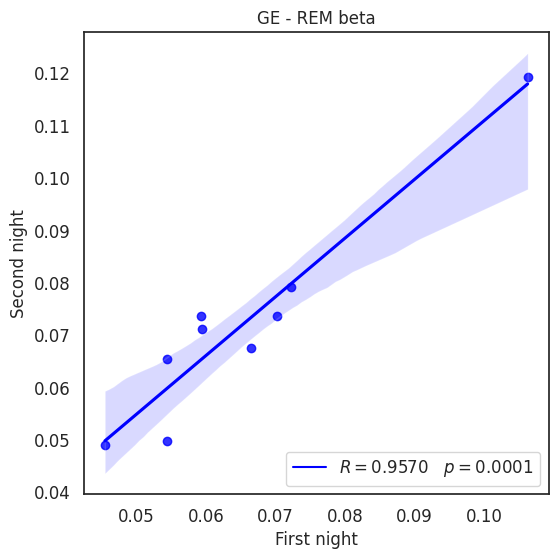

In [ ]:
# Plot the regressions for the desired stages and bands
# Input should be the merged table, the features for the first night (suffix _x) and second night (suffix_y),
# and the title of the plot

plot_1st_vs_2nd_night(df_N2_gamma, "GE_AEC_x", "GE_AEC_y", "GE - N2 Gamma")
plot_1st_vs_2nd_night(df_N2_delta, "GE_AEC_x", "GE_AEC_y", "GE - N2 delta")
plot_1st_vs_2nd_night(df_N2_alpha, "GE_AEC_x", "GE_AEC_y", "GE - N2 alpha")
plot_1st_vs_2nd_night(df_REM_alpha, "GE_AEC_x", "GE_AEC_y", "GE - REM alpha")
plot_1st_vs_2nd_night(df_REM_delta, "GE_AEC_x", "GE_AEC_y", "GE - REM delta")
plot_1st_vs_2nd_night(df_REM_beta, "GE_AEC_x", "GE_AEC_y", "GE - REM beta")

In [ ]:
#### Medication effects in Gamma in ADNoEp vs HC

AChEI_or_mem_gamma = ['ADEX_013',
                    'ADEX_014',
                    'ADEX_019',
                    'ADEX_026',
                    'ADEX_043',
                    'ADEX_065',
                    'ADEX_066',
                    'ADEX_073',
                    'ADEX_078',
                    'ADEX_088',
                    'ADEX_092',
                    'ADEX_102',
                    'ADEX_107',
                    'ADEX_117',
                    'ADEX_119',
                    'ADEX_137',
                      ## Fix
                    'ADEX_113',
                    'ADEX_116',
                    'ADEX_125',
                    'ADEX_130',
                    'ADEX_135']

memantine_gamma = ['ADEX_013',
                    'ADEX_014',
                    'ADEX_019',
                    'ADEX_043',
                    'ADEX_073',
                    'ADEX_088',
                    'ADEX_102',
                    'ADEX_119',
                    'ADEX_137',
                   ## Fix
                    'ADEX_135']

memantine_only_gamma = ['ADEX_137']

AChEI_gamma = ['ADEX_013',
                'ADEX_014',
                'ADEX_019',
                'ADEX_026',
                'ADEX_043',
                'ADEX_065',
                'ADEX_066',
                'ADEX_073',
                'ADEX_078',
                'ADEX_088',
                'ADEX_092',
                'ADEX_102',
                'ADEX_107',
                'ADEX_117',
                'ADEX_119',
               ## Fix
                'ADEX_113',
                'ADEX_116',
                'ADEX_125',
                'ADEX_130',
                'ADEX_135']

AChEI_only_gamma = ['ADEX_026',
                    'ADEX_065',
                    'ADEX_066',
                    'ADEX_078',
                    'ADEX_092',
                    'ADEX_107',
                ## Fix
                    'ADEX_113',
                    'ADEX_116',
                    'ADEX_125',
                    'ADEX_130',
                    'ADEX_135']

nomedication_gamma = ['ADEX_005',
                    'ADEX_018',
                    'ADEX_025',
                    'ADEX_031',
                    'ADEX_042',
                    'ADEX_048',
                    'ADEX_054',
                    'ADEX_055',
                    'ADEX_058',
                    'ADEX_063',
                    'ADEX_068',
                    'ADEX_076',
                    'ADEX_079',
                    'ADEX_080',
                    'ADEX_084',
                    'ADEX_099',
                    'ADEX_103',
                    'ADEX_120',
                    'ADEX_132',
                    'ADEX_136',
                    'ADEX_138',
                    'ADEX_140']

In [ ]:
# Process N2 gamma data to pass to the plotting function
# Get N2 gamma features
df_gamma = features['1_gamma']

# Create a new column "Medication" with default value NaN
df_gamma["Medication"] = np.nan

# Update the "Medication" column based on the medication and non-medication lists
df_gamma.loc[df_gamma["ID"].isin(AChEI_or_mem_gamma), "Medication"] = 1
df_gamma.loc[df_gamma["ID"].isin(nomedication_gamma), "Medication"] = 0

# Select the desired columns, filtering the rest of the unused features
filtered_df_gamma = df_gamma[["Class", "ID", "GE_AEC", "Medication"]].copy()

# Function to create a new target class whether medication is 1 or 0
def create_new_class(row):
    if row['Class'] == 'ADNoEp':
        if row['Medication'] == 1:
            return 'ADNoEp_medication'
        else:
            return 'ADNoEp_no_medication'
    return row['Class']

# Apply the function to create the new class column
filtered_df_gamma['Class'] = filtered_df_gamma.apply(create_new_class, axis=1)
filtered_df_gamma

Class        ID    GE_AEC  Medication
0      ADNoEp_medication  ADEX_026  0.052161         1.0
1   ADNoEp_no_medication  ADEX_138  0.033847         0.0
2      ADNoEp_medication  ADEX_019  0.034233         1.0
3      ADNoEp_medication  ADEX_073  0.029915         1.0
4      ADNoEp_medication  ADEX_102  0.060643         1.0
..                   ...       ...       ...         ...
84                    HC  ADEX_087  0.027429         NaN
85                    HC  ADEX_101  0.025684         NaN
86                    HC  ADEX_070  0.031094         NaN
87                    HC  ADEX_020  0.056645         NaN
88                    HC  ADEX_056  0.028760         NaN

[83 rows x 4 columns]

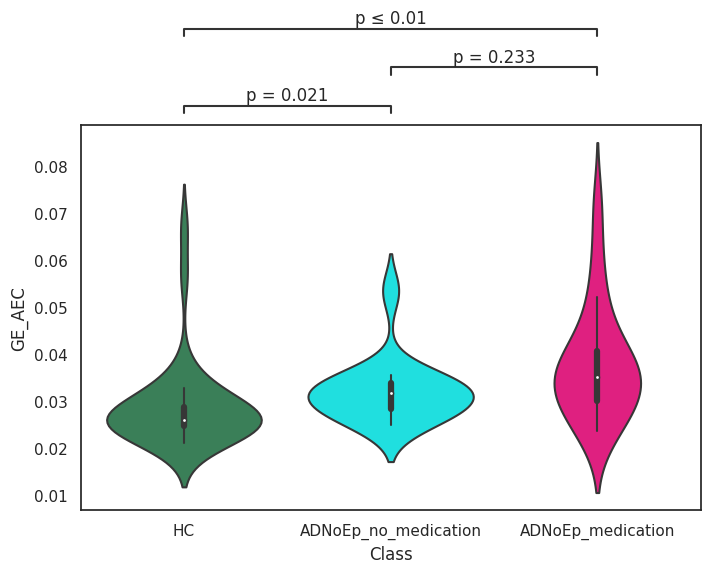

In [ ]:
plot_med_effects(filtered_df_gamma, 'HC', 'ADNoEp_no_medication', 'ADNoEp_medication', metric='GE_AEC', colors = ["#2E8B57", "#00ffff", "#ff0080"])

In [ ]:
# Same with N2 delta in ADEp vs ADNoEp
levetiracetam = ['ADEX_010',
                'ADEX_129',
                'ADEX_139']

no_levetiratecam = ['ADEX_001',
                    'ADEX_040',
                    'ADEX_044',
                    'ADEX_097',
                    'ADEX_100',
                    'ADEX_104',
                    'ADEX_114',
                    'ADEX_118',
                    'ADEX_126',
                    'ADEX_127',
                    'ADEX_128']

AEDs = ['ADEX_001',
        'ADEX_010',
        'ADEX_040',
        'ADEX_097',
        'ADEX_104',
        'ADEX_114',
        'ADEX_118',
        'ADEX_127',
        'ADEX_128',
        'ADEX_129',
        'ADEX_139']

no_AEDs = ['ADEX_044',
            'ADEX_100',
            'ADEX_126']

df_delta = features['1_delta']

# Create a new column "Medication" with default value NaN
df_delta["Medication"] = np.nan

# Update the "Medication" column based on the medication and non-medication lists
# Here we want to check the effects of Levetiracetam
df_delta.loc[df_delta["ID"].isin(levetiracetam), "Medication"] = 1
df_delta.loc[df_delta["ID"].isin(no_levetiratecam), "Medication"] = 0

# Select the desired columns
filtered_df_delta = df_delta[["Class", "ID", "GE_AEC", "Medication"]].copy()

# Function to create the new class based on Medication value
def create_new_class_delta(row):
    if row['Class'] == 'ADEp':
        if row['Medication'] == 1:
            return 'ADEp_medication'
        else:
            return 'ADEp_no_medication'
    return row['Class']

# Apply the function to create the new class column
filtered_df_delta['Class'] = filtered_df_delta.apply(create_new_class_delta, axis=1)
filtered_df_delta

Class        ID    GE_AEC  Medication
0   ADNoEp  ADEX_026  0.128770         NaN
1   ADNoEp  ADEX_138  0.157520         NaN
2   ADNoEp  ADEX_019  0.170782         NaN
3   ADNoEp  ADEX_073  0.098449         NaN
4   ADNoEp  ADEX_102  0.150391         NaN
..     ...       ...       ...         ...
84      HC  ADEX_087  0.135703         NaN
85      HC  ADEX_101  0.100032         NaN
86      HC  ADEX_070  0.141576         NaN
87      HC  ADEX_020  0.113023         NaN
88      HC  ADEX_056  0.161463         NaN

[83 rows x 4 columns]

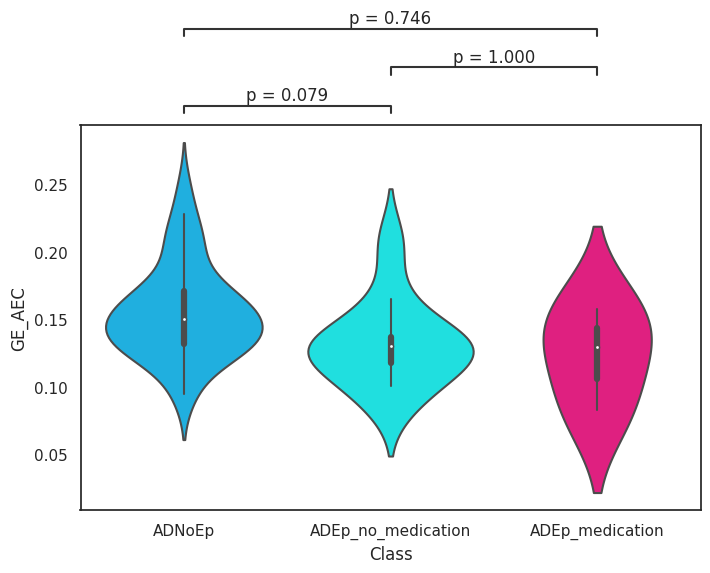

In [ ]:
plot_med_effects(filtered_df_delta, 'ADNoEp', 'ADEp_no_medication', 'ADEp_medication', metric='GE_AEC', colors = ["#00bfff", "#00ffff", "#ff0080"])

In [ ]:
### Compare med and no_med groups with all the group of the same class (e.g., ADEp)

df_delta = features['1_delta']

# Create a new column "Medication" with default value NaN
df_delta["Medication"] = np.nan

# Update the "Medication" column based on the medication and non-medication lists
df_delta.loc[df_delta["ID"].isin(AEDs), "Medication"] = 1
df_delta.loc[df_delta["ID"].isin(no_AEDs), "Medication"] = 0

# Select the desired columns
filtered_df_delta = df_delta[["Class", "ID", "GE_AEC", "Medication"]].copy()

# Duplicate the rows of 'ADEp' class and then modify the Class column
ADEp_rows = filtered_df_delta[filtered_df_delta["Class"] == "ADEp"].copy()

# Function to create the new class based on Medication value
def create_new_class_delta(row):
    if pd.isna(row['Medication']):
        return 'ADEp'
    elif row['Medication'] == 1:
        return 'ADEp_medication'
    else:
        return 'ADEp_no_medication'

# Apply the function to create the new class column only for ADEp_rows
ADEp_rows['Class'] = ADEp_rows.apply(create_new_class_delta, axis=1)

# Concatenate the modified ADEp_rows with the original dataframe
filtered_df_delta = pd.concat([filtered_df_delta, ADEp_rows], ignore_index=True)
filtered_df_delta

Class        ID    GE_AEC  Medication
0            ADNoEp  ADEX_026  0.128770         NaN
1            ADNoEp  ADEX_138  0.157520         NaN
2            ADNoEp  ADEX_019  0.170782         NaN
3            ADNoEp  ADEX_073  0.098449         NaN
4            ADNoEp  ADEX_102  0.150391         NaN
..              ...       ...       ...         ...
92  ADEp_medication  ADEX_127  0.110999         1.0
93  ADEp_medication  ADEX_104  0.164888         1.0
94  ADEp_medication  ADEX_128  0.125499         1.0
95  ADEp_medication  ADEX_118  0.088268         1.0
96  ADEp_medication  ADEX_139  0.082606         1.0

[97 rows x 4 columns]

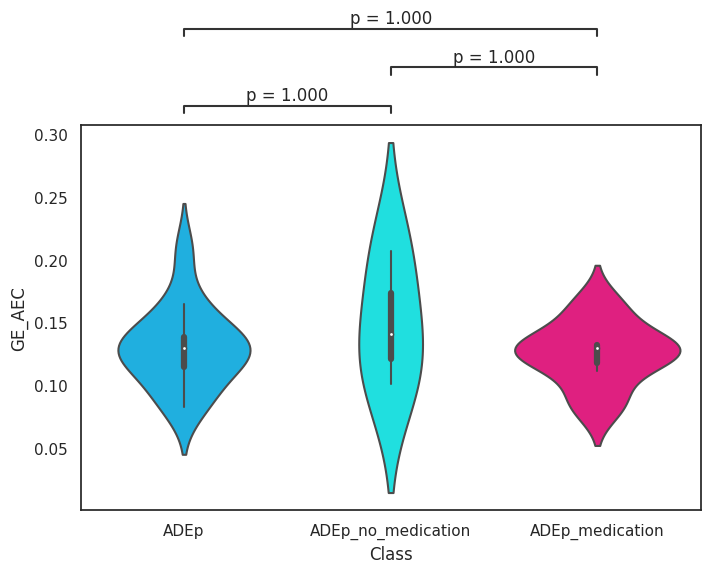

In [ ]:
# Now compare all ADEp vs the ADEp no_med and ADEp med (considering AEDs in general)
plot_med_effects(filtered_df_delta, 'ADEp', 'ADEp_no_medication', 'ADEp_medication', metric='GE_AEC', colors = ["#00bfff", "#00ffff", "#ff0080"])

In [ ]:
### Levetiracetam only
### Compare med and no_med groups with all the group of the same class (e.g., ADEp)

df_delta = features['1_delta']

# Create a new column "Medication" with default value NaN
df_delta["Medication"] = np.nan

# Update the "Medication" column based on the medication and non-medication lists
df_delta.loc[df_delta["ID"].isin(levetiracetam), "Medication"] = 1
df_delta.loc[df_delta["ID"].isin(no_levetiratecam), "Medication"] = 0

# Select the desired columns
filtered_df_delta = df_delta[["Class", "ID", "GE_AEC", "Medication"]].copy()

# Duplicate the rows of 'ADEp' class and then modify the Class column
ADEp_rows = filtered_df_delta[filtered_df_delta["Class"] == "ADEp"].copy()

# Function to create the new class based on Medication value
def create_new_class_delta(row):
    if pd.isna(row['Medication']):
        return 'ADEp'
    elif row['Medication'] == 1:
        return 'ADEp_medication'
    else:
        return 'ADEp_no_medication'

# Apply the function to create the new class column only for ADEp_rows
ADEp_rows['Class'] = ADEp_rows.apply(create_new_class_delta, axis=1)

# Concatenate the modified ADEp_rows with the original dataframe
filtered_df_delta = pd.concat([filtered_df_delta, ADEp_rows], ignore_index=True)
filtered_df_delta

Class        ID    GE_AEC  Medication
0               ADNoEp  ADEX_026  0.128770         NaN
1               ADNoEp  ADEX_138  0.157520         NaN
2               ADNoEp  ADEX_019  0.170782         NaN
3               ADNoEp  ADEX_073  0.098449         NaN
4               ADNoEp  ADEX_102  0.150391         NaN
..                 ...       ...       ...         ...
92  ADEp_no_medication  ADEX_127  0.110999         0.0
93  ADEp_no_medication  ADEX_104  0.164888         0.0
94  ADEp_no_medication  ADEX_128  0.125499         0.0
95  ADEp_no_medication  ADEX_118  0.088268         0.0
96     ADEp_medication  ADEX_139  0.082606         1.0

[97 rows x 4 columns]

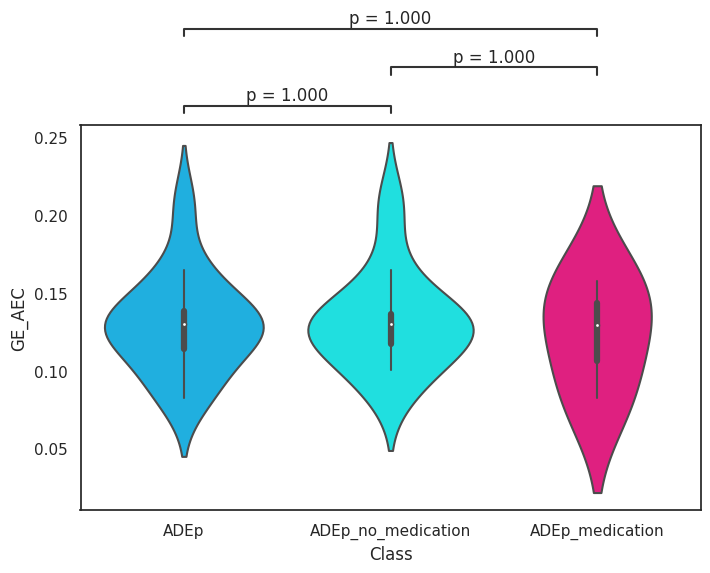

In [ ]:
# Now compare all ADEp vs the ADEp no_med and ADEp med
plot_med_effects(filtered_df_delta, 'ADEp', 'ADEp_no_medication', 'ADEp_medication', metric='GE_AEC', colors = ["#00bfff", "#00ffff", "#ff0080"])